In [17]:
!pip install bitsandbytes

# Creation of the dataset
In this notebook we will use the pipeline developed by the master thesis Trufanova, for the realization of the dataset.
We will start from the training reference notebook to run the train of the first model and to download the dataset automatically if it is not present in the reference path.

In [18]:
import glob
import json
import os, sys, random
from sys import platform

import torch
from dotenv import load_dotenv
from tqdm import tqdm


import pandas as pd
import siibra
import nibabel as nib
from nilearn import plotting, datasets, image
import numpy as np
import matplotlib.pyplot as plt
from monai.utils import set_determinism
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel

# importing file 
from alzheimer_disease.src.modules.postprocessing import get_gradcam, get_affected_areas, write_json_prompt
from alzheimer_disease.src.helpers.prompts import get_prompt
import alzheimer_disease.src.modules.plotting as plot
from alzheimer_disease.src.helpers.utils import make_dataset, get_device
from alzheimer_disease.src.modules.training import train_test_splitting, training_model, predict_model
from alzheimer_disease.src.helpers.config import get_config
from alzheimer_disease.src.modules.preprocessing import get_transformations
from alzheimer_disease.src.models.densenetmm import DenseNetMM

# I use two paths as I’m using an external hard disk to not occupy the memory of the laptop,
# in case you want to work on the same device, change the directories
_base_path = '/Volumes/Seagate Bas/Vito/CV'

sys.path.append(_base_path)

In [19]:
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')
		
saved_path, reports_path, logs_path

('/Volumes/Seagate Bas/Vito/CV/saved/',
 '/Volumes/Seagate Bas/Vito/CV/reports/',
 '/Volumes/Seagate Bas/Vito/CV/logs/')

check if the dataset is downloaded and if it is not present in the specified directory, re-load it

In [20]:
data_path, meta_path = make_dataset(dataset='oasis_aug', base_path=_base_path)


> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


DATA_PATH:  /Volumes/Seagate Bas/Vito/CV/data/oasis_aug/data
META_PATH:  /Volumes/Seagate Bas/Vito/CV/data/oasis_aug/meta

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 



As the colleague does, we set the seed to make the experiment deterministic

In [21]:
set_determinism(seed=3)
random.seed(3)

Definition of the features

In [22]:
SIZE = 128
CHANNELS = ['T2w']

FEATURES = ['sex', 'age', 'bmi', 'education', 'cdr_memory', 'cdr_orientation', 'cdr_judgment', 'cdr_community', 'cdr_hobbies', 'cdr_personalcare', 'boston_naming_test', 'depression', 'sleeping_disorder', 'motor_disturbance']
MULTICLASS = True

Definition of model

In [23]:
dense_net_model = DenseNetMM(
		in_channels = len(CHANNELS),
		in_size = SIZE,
		in_features_size= len(FEATURES),
		out_channels = 3 if MULTICLASS else 2,
		append_features = True
	)

train test split

In [24]:
train_data, eval_data, test_data = train_test_splitting(
	data_folder=data_path,
	meta_folder=meta_path,
	channels=CHANNELS,
	features=FEATURES,
	multiclass=MULTICLASS,
	load_from_file=False,
	reports_path=reports_path,
	write_to_file=True
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            372 (64.0 %)        93 (16.0 %)         120 (21.0 %)        

sessions            435 (63.6 %)        111 (16.23 %)       138 (20.18 %)       



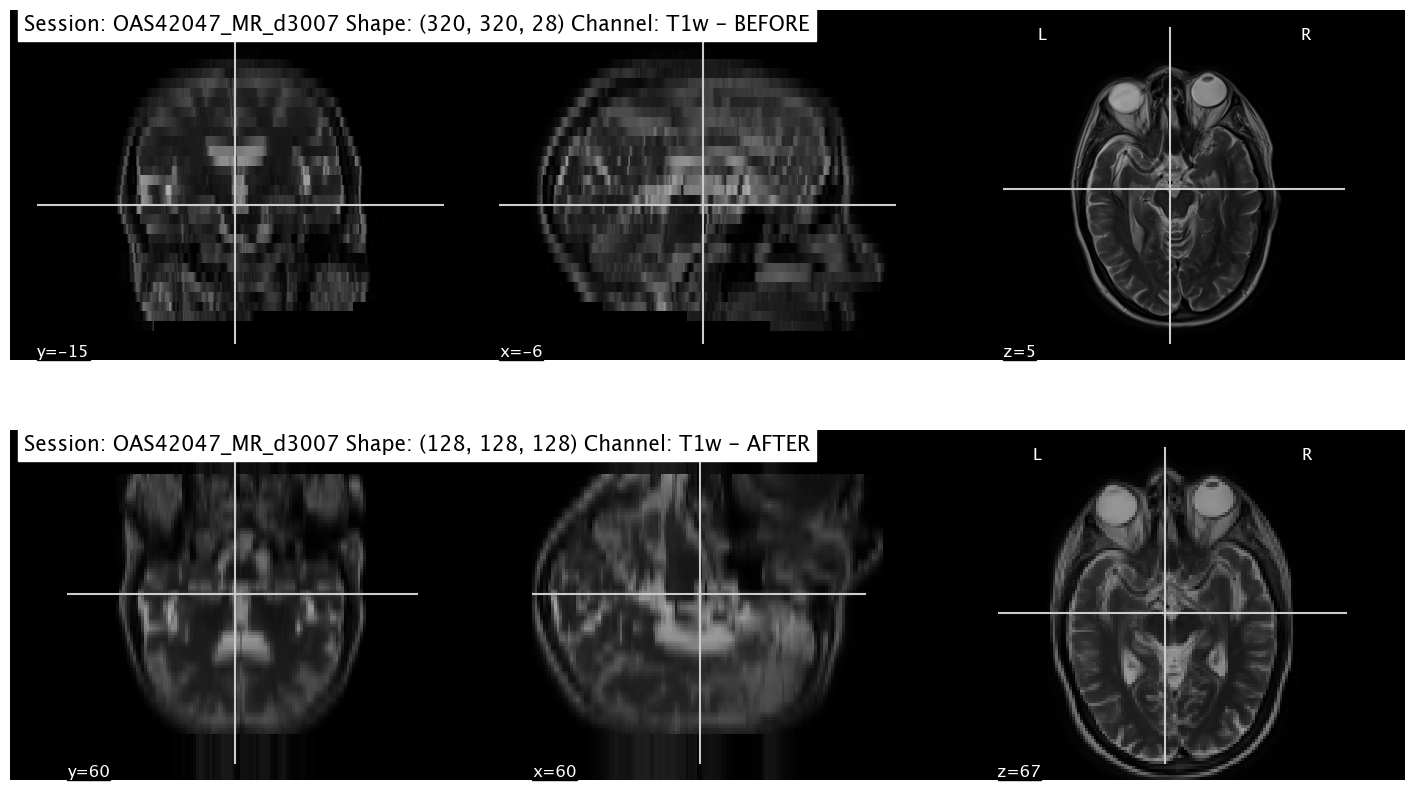

In [25]:
train_transform, eval_transform = get_transformations(size=SIZE)
plot.image_transformations(train_data)

In [26]:
if glob.glob(saved_path+ 'DenseNetMM_best.pth'):
	print('Loading DenseNetMM_best.pth')
	dense_net_model.load_state_dict(torch.load(saved_path + 'DenseNetMM_best.pth'))
else:
	print('Train of the model')
	train_metrics = training_model(
		model = dense_net_model,
		data = [train_data, eval_data],
		transforms = [train_transform, eval_transform],
		epochs = 30,
		device = get_device(),
		paths = [saved_path, reports_path, logs_path],
		num_workers=0,
		verbose=True
	)

Loading DenseNetMM_best.pth


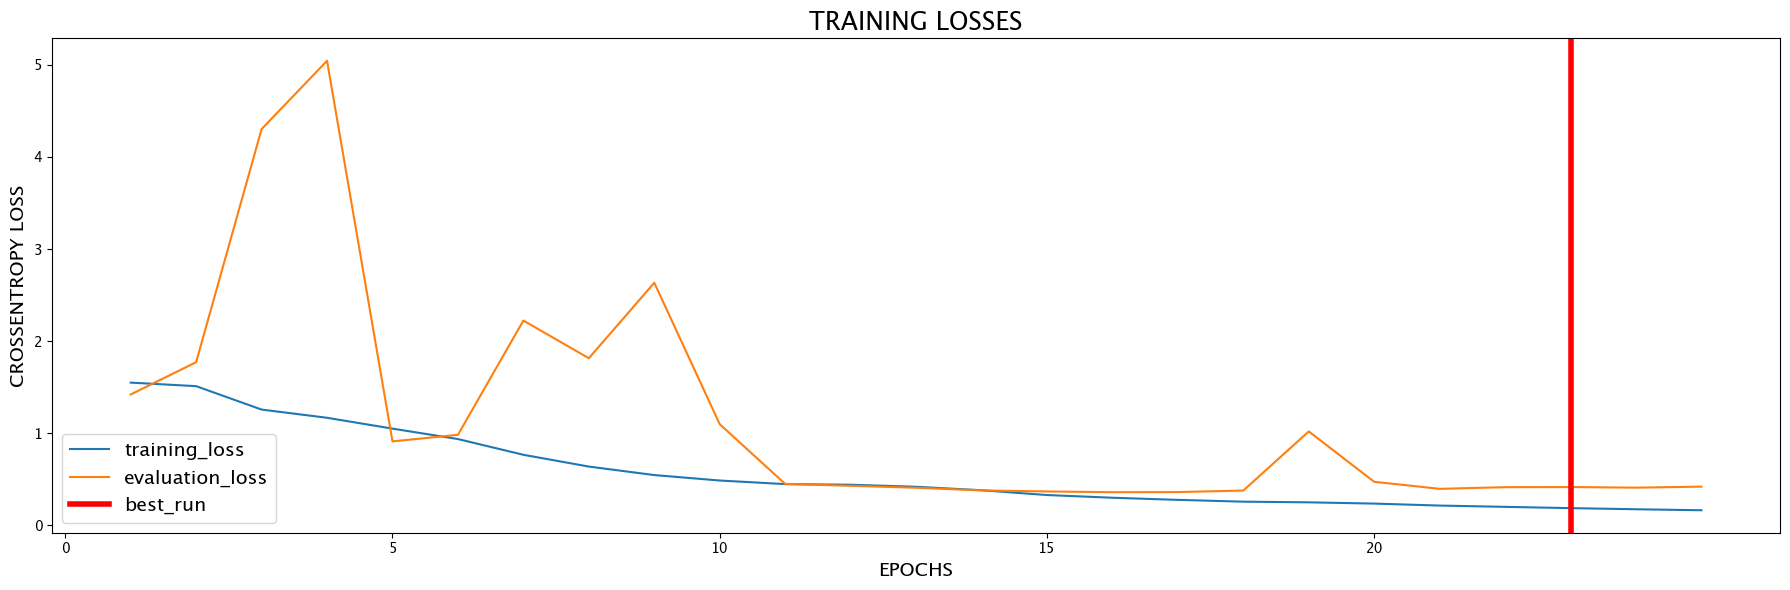

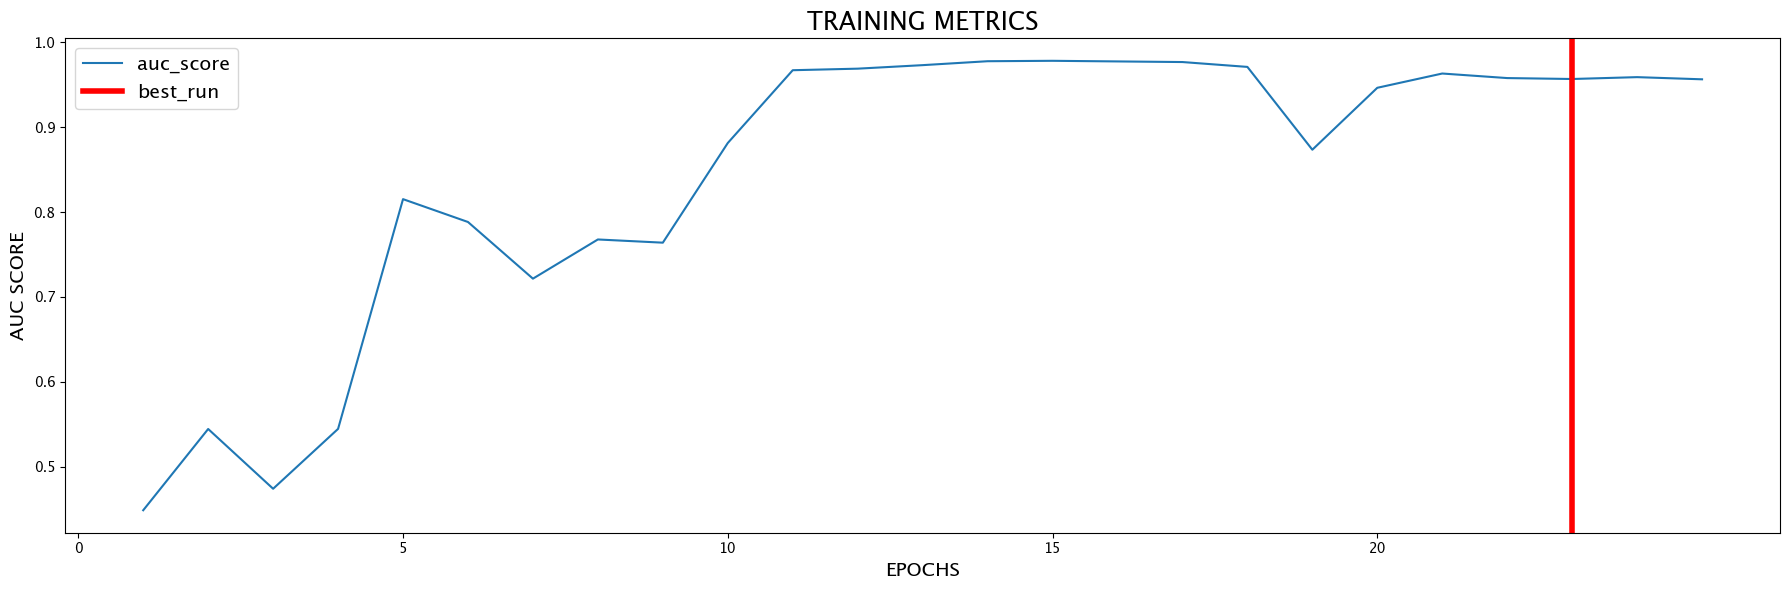

In [27]:
plot.training_values(reports_path)

In [28]:
test_metrics = predict_model(
	model = dense_net_model,
	data = test_data,
	transforms = eval_transform,
	device = 'cpu',
	paths = [saved_path, reports_path, logs_path],
	num_workers=0,
	verbose=True
)

inference 1/138
inference 20/138
inference 40/138
inference 60/138
inference 80/138
inference 100/138
inference 120/138


In [29]:
#plot.results_multiclass(reports_path)

The second imported notebook is the post-processing

In [30]:
json_path = os.path.join(_base_path, _config.get('JSON_FOLDER'))
json_path

'/Volumes/Seagate Bas/Vito/CV/json/'

In [31]:
atlas = siibra.atlases['human']
parcellations = list(atlas.parcellations)

Loading preconfigured Parcellation instances: 100%|██████████| 27/27 [00:00<00:00, 397.88Parcellation/s]


In [32]:
print(''.join(['> ' for i in range(40)]))
print(f'\n{"INDEX":<8}{"PARCELLATIONS NAME":<20}\n')
print(''.join(['> ' for i in range(40)]))
for i, p in enumerate(parcellations):
	print(f'{i:<8}{p.name:<20}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

INDEX   PARCELLATIONS NAME  

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
0       Deep white matter fibre bundles
1       Superficial fibre bundles
2       Cortical layer segmentation of the BigBrain model
3       DiFuMo Atlas (1024 dimensions)
4       DiFuMo Atlas (128 dimensions)
5       DiFuMo Atlas (256 dimensions)
6       DiFuMo Atlas (512 dimensions)
7       DiFuMo Atlas (64 dimensions)
8       Desikan-Killiany Atlas (2006)
9       Isocortex Segmentation
10      Julich-Brain Cytoarchitectonic Atlas (v1.18)
11      Julich-Brain Cytoarchitectonic Atlas (v2.9)
12      Julich-Brain Cytoarchitectonic Atlas (v3.0.3)
13      [PRERELEASE] Julich-Brain Cytoarchitectonic Atlas (v3.1)
14      MarsAtlas cortical parcellation model
15      Atlas of the short fiber bundles inferred from the Human Connectome Project diffusion MRI dataset
16      Virtual Epileptic Patient Atlas


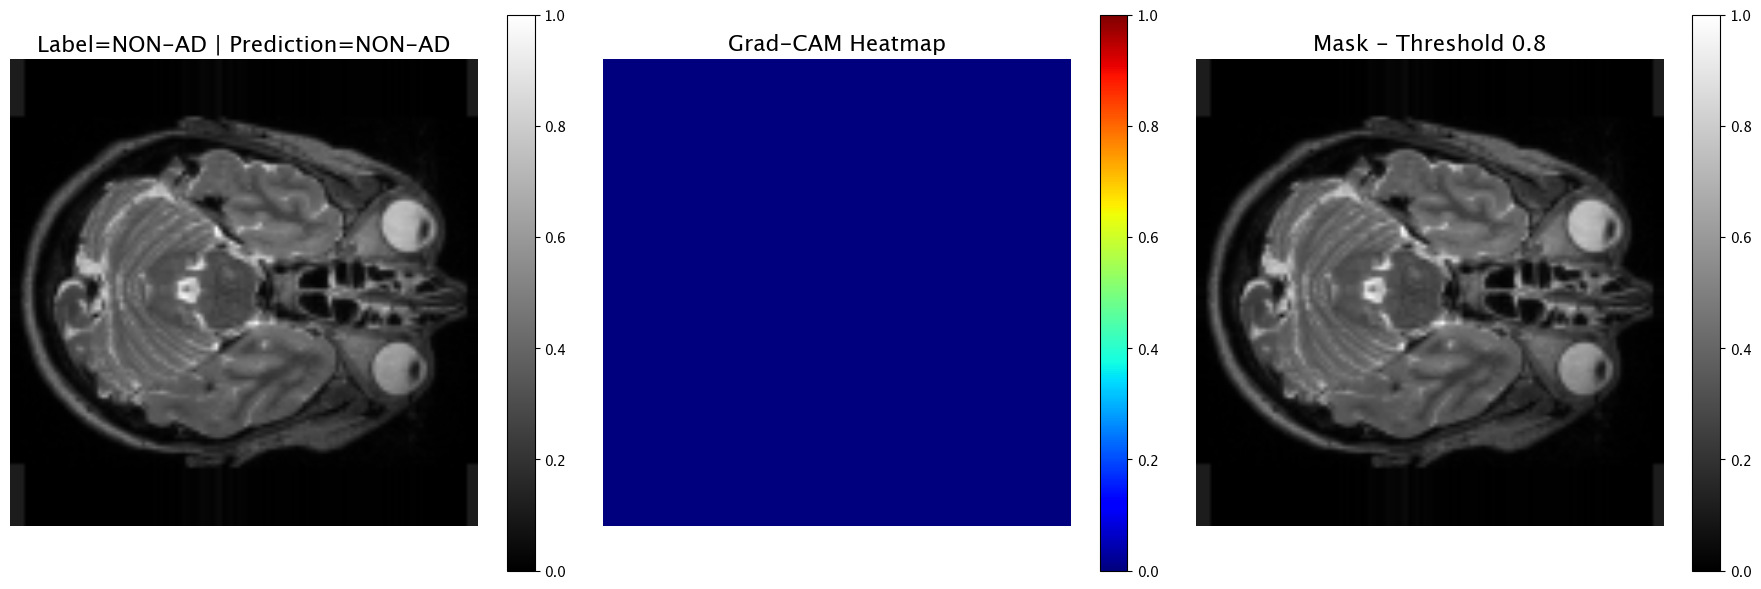

In [33]:
example = test_data[0]
example_name = example['image'][0].split('/')[-2]
input_img, mask, pred = get_gradcam(example, dense_net_model, saved_path, threshold=.8, plot_results=True)

In [34]:
mni_template = datasets.load_mni152_template()
heat = nib.Nifti1Image(mask, affine=mni_template.affine)
bg = nib.Nifti1Image(input_img, affine=mni_template.affine)
heat_norm = image.resample_to_img(heat, mni_template)
points = siibra.PointSet(tuple(zip(*np.where(heat_norm.get_fdata() == 1))), space='mni152', sigma_mm=5).transform(mni_template.affine, space='mni152')
if len(points):
	plotting.view_markers(list(map(tuple, points)), marker_color='red', marker_size=1, title='TC (Tumor Core)')

In [35]:
areas = get_affected_areas(
	parcellation=parcellations[12].name,
	volume=points,
	top=5,
	verbose=False
)

Loading preconfigured Map instances: 100%|██████████| 58/58 [00:00<00:00, 171.06Map/s]
[siibra:WARNING] Map registry contains multiple classes: Map, SparseMap
Assigning points: 0it [00:00, ?it/s]


In [36]:
write_json_prompt(
	example=example['image'][0].split('/')[-2],
	areas=areas,
	prediction=pred,
	json_path=json_path
)

In [37]:
julich_pmaps = siibra.get_map(
	parcellation=siibra.parcellations.get(parcellations[12].name),
	space=siibra.spaces.get('mni152'),
	maptype=siibra.MapType.LABELLED
)
for a in areas:
	fig = plt.figure(figsize=(18, 6))
	plotting.plot_roi(
		roi_img=julich_pmaps.fetch(region=a),
		bg_img=mni_template,
		title=a,
		cmap='viridis',
		black_bg=False,
		figure=fig
	)
	plotting.show()

The last imported notebook is the explainability

In [38]:
prompt_path = os.path.join(_base_path, _config.get('PROMPT_FOLDER'))

In [39]:
_config = get_config()
_prompt = get_prompt()
json_path = os.path.join(_base_path, _config.get('JSON_FOLDER'))
if platform == 'win32':
	json_path = json_path.replace('/', '\\')
	prompt_path = prompt_path.replace('/', '\\')

In [40]:
MODELS = {
	'biomistral': 'BioMistral/BioMistral-7B',
	'llama': 'meta-llama/Meta-Llama-3-8B-Instruct',
	'mistral': 'mistralai/Mistral-7B-Instruct-v0.2',
	'minerva': 'sapienzanlp/Minerva-1B-base-v1.0',
	'llamantino': 'swap-uniba/LLaMAntino-3-ANITA-8B-Inst-DPO-ITA'
}

In [41]:
LANG = 'EN'
model_id = MODELS.get('llama')
PROMPT = _prompt.get(LANG).get('prompt_2')

with open(os.path.join(json_path, 'OAS30031_MR_d0427_' + LANG.upper() + '.json'), 'r') as f:
	d = json.load(f)
	PROMPT += str(d)

## Preparation of the dataset

In [42]:
def prepare_dataset_for_task(
		data_folder,
		meta_folder,
		channels,
		features,
		multiclass=False
	):
	"""
	Starting from the folder containing all the examples, let’s prepare the data for the dataset creation process
	:param data_folder: folder containing all the examples
	:param meta_folder: folder containing all the metadata
	:param channels: channels to use
	:param features: features to use
	:param multiclass: if the dataset is multiclass
	:return: all the example
	"""
	
	# preparing numerical data and utils
	scaler = MinMaxScaler()
	df = pd.read_csv(os.path.join(meta_folder, 'data_num.csv'))
	df1 = df[(df['weight'] != .0) & (df['height'] != .0)]
	df['bmi'] = round(df1['weight'] / (df1['height'] * df1['height']), 0)
	df['bmi'] = df['bmi'].fillna(.0)
	sessions = [s.split('_')[0] for s in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, s))]
	subjects = list(set(sessions))
	
	# applying multiclass label correction and splitting
	if multiclass:
		train_subjects, eval_subjects, test_subjects = [], [], []
		df.loc[df['cdr'] == .0, 'final_dx'] = .0
		df.loc[df['cdr'] == .5, 'final_dx'] = 1.
		df.loc[(df['cdr'] != .0) & (df['cdr'] != .5), 'final_dx'] = 2.
		m = np.min(np.unique(df['final_dx'].to_numpy(), return_counts=True)[1])
		df = pd.concat([
			df[df['final_dx'] == .0].sample(m),
			df[df['final_dx'] == 1.].sample(m),
			df[df['final_dx'] == 2.].sample(m)
		], ignore_index=True)
		for i in range(3):
			sub = list(set(df[df['final_dx'] == float(i)]['subject_id'].to_numpy()))
			random.shuffle(sub)
			for j in range(len(sub)):
				subjects.append(sub[j])

	# loading sessions paths
	X = df[df['subject_id'].isin(subjects)]
	sessions = [os.path.join(data_folder, s) for s in X['session_id'].values]

	# scaling numerical data in range [0,1]
	X.loc[:, features] = scaler.fit_transform(X[features])

	# arranging data in dictionaries
	data = [dict({
		'image': sorted([os.path.join(s, i) for i in os.listdir(s) if any(c in i for c in channels)]),
		'data': X[X['session_id'] == s.split('/')[-1]][features].values[0],
		'label': df[df['session_id'] == s.split('/')[-1]]['final_dx'].values[0],
		'subject_id': df[df['session_id'] == s.split('/')[-1]]['subject_id'].values[0],
		'session_id': s.split('/')[-1]
	}) for s in sessions]

	return data

In [43]:
data = prepare_dataset_for_task(
	data_folder=data_path,
	meta_folder=meta_path,
	channels=CHANNELS,
	features=FEATURES,
	multiclass=False
)

len(data)

1152

In [44]:
data[0]

{'image': ['/Volumes/Seagate Bas/Vito/CV/data/oasis_aug/data/OAS30009_MR_d0148/sub-OAS30009_ses-d0148_T2w.nii.gz'],
 'data': array([1.        , 0.06      , 0.46666667, 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.5       , 0.5       , 0.5       ]),
 'label': 0.0,
 'subject_id': 'OAS30009',
 'session_id': 'OAS30009_MR_d0148'}

In [45]:
df_explainability = pd.DataFrame(columns=['subject_id', 'session_id', 'prompt_llm'])

for example in tqdm(data):
    example_name = example['image'][0].split('/')[-2]
    input_img, mask, pred = get_gradcam(example, dense_net_model, saved_path, threshold=.8, plot_results=False)
    
    mni_template = datasets.load_mni152_template()
    heat = nib.Nifti1Image(mask, affine=mni_template.affine)
    bg = nib.Nifti1Image(input_img, affine=mni_template.affine)
    heat_norm = image.resample_to_img(heat, mni_template)
    points = siibra.PointSet(tuple(zip(*np.where(heat_norm.get_fdata() == 1))), space='mni152', sigma_mm=5).transform(mni_template.affine, space='mni152')
    
    areas = get_affected_areas(
    	parcellation=parcellations[12].name,
    	volume=points,
    	top=5,
    	verbose=False
    )
    
    write_json_prompt(
    	example=example['image'][0].split('/')[-2],
    	areas=areas,
    	prediction=pred,
    	json_path=json_path
    )
    
    PROMPT = _prompt.get(LANG).get('prompt_1')
    
    with open(os.path.join(json_path, 'OAS30031_MR_d0427_' + LANG.upper() + '.json'), 'r') as f:
    	d = json.load(f)
    	PROMPT += str(d)
    
    """
    inputs = tokenizer.apply_chat_template(
    	[{'role': 'user', 'content': PROMPT}],
    	add_generation_prompt = True,
    	return_tensors = 'pt'
    ).to(device)
    
    
    outputs = llm_model.generate(
    	inputs,
    	max_new_tokens = output_length,
    	eos_token_id = [
    		tokenizer.eos_token_id,
    		tokenizer.convert_tokens_to_ids('<|eot_id|>')
    	],
    	pad_token_id = tokenizer.eos_token_id,
    	do_sample = True,
    	temperature = 0.6,
    	top_p = 0.9,
    )
    readable_output = tokenizer.decode(outputs[0][inputs.shape[-1]:], skip_special_tokens=True)
    """
	
    df_explainability.loc[len(df_explainability)] = {
		'subject_id': example['subject_id'],
		'session_id': example['session_id'],
		'prompt_llm': PROMPT
	}

  0%|          | 0/1152 [00:00<?, ?it/s]
Assigning points: 0it [00:00, ?it/s]
  0%|          | 1/1152 [00:05<1:41:38,  5.30s/it]
Assigning points: 0it [00:00, ?it/s]
  0%|          | 2/1152 [00:11<1:52:54,  5.89s/it]
Assigning points: 0it [00:00, ?it/s]
  0%|          | 3/1152 [00:20<2:17:24,  7.18s/it]

      Temporal-to-Parietal (GapMap) left          20.37          52.28
      Frontal-to-Occipital (GapMap) left           6.35          24.45
     Frontal-to-Occipital (GapMap) right           4.87          20.21
                     Area PGp (IPL) left           4.30          98.75


  0%|          | 4/1152 [00:31<2:46:26,  8.70s/it]

         Area hOc1 (V1, 17, CalcS) right           2.52          29.44



Assigning points: 0it [00:00, ?it/s]
  0%|          | 5/1152 [00:37<2:31:11,  7.91s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 6/1152 [00:43<2:15:00,  7.07s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 7/1152 [00:48<2:04:33,  6.53s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 8/1152 [00:54<1:57:34,  6.17s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 9/1152 [00:59<1:50:56,  5.82s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 10/1152 [01:04<1:47:26,  5.65s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 11/1152 [01:10<1:49:44,  5.77s/it]
Assigning points: 0it [00:00, ?it/s]
  1%|          | 12/1152 [01:17<1:56:35,  6.14s/it]

      Temporal-to-Parietal (GapMap) left          14.64          16.07
      Frontal-to-Occipital (GapMap) left          13.47          22.18
          Area hOc1 (V1, 17, CalcS) left          11.75          70.86
                  Area hOc4lp (LOC) left           6.71          81.48


  1%|          | 13/1152 [01:25<2:08:39,  6.78s/it]

                 Area hOc3v (LingG) left           6.55          94.84
      Frontal-to-Occipital (GapMap) left          13.35          24.33
      Temporal-to-Parietal (GapMap) left          12.65          15.37
          Area hOc1 (V1, 17, CalcS) left          11.23          74.93
                  Area hOc4lp (LOC) left           6.89          92.71


  1%|          | 14/1152 [01:34<2:20:06,  7.39s/it]

                 Area hOc3v (LingG) left           6.23          99.95



Assigning points: 0it [00:00, ?it/s]
  1%|▏         | 15/1152 [01:40<2:09:30,  6.83s/it]

      Frontal-to-Occipital (GapMap) left          19.90          17.81
          Area hOc1 (V1, 17, CalcS) left          13.24          43.39
      Temporal-to-Parietal (GapMap) left          12.87           7.68
                 Area hOc4v (LingG) left           8.06          68.77


  1%|▏         | 16/1152 [01:47<2:12:06,  6.98s/it]

                 Area hOc3v (LingG) left           6.54          51.49



Assigning points: 0it [00:00, ?it/s]
  1%|▏         | 17/1152 [01:52<2:03:29,  6.53s/it]
Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 18/1152 [01:57<1:55:24,  6.11s/it]
Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 19/1152 [02:03<1:52:34,  5.96s/it]

      Temporal-to-Parietal (GapMap) left          35.07          13.63
                Area hOc2 (V2, 18) right           6.24          17.84
         Area hOc1 (V1, 17, CalcS) right           4.61           8.15
    Frontal-to-Temporal-II (GapMap) left           4.21          10.06


  2%|▏         | 20/1152 [02:10<1:59:01,  6.31s/it]

            Subiculum (Hippocampus) left           3.52          30.91



Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 21/1152 [02:15<1:52:14,  5.95s/it]
Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 22/1152 [02:21<1:48:34,  5.77s/it]

      Temporal-to-Parietal (GapMap) left          18.82          57.99
      Frontal-to-Occipital (GapMap) left           9.16          42.32
          Area hOc1 (V1, 17, CalcS) left           5.91         100.00
         Area hOc1 (V1, 17, CalcS) right           4.36          61.07


  2%|▏         | 23/1152 [02:32<2:19:25,  7.41s/it]

     Frontal-to-Occipital (GapMap) right           4.36          21.75



Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 24/1152 [02:38<2:11:50,  7.01s/it]
Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 25/1152 [02:43<2:00:42,  6.43s/it]
Assigning points: 0it [00:00, ?it/s]
  2%|▏         | 26/1152 [02:48<1:54:01,  6.08s/it]

      Temporal-to-Parietal (GapMap) left          35.23          19.29
    Frontal-to-Temporal-II (GapMap) left           6.64          22.35
            Subiculum (Hippocampus) left           3.99          49.38
                Frontal-II (GapMap) left           3.18           5.61


  2%|▏         | 27/1152 [02:56<2:01:40,  6.49s/it]

      Frontal-to-Occipital (GapMap) left           3.07           2.52
      Temporal-to-Parietal (GapMap) left          24.03          28.87
         Area hOc1 (V1, 17, CalcS) right           5.84          31.90
     Frontal-to-Occipital (GapMap) right           5.59          10.87
                Area hOc2 (V2, 18) right           5.23          46.23


  2%|▏         | 28/1152 [03:04<2:13:28,  7.12s/it]

    Frontal-to-Temporal-II (GapMap) left           3.98          29.38



Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 29/1152 [03:10<2:03:33,  6.60s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 30/1152 [03:17<2:08:00,  6.85s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 31/1152 [03:24<2:08:07,  6.86s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 32/1152 [03:35<2:33:04,  8.20s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 33/1152 [03:43<2:28:08,  7.94s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 34/1152 [03:49<2:17:47,  7.40s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 35/1152 [03:55<2:08:14,  6.89s/it]
Assigning points: 0it [00:00, ?it/s]
  3%|▎         | 36/1152 [04:00<2:02:33,  6.59s/it]

      Frontal-to-Occipital (GapMap) left          14.43          24.42
      Temporal-to-Parietal (GapMap) left          13.16          14.85
          Area hOc1 (V1, 17, CalcS) left          11.64          72.17
                  Area hOc4lp (LOC) left           7.32          91.36


  3%|▎         | 37/1152 [04:09<2:14:12,  7.22s/it]

                 Area hOc4v (LingG) left           6.15          99.15
      Frontal-to-Occipital (GapMap) left          13.03          21.89
          Area hOc1 (V1, 17, CalcS) left          12.26          75.45
      Temporal-to-Parietal (GapMap) left           9.09          10.19
                  Area hOc4lp (LOC) left           8.00          99.22


  3%|▎         | 38/1152 [04:17<2:19:49,  7.53s/it]

                 Area hOc3v (LingG) left           6.56          96.95
        Area 6mp (SMA, mesial SFG) right          50.29          13.65
         Area 6mp (SMA, mesial SFG) left          22.15           6.81
                   Area 4a (PreCG) right           9.11           0.90
                  Area 6d1 (PreCG) right           4.15           0.37


  3%|▎         | 39/1152 [04:25<2:18:07,  7.45s/it]

                    Area 1 (PostCG) left           4.04           0.54
      Temporal-to-Parietal (GapMap) left          15.38          22.69
      Frontal-to-Occipital (GapMap) left          10.84          23.98
          Area hOc1 (V1, 17, CalcS) left          10.83          87.72
                  Area hOc4lp (LOC) left           6.13         100.00


  3%|▎         | 40/1152 [04:33<2:25:08,  7.83s/it]

                 Area hOc2 (V2, 18) left           5.61          82.16



Assigning points: 0it [00:00, ?it/s]
  4%|▎         | 41/1152 [04:39<2:14:20,  7.26s/it]

      Temporal-to-Parietal (GapMap) left          15.34          22.55
      Frontal-to-Occipital (GapMap) left          13.16          29.01
          Area hOc1 (V1, 17, CalcS) left           7.37          59.51
                  Area hOc4lp (LOC) left           6.14          99.82


  4%|▎         | 42/1152 [04:50<2:32:42,  8.25s/it]

                     Area PGp (IPL) left           5.43          71.50



Assigning points: 0it [00:00, ?it/s]
  4%|▎         | 43/1152 [04:57<2:27:05,  7.96s/it]
Assigning points: 0it [00:00, ?it/s]
  4%|▍         | 44/1152 [05:03<2:15:26,  7.33s/it]
Assigning points: 0it [00:00, ?it/s]
  4%|▍         | 45/1152 [05:08<2:03:35,  6.70s/it]

      Temporal-to-Parietal (GapMap) left          15.91          22.03
      Frontal-to-Occipital (GapMap) left           8.26          17.14
                    Area hIP3 (IPS) left           3.36          68.73
     Frontal-to-Occipital (GapMap) right           3.35           7.50


  4%|▍         | 46/1152 [05:19<2:25:52,  7.91s/it]

                    Area STS1 (STS) left           3.14          69.78



Assigning points: 0it [00:00, ?it/s]
  4%|▍         | 47/1152 [05:26<2:22:21,  7.73s/it]
Assigning points: 0it [00:00, ?it/s]
  4%|▍         | 48/1152 [05:32<2:10:39,  7.10s/it]
Assigning points: 0it [00:00, ?it/s]
  4%|▍         | 49/1152 [05:38<2:03:27,  6.72s/it]

      Temporal-to-Parietal (GapMap) left          22.25           4.57
    Frontal-to-Temporal-II (GapMap) left          15.66          19.77
            Subiculum (Hippocampus) left           7.70          35.73
                    Area STS1 (STS) left           7.59          25.03


  4%|▍         | 50/1152 [05:46<2:09:54,  7.07s/it]

                 CGM (Metathalamus) left           5.81          50.94
      Temporal-to-Parietal (GapMap) left          19.99           7.44
    Frontal-to-Temporal-II (GapMap) left          11.71          26.76
                    Area STS1 (STS) left          10.04          59.93
                  Area TE 2.2 (STG) left           7.86          60.50


  4%|▍         | 51/1152 [05:54<2:15:02,  7.36s/it]

                 CGM (Metathalamus) left           5.27          83.61
      Frontal-to-Occipital (GapMap) left          14.61          18.29
          Area hOc1 (V1, 17, CalcS) left          13.17          60.37
      Temporal-to-Parietal (GapMap) left          12.78          10.67
                  Area hOc4lp (LOC) left           9.71          89.65


  5%|▍         | 52/1152 [06:02<2:17:56,  7.52s/it]

                 Area hOc4v (LingG) left           8.30          98.94



Assigning points: 0it [00:00, ?it/s]
  5%|▍         | 53/1152 [06:08<2:13:49,  7.31s/it]

      Temporal-to-Parietal (GapMap) left          28.23          56.77
                     Area PGp (IPL) left           5.18          93.24
          Area hOc1 (V1, 17, CalcS) left           4.04          44.62
                  Area hOc4lp (LOC) left           3.63          80.65


  5%|▍         | 54/1152 [06:18<2:28:59,  8.14s/it]

                 Area hOc2 (V2, 18) left           3.47          69.16
      Temporal-to-Parietal (GapMap) left          32.53          13.44
    Frontal-to-Temporal-II (GapMap) left          11.16          28.33
                    Area STS1 (STS) left           6.60          43.72
                    Area FG4 (FusG) left           6.40          38.72


  5%|▍         | 55/1152 [06:26<2:25:29,  7.96s/it]

            Subiculum (Hippocampus) left           4.56          42.54
      Temporal-to-Parietal (GapMap) left          61.24           9.34
    Frontal-to-Temporal-II (GapMap) left          12.50          11.70
            Subiculum (Hippocampus) left           8.07          27.79
                  Entorhinal Cortex left           5.29          25.26


  5%|▍         | 56/1152 [06:33<2:22:05,  7.78s/it]

                  CA1 (Hippocampus) left           3.87          17.55
      Temporal-to-Parietal (GapMap) left          23.92          64.11
      Frontal-to-Occipital (GapMap) left           7.84          31.52
          Area hOc1 (V1, 17, CalcS) left           5.26          77.37
         Area hOc1 (V1, 17, CalcS) right           4.48          54.59


  5%|▍         | 57/1152 [06:45<2:40:36,  8.80s/it]

                     Area PGp (IPL) left           3.42          82.03



Assigning points: 0it [00:00, ?it/s]
  5%|▌         | 58/1152 [06:50<2:21:42,  7.77s/it]

      Temporal-to-Parietal (GapMap) left          26.56          58.82
      Frontal-to-Occipital (GapMap) left           6.49          21.56
         Area hOc1 (V1, 17, CalcS) right           4.17          41.93
                     Area PGp (IPL) left           3.85          76.35


  5%|▌         | 59/1152 [07:00<2:34:00,  8.45s/it]

    Frontal-to-Temporal-II (GapMap) left           3.49          47.45



Assigning points: 0it [00:00, ?it/s]
  5%|▌         | 60/1152 [07:05<2:16:18,  7.49s/it]
Assigning points: 0it [00:00, ?it/s]
  5%|▌         | 61/1152 [07:11<2:04:59,  6.87s/it]
Assigning points: 0it [00:00, ?it/s]
  5%|▌         | 62/1152 [07:16<1:56:01,  6.39s/it]

      Frontal-to-Occipital (GapMap) left          37.30           0.41
         Area 6mp (SMA, mesial SFG) left          32.64           7.20
                     Area 6d3 (SFS) left          18.65           2.36
                   Area 6d1 (PreCG) left           5.47           0.42


  5%|▌         | 63/1152 [07:22<1:56:02,  6.39s/it]

                    Area 4a (PreCG) left           4.34           0.33
      Temporal-to-Parietal (GapMap) left          18.28          47.03
      Frontal-to-Occipital (GapMap) left           9.67          37.29
          Area hOc1 (V1, 17, CalcS) left           7.08         100.00
                     Area PGp (IPL) left           4.31          99.24


  6%|▌         | 64/1152 [07:33<2:19:10,  7.68s/it]

                 Area hOc2 (V2, 18) left           3.90          99.54
      Temporal-to-Parietal (GapMap) left          21.41           4.90
    Frontal-to-Temporal-II (GapMap) left          13.99          19.69
                    Area STS1 (STS) left          10.93          40.16
            Subiculum (Hippocampus) left           6.64          34.33


  6%|▌         | 65/1152 [07:40<2:16:33,  7.54s/it]

                 CGM (Metathalamus) left           5.18          50.59
      Temporal-to-Parietal (GapMap) left          17.74          31.10
      Frontal-to-Occipital (GapMap) left          10.43          27.42
                     Area PGp (IPL) left           5.64          88.48
          Area hOc1 (V1, 17, CalcS) left           4.02          38.65


  6%|▌         | 66/1152 [07:49<2:24:12,  7.97s/it]

                     Area PFm (IPL) left           3.86          79.54
      Temporal-to-Parietal (GapMap) left          16.79          22.76
      Frontal-to-Occipital (GapMap) left          14.12          28.68
          Area hOc1 (V1, 17, CalcS) left           6.45          47.95
                 Area hOc4v (LingG) left           5.14          99.42


  6%|▌         | 67/1152 [07:57<2:25:12,  8.03s/it]

                     Area PGp (IPL) left           5.06          61.41
      Temporal-to-Parietal (GapMap) left          16.28          30.62
      Frontal-to-Occipital (GapMap) left          12.06          34.00
          Area hOc1 (V1, 17, CalcS) left           5.65          58.30
                     Area PGp (IPL) left           5.61          94.52


  6%|▌         | 68/1152 [08:06<2:30:48,  8.35s/it]

                  Area hOc4lp (LOC) left           4.70          97.89



Assigning points: 0it [00:00, ?it/s]
  6%|▌         | 69/1152 [08:12<2:16:06,  7.54s/it]
Assigning points: 0it [00:00, ?it/s]
  6%|▌         | 70/1152 [08:18<2:05:49,  6.98s/it]

      Frontal-to-Occipital (GapMap) left          22.55          19.06
          Area hOc1 (V1, 17, CalcS) left          16.73          51.80
      Temporal-to-Parietal (GapMap) left           9.90           5.58
                 Area hOc4v (LingG) left           7.73          62.26


  6%|▌         | 71/1152 [08:25<2:05:41,  6.98s/it]

                 Area hOc3v (LingG) left           7.00          52.06



Assigning points: 0it [00:00, ?it/s]
  6%|▋         | 72/1152 [08:30<1:56:06,  6.45s/it]

      Frontal-to-Occipital (GapMap) left          15.10          13.03
                 Area hOc4v (LingG) left          11.57          95.18
          Area hOc1 (V1, 17, CalcS) left           8.57          27.09
                 Area hOc3v (LingG) left           7.90          60.03


  6%|▋         | 73/1152 [08:37<2:00:36,  6.71s/it]

                    Area FG3 (FusG) left           6.16          65.52



Assigning points: 0it [00:00, ?it/s]
  6%|▋         | 74/1152 [08:43<1:54:17,  6.36s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 75/1152 [08:48<1:48:32,  6.05s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 76/1152 [08:53<1:42:53,  5.74s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 77/1152 [08:58<1:39:52,  5.57s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 78/1152 [09:04<1:39:40,  5.57s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 79/1152 [09:09<1:37:16,  5.44s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 80/1152 [09:14<1:36:12,  5.39s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 81/1152 [09:19<1:35:01,  5.32s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 82/1152 [09:25<1:36:32,  5.41s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 83/1152 [09:30<1:33:40,  5.26s/it]
Assigning points: 0it [00:00, ?it/s]
  7%|▋         | 84/1152 [09:35<1:32:07,  5.18s/it]
Assigning points: 0i

      Temporal-to-Parietal (GapMap) left          55.13           9.30
                    Area FG4 (FusG) left          30.51          75.37
                    Area FG2 (FusG) left           7.27          25.28
                    Area FG3 (FusG) left           6.38          19.89


  7%|▋         | 86/1152 [09:49<1:49:58,  6.19s/it]

                    Area FG1 (FusG) left           0.71           5.03
          Area hOc1 (V1, 17, CalcS) left          13.46          83.06
      Frontal-to-Occipital (GapMap) left          10.69          18.02
      Temporal-to-Parietal (GapMap) left           8.81           9.91
                  Area hOc4lp (LOC) left           7.98          99.25


  8%|▊         | 87/1152 [09:57<2:01:42,  6.86s/it]

                 Area hOc3v (LingG) left           6.74         100.00



Assigning points: 0it [00:00, ?it/s]
  8%|▊         | 88/1152 [10:03<1:56:15,  6.56s/it]
Assigning points: 0it [00:00, ?it/s]
  8%|▊         | 89/1152 [10:09<1:54:02,  6.44s/it]

      Frontal-to-Occipital (GapMap) left          19.61          30.00
      Temporal-to-Parietal (GapMap) left          14.06          14.34
          Area hOc1 (V1, 17, CalcS) left          10.16          56.90
                  Area hOc4lp (LOC) left           6.57          74.19


  8%|▊         | 90/1152 [10:17<2:01:28,  6.86s/it]

                 Area hOc4v (LingG) left           4.41          64.25



Assigning points: 0it [00:00, ?it/s]
  8%|▊         | 91/1152 [10:23<1:54:44,  6.49s/it]

      Temporal-to-Parietal (GapMap) left          20.72           3.18
    Frontal-to-Temporal-II (GapMap) left          15.40          14.54
                    Area STS1 (STS) left           9.95          24.54
            Subiculum (Hippocampus) left           8.54          29.64


  8%|▊         | 92/1152 [10:30<1:59:28,  6.76s/it]

                 CGM (Metathalamus) left           4.86          31.91
      Frontal-to-Occipital (GapMap) left          16.27          14.87
          Area hOc1 (V1, 17, CalcS) left          15.87          53.11
                 Area hOc4v (LingG) left           9.94          86.53
                 Area hOc3v (LingG) left           9.74          78.30


  8%|▊         | 93/1152 [10:37<2:02:03,  6.92s/it]

                  Area hOc4lp (LOC) left           7.59          51.19
      Temporal-to-Parietal (GapMap) left          55.47           6.62
                Frontal-II (GapMap) left           7.37           2.84
        Area 6mp (SMA, mesial SFG) right           4.86          15.25
      Frontal-to-Occipital (GapMap) left           4.22           0.76


  8%|▊         | 94/1152 [10:44<2:01:19,  6.88s/it]

                    Area 1 (PostCG) left           3.75           5.75
        Area 6mp (SMA, mesial SFG) right          54.75          13.53
         Area 6mp (SMA, mesial SFG) left          19.77           5.54
                   Area 4a (PreCG) right           8.11           0.73
                    Area 6d3 (SFS) right           5.07           0.74


  8%|▊         | 95/1152 [10:51<1:58:39,  6.74s/it]

                  Area 6d1 (PreCG) right           4.69           0.38



Assigning points: 0it [00:00, ?it/s]
  8%|▊         | 96/1152 [10:56<1:50:16,  6.27s/it]

      Temporal-to-Parietal (GapMap) left          45.78          18.89
    Frontal-to-Temporal-II (GapMap) left          10.07          25.53
                    Area STS1 (STS) left           6.40          42.36
            Subiculum (Hippocampus) left           5.23          48.73


  8%|▊         | 97/1152 [11:03<1:56:38,  6.63s/it]

                  CA1 (Hippocampus) left           3.76          46.13



Assigning points: 0it [00:00, ?it/s]
  9%|▊         | 98/1152 [11:09<1:49:27,  6.23s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▊         | 99/1152 [11:14<1:45:14,  6.00s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▊         | 100/1152 [11:19<1:41:50,  5.81s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 101/1152 [11:25<1:41:28,  5.79s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 102/1152 [11:31<1:40:22,  5.74s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 103/1152 [11:36<1:37:38,  5.58s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 104/1152 [11:42<1:37:58,  5.61s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 105/1152 [11:47<1:34:39,  5.42s/it]

      Temporal-to-Parietal (GapMap) left          26.99          61.91
      Frontal-to-Occipital (GapMap) left           8.19          28.18
         Area hOc1 (V1, 17, CalcS) right           6.64          69.23
                Area hOc2 (V2, 18) right           4.04          68.18


  9%|▉         | 106/1152 [11:57<2:01:40,  6.98s/it]

                     Area PGp (IPL) left           3.94          80.85



Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 107/1152 [12:03<1:53:01,  6.49s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 108/1152 [12:08<1:46:46,  6.14s/it]
Assigning points: 0it [00:00, ?it/s]
  9%|▉         | 109/1152 [12:13<1:40:25,  5.78s/it]

      Temporal-to-Parietal (GapMap) left          17.43          64.42
      Frontal-to-Occipital (GapMap) left           9.49          52.57
          Area hOc1 (V1, 17, CalcS) left           4.93         100.00
                     Area PGp (IPL) left           3.02         100.00


 10%|▉         | 110/1152 [12:25<2:11:37,  7.58s/it]

     Frontal-to-Occipital (GapMap) right           2.96          17.67
      Temporal-to-Parietal (GapMap) left          20.68          51.56
          Area hOc1 (V1, 17, CalcS) left           5.62          76.89
         Area hOc1 (V1, 17, CalcS) right           4.67          52.85
     Frontal-to-Occipital (GapMap) right           4.58          18.46
                     Area PGp (IPL) left           4.44          99.14


 10%|▉         | 113/1152 [12:50<2:10:57,  7.56s/it]
Assigning points: 0it [00:00, ?it/s]
 10%|▉         | 114/1152 [12:55<1:58:24,  6.84s/it]

      Temporal-to-Parietal (GapMap) left          44.26          17.85
                    Area STS1 (STS) left           7.03          45.50
    Frontal-to-Temporal-II (GapMap) left           4.48          11.11
                  Area OP1 (POperc) left           4.42          42.47


 10%|▉         | 115/1152 [13:02<2:00:41,  6.98s/it]

                  Area TE 2.2 (STG) left           2.60          21.67



Assigning points: 0it [00:00, ?it/s]
 10%|█         | 116/1152 [13:08<1:52:33,  6.52s/it]
Assigning points: 0it [00:00, ?it/s]
 10%|█         | 117/1152 [13:13<1:46:55,  6.20s/it]

      Temporal-to-Parietal (GapMap) left          37.33          13.36
    Frontal-to-Temporal-II (GapMap) left           6.82          15.00
                  Area OP1 (POperc) left           4.12          35.06
                    Area STS1 (STS) left           3.34          19.20


 10%|█         | 118/1152 [13:20<1:50:28,  6.41s/it]

                  CA1 (Hippocampus) left           2.33          24.79
      Frontal-to-Occipital (GapMap) left          15.57          25.20
      Temporal-to-Parietal (GapMap) left          14.95          16.14
          Area hOc1 (V1, 17, CalcS) left          10.58          62.68
                  Area hOc4lp (LOC) left           7.21          86.07


 10%|█         | 119/1152 [13:28<1:59:06,  6.92s/it]

                 Area hOc4v (LingG) left           6.00          92.57



Assigning points: 0it [00:00, ?it/s]
 10%|█         | 120/1152 [13:34<1:55:16,  6.70s/it]
Assigning points: 0it [00:00, ?it/s]
 11%|█         | 122/1152 [13:45<1:44:50,  6.11s/it]
Assigning points: 0it [00:00, ?it/s]
 11%|█         | 123/1152 [13:51<1:40:25,  5.86s/it]
Assigning points: 0it [00:00, ?it/s]
 11%|█         | 124/1152 [13:56<1:38:40,  5.76s/it]
Assigning points: 0it [00:00, ?it/s]
 11%|█         | 125/1152 [14:01<1:34:39,  5.53s/it]

      Temporal-to-Parietal (GapMap) left          19.61          53.84
      Frontal-to-Occipital (GapMap) left           4.76          19.59
          Area hOc1 (V1, 17, CalcS) left           4.13          62.31
                     Area PGp (IPL) left           4.00          98.41


 11%|█         | 126/1152 [14:12<2:01:15,  7.09s/it]

                  Area hOc4lp (LOC) left           3.29         100.00
      Temporal-to-Parietal (GapMap) left          20.11          23.69
         Area hOc1 (V1, 17, CalcS) right           7.27          38.92
                Area hOc2 (V2, 18) right           6.47          56.08
     Frontal-to-Occipital (GapMap) right           6.21          11.85
    Frontal-to-Temporal-II (GapMap) left           4.93          35.68


 11%|█         | 127/1152 [14:22<2:15:04,  7.91s/it]

      Temporal-to-Parietal (GapMap) left          12.68          24.60
                     Area PGp (IPL) left           5.36          93.03
          Area hOc1 (V1, 17, CalcS) left           5.10          54.26
      Frontal-to-Occipital (GapMap) left           4.67          13.59


 11%|█         | 128/1152 [14:32<2:27:52,  8.66s/it]

                  Area hOc4lp (LOC) left           4.23          90.81



Assigning points: 0it [00:00, ?it/s]
 11%|█         | 129/1152 [14:38<2:12:54,  7.80s/it]

      Frontal-to-Occipital (GapMap) left          12.34          30.18
      Temporal-to-Parietal (GapMap) left          11.32          18.46
          Area hOc1 (V1, 17, CalcS) left           8.66          77.53
                     Area PGp (IPL) left           5.58          81.51


 11%|█▏        | 130/1152 [14:46<2:16:02,  7.99s/it]

                  Area hOc4lp (LOC) left           5.54         100.00
                Frontal-II (GapMap) left          13.19           2.41
        Area 6mp (SMA, mesial SFG) right          10.77          16.03
                    Area 1 (PostCG) left           8.44           6.13
                     Area PFt (IPL) left           7.91           6.84


 11%|█▏        | 131/1152 [14:53<2:08:48,  7.57s/it]

      Frontal-to-Occipital (GapMap) left           7.32           0.62



Assigning points: 0it [00:00, ?it/s]
 11%|█▏        | 132/1152 [14:58<1:57:41,  6.92s/it]

      Temporal-to-Parietal (GapMap) left          20.17          59.99
      Frontal-to-Occipital (GapMap) left           4.26          19.00
                     Area PGp (IPL) left           3.75          99.96
          Area hOc1 (V1, 17, CalcS) left           3.58          58.54


 12%|█▏        | 133/1152 [15:10<2:18:54,  8.18s/it]

     Frontal-to-Occipital (GapMap) right           3.02          14.54
      Frontal-to-Occipital (GapMap) left          12.44          22.54
      Temporal-to-Parietal (GapMap) left          12.39          14.97
          Area hOc1 (V1, 17, CalcS) left          11.69          77.52
                  Area hOc4lp (LOC) left           7.37          98.50


 12%|█▏        | 134/1152 [15:19<2:24:56,  8.54s/it]

                 Area hOc3v (LingG) left           6.27         100.00



Assigning points: 0it [00:00, ?it/s]
 12%|█▏        | 135/1152 [15:24<2:08:51,  7.60s/it]
Assigning points: 0it [00:00, ?it/s]
 12%|█▏        | 136/1152 [15:29<1:56:13,  6.86s/it]
Assigning points: 0it [00:00, ?it/s]
 12%|█▏        | 137/1152 [15:35<1:47:24,  6.35s/it]
Assigning points: 0it [00:00, ?it/s]
 12%|█▏        | 138/1152 [15:41<1:47:02,  6.33s/it]

      Frontal-to-Occipital (GapMap) left          22.41          18.96
      Temporal-to-Parietal (GapMap) left          15.43           8.70
          Area hOc1 (V1, 17, CalcS) left          13.99          43.33
                 Area hOc4v (LingG) left           7.96          64.17


 12%|█▏        | 139/1152 [15:48<1:51:15,  6.59s/it]

                 Area hOc3v (LingG) left           6.24          46.48
        Area 6mp (SMA, mesial SFG) right          55.45          12.27
         Area 6mp (SMA, mesial SFG) left          14.14           3.55
                   Area 4a (PreCG) right           7.50           0.61
                  Area 6d1 (PreCG) right           7.36           0.53


 12%|█▏        | 140/1152 [15:55<1:50:30,  6.55s/it]

                    Area 6d3 (SFS) right           5.09           0.66
      Temporal-to-Parietal (GapMap) left          26.07           6.58
    Frontal-to-Temporal-II (GapMap) left          14.12          21.87
                    Area STS1 (STS) left           6.23          25.19
                  Area OP1 (POperc) left           5.34          32.06


 12%|█▏        | 141/1152 [16:02<1:54:59,  6.82s/it]

               Area TE 1.1 (HESCHL) left           4.42          69.54
      Temporal-to-Parietal (GapMap) left          16.22          39.25
      Frontal-to-Occipital (GapMap) left          11.16          40.50
          Area hOc1 (V1, 17, CalcS) left           7.01          93.15
                     Area PGp (IPL) left           4.47          96.84


 12%|█▏        | 142/1152 [16:12<2:11:40,  7.82s/it]

                 Area hOc2 (V2, 18) left           3.44          82.63
      Temporal-to-Parietal (GapMap) left          23.58          11.78
    Frontal-to-Temporal-II (GapMap) left           5.78          17.73
     Frontal-to-Occipital (GapMap) right           5.04           4.07
      Frontal-to-Occipital (GapMap) left           4.26           3.19


 12%|█▏        | 143/1152 [16:21<2:18:23,  8.23s/it]

                Frontal-II (GapMap) left           3.09           4.98



Assigning points: 0it [00:00, ?it/s]
 12%|█▎        | 144/1152 [16:27<2:06:09,  7.51s/it]

      Frontal-to-Occipital (GapMap) left          15.38          37.86
      Temporal-to-Parietal (GapMap) left          11.81          19.40
          Area hOc1 (V1, 17, CalcS) left           7.45          67.13
                     Area PGp (IPL) left           6.58          96.73


 13%|█▎        | 145/1152 [16:36<2:13:51,  7.98s/it]

                  Area hOc4lp (LOC) left           5.49          99.78



Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 146/1152 [16:42<2:03:53,  7.39s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 147/1152 [16:48<1:55:47,  6.91s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 148/1152 [16:54<1:49:21,  6.54s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 149/1152 [16:59<1:43:45,  6.21s/it]

      Temporal-to-Parietal (GapMap) left          16.89          53.10
      Frontal-to-Occipital (GapMap) left           9.32          43.94
          Area hOc1 (V1, 17, CalcS) left           5.79         100.00
     Frontal-to-Occipital (GapMap) right           4.29          21.82


 13%|█▎        | 150/1152 [17:11<2:10:46,  7.83s/it]

         Area hOc1 (V1, 17, CalcS) right           4.15          59.24
      Temporal-to-Parietal (GapMap) left          18.03          42.28
      Frontal-to-Occipital (GapMap) left           5.08          17.86
          Area hOc1 (V1, 17, CalcS) left           4.54          58.50
                     Area PGp (IPL) left           4.38          92.07


 13%|█▎        | 151/1152 [17:22<2:28:21,  8.89s/it]

         Area hOc1 (V1, 17, CalcS) right           3.32          35.41



Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 152/1152 [17:28<2:14:52,  8.09s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 153/1152 [17:34<2:00:36,  7.24s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 154/1152 [17:39<1:50:45,  6.66s/it]
Assigning points: 0it [00:00, ?it/s]
 13%|█▎        | 155/1152 [17:44<1:43:33,  6.23s/it]

      Temporal-to-Parietal (GapMap) left          57.92          13.79
    Frontal-to-Temporal-II (GapMap) left           6.01           8.79
                  Entorhinal Cortex left           5.09          37.97
            Subiculum (Hippocampus) left           4.46          23.99
Dorsal Dentate Nucleus (Cerebellum) right           3.33          26.08


 14%|█▎        | 156/1152 [17:51<1:48:35,  6.54s/it]

      Temporal-to-Parietal (GapMap) left          13.04          23.16
      Frontal-to-Occipital (GapMap) left          11.18          29.76
          Area hOc1 (V1, 17, CalcS) left           8.84          86.18
                     Area PGp (IPL) left           6.15          97.80


 14%|█▎        | 157/1152 [18:00<2:00:06,  7.24s/it]

                  Area hOc4lp (LOC) left           5.09         100.00



Assigning points: 0it [00:00, ?it/s]
 14%|█▎        | 158/1152 [18:06<1:49:50,  6.63s/it]
Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 159/1152 [18:11<1:45:23,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 160/1152 [18:17<1:39:49,  6.04s/it]

      Temporal-to-Parietal (GapMap) left          25.20          50.86
      Frontal-to-Occipital (GapMap) left           8.25          24.97
         Area hOc1 (V1, 17, CalcS) right           5.24          48.06
     Frontal-to-Occipital (GapMap) right           4.79          15.64


 14%|█▍        | 161/1152 [18:26<1:58:47,  7.19s/it]

    Frontal-to-Temporal-II (GapMap) left           3.44          42.69



Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 162/1152 [18:33<1:55:36,  7.01s/it]
Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 163/1152 [18:38<1:46:38,  6.47s/it]

      Temporal-to-Parietal (GapMap) left          15.92          16.20
      Frontal-to-Occipital (GapMap) left          15.88          24.23
          Area hOc1 (V1, 17, CalcS) left          11.68          65.24
                  Area hOc4lp (LOC) left           6.65          74.90


 14%|█▍        | 164/1152 [18:46<1:54:00,  6.92s/it]

                 Area hOc4v (LingG) left           6.48          94.16



Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 165/1152 [18:52<1:46:08,  6.45s/it]
Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 166/1152 [18:57<1:40:02,  6.09s/it]
Assigning points: 0it [00:00, ?it/s]
 14%|█▍        | 167/1152 [19:02<1:35:15,  5.80s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▍        | 168/1152 [19:07<1:31:59,  5.61s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▍        | 169/1152 [19:12<1:30:04,  5.50s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▍        | 170/1152 [19:18<1:28:58,  5.44s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▍        | 171/1152 [19:23<1:29:12,  5.46s/it]

                    Area hIP3 (IPS) left          16.81          44.19
      Temporal-to-Parietal (GapMap) left          13.99           2.49
                    Area hIP8 (IPS) left           9.46          49.63
                    Area hIP6 (IPS) left           9.28          39.03


 15%|█▍        | 172/1152 [19:30<1:36:19,  5.90s/it]

    Frontal-to-Temporal-II (GapMap) left           7.32           8.00
      Temporal-to-Parietal (GapMap) left          21.45          28.65
      Frontal-to-Occipital (GapMap) left          11.79          23.61
          Area hOc1 (V1, 17, CalcS) left           8.05          59.03
                  Area hOc4lp (LOC) left           6.65          98.21


 15%|█▌        | 173/1152 [19:38<1:46:07,  6.50s/it]

                 Area hOc4v (LingG) left           5.24         100.00
      Temporal-to-Parietal (GapMap) left          24.89          42.50
      Frontal-to-Occipital (GapMap) left           8.43          21.59
                     Area PGp (IPL) left           6.13          93.71
          Area hOc1 (V1, 17, CalcS) left           5.22          48.92


 15%|█▌        | 174/1152 [19:47<2:00:02,  7.36s/it]

                  Area hOc4lp (LOC) left           4.06          76.72
      Temporal-to-Parietal (GapMap) left          18.84          16.12
     Frontal-to-Occipital (GapMap) right           7.89          10.93
                Area hOc2 (V2, 18) right           6.68          42.03
         Area hOc1 (V1, 17, CalcS) right           6.05          23.50


 15%|█▌        | 175/1152 [19:55<2:01:50,  7.48s/it]

    Frontal-to-Temporal-II (GapMap) left           4.58          24.05



Assigning points: 0it [00:00, ?it/s]
 15%|█▌        | 176/1152 [20:00<1:50:16,  6.78s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▌        | 177/1152 [20:06<1:43:09,  6.35s/it]
Assigning points: 0it [00:00, ?it/s]
 15%|█▌        | 178/1152 [20:11<1:38:11,  6.05s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 179/1152 [20:16<1:34:01,  5.80s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 180/1152 [20:21<1:31:02,  5.62s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 181/1152 [20:27<1:30:41,  5.60s/it]

      Frontal-to-Occipital (GapMap) left          14.35          16.95
          Area hOc1 (V1, 17, CalcS) left          10.91          47.20
      Temporal-to-Parietal (GapMap) left          10.89           8.58
                  Area hOc4lp (LOC) left           9.09          79.20


 16%|█▌        | 182/1152 [20:34<1:39:20,  6.14s/it]

                 Area hOc4v (LingG) left           8.37          94.12



Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 183/1152 [20:40<1:34:50,  5.87s/it]

          Area hOc1 (V1, 17, CalcS) left          13.00          61.79
                  Area hOc4lp (LOC) left          10.45         100.00
      Temporal-to-Parietal (GapMap) left           8.39           7.26
      Frontal-to-Occipital (GapMap) left           8.37          10.86


 16%|█▌        | 184/1152 [20:47<1:42:05,  6.33s/it]

                 Area hOc4v (LingG) left           7.91          97.79



Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 185/1152 [20:52<1:36:24,  5.98s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 186/1152 [20:57<1:32:13,  5.73s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▌        | 187/1152 [21:02<1:28:37,  5.51s/it]
Assigning points: 0it [00:00, ?it/s]
 16%|█▋        | 188/1152 [21:08<1:29:10,  5.55s/it]

      Temporal-to-Parietal (GapMap) left          27.78          17.09
    Frontal-to-Temporal-II (GapMap) left           6.04          22.84
                    Area STS1 (STS) left           4.85          47.85
                  Area OP1 (POperc) left           4.80          70.33


 16%|█▋        | 189/1152 [21:15<1:37:16,  6.06s/it]

                     Area PFt (IPL) left           4.23          39.75
      Temporal-to-Parietal (GapMap) left          14.29           3.46
                     Area PFt (IPL) left          12.54          46.34
                    Area PFop (IPL) left           7.71          66.71
                      Area PF (IPL) left           7.23          32.86


 16%|█▋        | 190/1152 [21:22<1:41:07,  6.31s/it]

                    Area TE 3 (STG) left           6.94          30.26



Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 191/1152 [21:27<1:36:32,  6.03s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 192/1152 [21:33<1:33:09,  5.82s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 193/1152 [21:38<1:29:43,  5.61s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 194/1152 [21:43<1:28:02,  5.51s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 195/1152 [21:49<1:28:43,  5.56s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 196/1152 [21:54<1:27:26,  5.49s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 197/1152 [22:00<1:27:01,  5.47s/it]

     Frontal-to-Occipital (GapMap) right          61.56           0.43
        Area 6mp (SMA, mesial SFG) right          35.93           4.04
               Frontal-II (GapMap) right           1.67           0.02


 17%|█▋        | 198/1152 [22:06<1:31:54,  5.78s/it]

                  Area 6d1 (PreCG) right           0.84           0.03
                    Area hIP6 (IPS) left          15.87          74.68
                    Area hIP5 (IPS) left          13.73          62.31
                     Area PGp (IPL) left          13.54          24.12
                    Area hIP3 (IPS) left          13.25          38.95


 17%|█▋        | 199/1152 [22:14<1:41:59,  6.42s/it]

                    Area hIP8 (IPS) left          10.37          60.85



Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 200/1152 [22:20<1:38:46,  6.22s/it]
Assigning points: 0it [00:00, ?it/s]
 17%|█▋        | 201/1152 [22:25<1:33:45,  5.92s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 202/1152 [22:30<1:29:53,  5.68s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 203/1152 [22:35<1:27:42,  5.55s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 204/1152 [22:41<1:25:53,  5.44s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 205/1152 [22:46<1:26:27,  5.48s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 206/1152 [22:51<1:24:58,  5.39s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 207/1152 [22:57<1:24:50,  5.39s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 208/1152 [23:02<1:23:19,  5.30s/it]

      Temporal-to-Parietal (GapMap) left          34.49          22.94
                    Area FG4 (FusG) left           6.27          61.08
Dorsal Dentate Nucleus (Cerebellum) left           5.74          98.40
    Frontal-to-Temporal-II (GapMap) left           5.47          22.37


 18%|█▊        | 209/1152 [23:10<1:35:12,  6.06s/it]

                    Area STS1 (STS) left           3.66          39.03



Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 210/1152 [23:15<1:31:16,  5.81s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 211/1152 [23:21<1:32:00,  5.87s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 212/1152 [23:26<1:27:44,  5.60s/it]
Assigning points: 0it [00:00, ?it/s]
 18%|█▊        | 213/1152 [23:31<1:27:11,  5.57s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▊        | 214/1152 [23:36<1:24:39,  5.42s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▊        | 215/1152 [23:42<1:25:27,  5.47s/it]

      Temporal-to-Parietal (GapMap) left          21.76          57.19
          Area hOc1 (V1, 17, CalcS) left           5.40          77.90
                     Area PGp (IPL) left           4.16          97.99
         Area hOc1 (V1, 17, CalcS) right           3.78          45.11


 19%|█▉        | 216/1152 [23:53<1:49:29,  7.02s/it]

                  Area hOc4lp (LOC) left           3.44         100.00



Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 217/1152 [23:58<1:43:20,  6.63s/it]

      Frontal-to-Occipital (GapMap) left          12.65          21.47
      Temporal-to-Parietal (GapMap) left          11.93          13.49
          Area hOc1 (V1, 17, CalcS) left           9.42          58.49
                  Area hOc4lp (LOC) left           7.99         100.00


 19%|█▉        | 218/1152 [24:06<1:49:06,  7.01s/it]

                     Area PGp (IPL) left           7.35          74.52



Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 219/1152 [24:11<1:40:25,  6.46s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 220/1152 [24:17<1:36:01,  6.18s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 221/1152 [24:23<1:34:44,  6.11s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 222/1152 [24:28<1:29:46,  5.79s/it]
Assigning points: 0it [00:00, ?it/s]
 19%|█▉        | 223/1152 [24:33<1:26:17,  5.57s/it]

      Temporal-to-Parietal (GapMap) left          14.37          25.58
      Frontal-to-Occipital (GapMap) left          11.19          29.86
          Area hOc1 (V1, 17, CalcS) left           7.36          71.95
                     Area PGp (IPL) left           5.21          83.01


 19%|█▉        | 224/1152 [24:42<1:40:18,  6.49s/it]

                  Area hOc4lp (LOC) left           4.61          90.81
      Temporal-to-Parietal (GapMap) left          14.16          20.49
      Frontal-to-Occipital (GapMap) left          13.50          29.29
          Area hOc1 (V1, 17, CalcS) left           8.26          65.64
                     Area PGp (IPL) left           6.78          87.93


 20%|█▉        | 225/1152 [24:50<1:48:30,  7.02s/it]

                  Area hOc4lp (LOC) left           6.14          98.26



Assigning points: 0it [00:00, ?it/s]
 20%|█▉        | 226/1152 [24:55<1:38:45,  6.40s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|█▉        | 227/1152 [25:00<1:34:27,  6.13s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|█▉        | 228/1152 [25:05<1:29:25,  5.81s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|█▉        | 229/1152 [25:10<1:25:50,  5.58s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|█▉        | 230/1152 [25:15<1:23:19,  5.42s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|██        | 232/1152 [25:26<1:23:54,  5.47s/it]

      Temporal-to-Parietal (GapMap) left         100.00           1.16



Assigning points: 0it [00:00, ?it/s]
 20%|██        | 233/1152 [25:32<1:22:04,  5.36s/it]
Assigning points: 0it [00:00, ?it/s]
 20%|██        | 234/1152 [25:36<1:20:02,  5.23s/it]

      Temporal-to-Parietal (GapMap) left          27.21          25.19
                    Area STS1 (STS) left           4.80          71.28
    Frontal-to-Temporal-II (GapMap) left           4.79          27.28
                  Area OP1 (POperc) left           4.28          94.30


 20%|██        | 235/1152 [25:45<1:33:58,  6.15s/it]

                     Area PFt (IPL) left           3.96          56.02
                    Area hIP3 (IPS) left          62.57          15.43
                      Area 7A (SPL) left          20.57           2.50
      Frontal-to-Occipital (GapMap) left          10.07           0.25
                    Area hIP6 (IPS) left           4.14           1.64


 20%|██        | 236/1152 [25:52<1:39:30,  6.52s/it]

                    Area hIP8 (IPS) left           2.64           1.30



Assigning points: 0it [00:00, ?it/s]
 21%|██        | 237/1152 [25:57<1:33:43,  6.15s/it]
Assigning points: 0it [00:00, ?it/s]
 21%|██        | 238/1152 [26:03<1:29:18,  5.86s/it]
Assigning points: 0it [00:00, ?it/s]
 21%|██        | 239/1152 [26:08<1:28:07,  5.79s/it]

      Frontal-to-Occipital (GapMap) left          19.30          17.89
      Temporal-to-Parietal (GapMap) left          12.28           7.59
          Area hOc1 (V1, 17, CalcS) left          10.00          33.97
                 Area hOc4v (LingG) left           9.71          85.80


 21%|██        | 240/1152 [26:16<1:35:47,  6.30s/it]

                 Area hOc3v (LingG) left           6.83          55.68
        Area 6mp (SMA, mesial SFG) right          19.73          13.02
      Temporal-to-Parietal (GapMap) left          18.60           0.47
                    Area 1 (PostCG) left          13.57           4.37
         Area 6mp (SMA, mesial SFG) left          11.01           8.23


 21%|██        | 241/1152 [26:22<1:35:50,  6.31s/it]

                Frontal-II (GapMap) left          10.34           0.84
      Frontal-to-Occipital (GapMap) left          16.37          18.06
      Temporal-to-Parietal (GapMap) left          15.50          11.40
          Area hOc1 (V1, 17, CalcS) left          13.11          52.96
                 Area hOc4v (LingG) left           8.84          92.93


 21%|██        | 242/1152 [26:30<1:40:54,  6.65s/it]

                 Area hOc3v (LingG) left           6.70          64.99
      Frontal-to-Occipital (GapMap) left          16.24          18.87
          Area hOc1 (V1, 17, CalcS) left          13.57          57.73
      Temporal-to-Parietal (GapMap) left          12.41           9.62
                 Area hOc4v (LingG) left           8.95          99.06


 21%|██        | 243/1152 [26:37<1:45:18,  6.95s/it]

                 Area hOc3v (LingG) left           6.93          70.86
      Frontal-to-Occipital (GapMap) left          16.22          19.99
          Area hOc1 (V1, 17, CalcS) left          15.34          69.22
                  Area hOc4lp (LOC) left           9.05          82.26
                 Area hOc4v (LingG) left           7.64          89.76


 21%|██        | 244/1152 [26:45<1:48:06,  7.14s/it]

                 Area hOc3v (LingG) left           7.05          76.47
      Temporal-to-Parietal (GapMap) left          51.00           9.10
                    Area STS1 (STS) left           4.98          14.27
    Frontal-to-Temporal-II (GapMap) left           4.72           5.18
                    Area TE 3 (STG) left           4.42          14.21


 21%|██▏       | 245/1152 [26:52<1:47:07,  7.09s/it]

                Frontal-II (GapMap) left           3.42           1.97



Assigning points: 0it [00:00, ?it/s]
 21%|██▏       | 246/1152 [26:57<1:39:15,  6.57s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 248/1152 [27:09<1:33:33,  6.21s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 249/1152 [27:14<1:28:21,  5.87s/it]

      Temporal-to-Parietal (GapMap) left          16.45           2.67
    Frontal-to-Temporal-II (GapMap) left          14.71          14.69
            Subiculum (Hippocampus) left           9.89          36.30
                 CGM (Metathalamus) left           9.22          63.97


 22%|██▏       | 250/1152 [27:21<1:33:55,  6.25s/it]

                    Area STS1 (STS) left           6.25          16.29
      Frontal-to-Occipital (GapMap) left          18.61          16.92
      Temporal-to-Parietal (GapMap) left          18.00          10.91
          Area hOc1 (V1, 17, CalcS) left           9.44          31.44
                 Area hOc4v (LingG) left           7.85          67.97


 22%|██▏       | 251/1152 [27:29<1:39:58,  6.66s/it]

                 Area hOc3v (LingG) left           5.44          43.49



Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 252/1152 [27:35<1:36:52,  6.46s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 253/1152 [27:40<1:30:40,  6.05s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 254/1152 [27:45<1:25:55,  5.74s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 255/1152 [27:50<1:25:30,  5.72s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 256/1152 [27:56<1:25:07,  5.70s/it]
Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 257/1152 [28:01<1:22:18,  5.52s/it]

      Temporal-to-Parietal (GapMap) left          38.68          21.89
                Area hOc2 (V2, 18) right           5.69          23.69
Dorsal Dentate Nucleus (Cerebellum) left           4.45          64.98
         Area hOc1 (V1, 17, CalcS) right           4.42          11.37


 22%|██▏       | 258/1152 [28:10<1:36:26,  6.47s/it]

    Frontal-to-Temporal-II (GapMap) left           4.15          14.42



Assigning points: 0it [00:00, ?it/s]
 22%|██▏       | 259/1152 [28:16<1:33:44,  6.30s/it]
Assigning points: 0it [00:00, ?it/s]
 23%|██▎       | 260/1152 [28:21<1:28:53,  5.98s/it]

      Frontal-to-Occipital (GapMap) left          18.35          17.72
          Area hOc1 (V1, 17, CalcS) left          11.51          40.71
      Temporal-to-Parietal (GapMap) left          11.27           7.26
                 Area hOc4v (LingG) left           9.19          84.60


 23%|██▎       | 261/1152 [28:28<1:34:41,  6.38s/it]

                 Area hOc3v (LingG) left           6.67          56.68
                 Area hOc4v (LingG) left          42.85          28.71
                 Area hOc3v (LingG) left          18.48          11.43
Dorsal Dentate Nucleus (Cerebellum) left           9.73          11.78
    Fastigial Nucleus (Cerebellum) right           6.48          47.93


 23%|██▎       | 262/1152 [28:35<1:37:35,  6.58s/it]

   Interposed Nucleus (Cerebellum) right           5.77          37.27
      Temporal-to-Parietal (GapMap) left          35.31          15.23
    Frontal-to-Temporal-II (GapMap) left           7.26          19.24
                    Area FG4 (FusG) left           5.96          37.63
                     Area PGp (IPL) left           4.47          17.28


 23%|██▎       | 263/1152 [28:43<1:43:18,  6.97s/it]

            Subiculum (Hippocampus) left           4.07          39.66



Assigning points: 0it [00:00, ?it/s]
 23%|██▎       | 264/1152 [28:49<1:35:45,  6.47s/it]
Assigning points: 0it [00:00, ?it/s]
 23%|██▎       | 265/1152 [28:54<1:32:42,  6.27s/it]
Assigning points: 0it [00:00, ?it/s]
 23%|██▎       | 266/1152 [29:00<1:27:52,  5.95s/it]
Assigning points: 0it [00:00, ?it/s]
 23%|██▎       | 267/1152 [29:05<1:27:32,  5.94s/it]

      Temporal-to-Parietal (GapMap) left          13.19           2.06
      Frontal-to-Occipital (GapMap) left          11.10           2.60
                Frontal-II (GapMap) left           9.19           4.63
                    Area 1 (PostCG) left           8.32          16.65


 23%|██▎       | 268/1152 [29:12<1:31:11,  6.19s/it]

     Frontal-to-Occipital (GapMap) right           7.73           1.95
      Temporal-to-Parietal (GapMap) left          23.56          61.12
      Frontal-to-Occipital (GapMap) left           8.45          32.88
          Area hOc1 (V1, 17, CalcS) left           5.16          73.47
         Area hOc1 (V1, 17, CalcS) right           4.68          55.12


 23%|██▎       | 269/1152 [29:23<1:51:43,  7.59s/it]

                     Area PGp (IPL) left           3.38          78.58
      Temporal-to-Parietal (GapMap) left          36.77          20.44
                Area hOc2 (V2, 18) right           4.93          20.14
                    Area STS1 (STS) left           4.49          39.99
    Frontal-to-Temporal-II (GapMap) left           3.37          11.50


 23%|██▎       | 270/1152 [29:31<1:54:57,  7.82s/it]

         Area hOc1 (V1, 17, CalcS) right           3.11           7.85



Assigning points: 0it [00:00, ?it/s]
 24%|██▎       | 271/1152 [29:37<1:43:03,  7.02s/it]
Assigning points: 0it [00:00, ?it/s]
 24%|██▎       | 272/1152 [29:42<1:33:55,  6.40s/it]

      Temporal-to-Parietal (GapMap) left          23.12          21.91
    Frontal-to-Temporal-II (GapMap) left           4.26          24.81
                Area hOc2 (V2, 18) right           4.18          29.12
                  Area OP1 (POperc) left           4.07          91.89


 24%|██▎       | 273/1152 [29:50<1:43:13,  7.05s/it]

                    Area FG4 (FusG) left           3.97          55.16
      Temporal-to-Parietal (GapMap) left          25.36          24.23
                    Area FG4 (FusG) left           4.35          60.88
                  Area hOc4la (LOC) left           4.34          64.14
                  Area OP1 (POperc) left           3.87          87.89


 24%|██▍       | 274/1152 [29:59<1:49:52,  7.51s/it]

                     Area PGp (IPL) left           3.86          33.00



Assigning points: 0it [00:00, ?it/s]
 24%|██▍       | 275/1152 [30:04<1:40:03,  6.85s/it]
Assigning points: 0it [00:00, ?it/s]
 24%|██▍       | 276/1152 [30:09<1:32:00,  6.30s/it]
Assigning points: 0it [00:00, ?it/s]
 24%|██▍       | 277/1152 [30:14<1:26:22,  5.92s/it]

      Temporal-to-Parietal (GapMap) left          20.67          53.94
          Area hOc1 (V1, 17, CalcS) left           5.20          74.47
                     Area PGp (IPL) left           4.23          98.86
                  Area hOc4lp (LOC) left           3.46         100.00


 24%|██▍       | 278/1152 [30:25<1:46:51,  7.34s/it]

         Area hOc1 (V1, 17, CalcS) right           3.27          38.79



Assigning points: 0it [00:00, ?it/s]
 24%|██▍       | 279/1152 [30:31<1:42:54,  7.07s/it]
Assigning points: 0it [00:00, ?it/s]
 24%|██▍       | 280/1152 [30:37<1:35:59,  6.61s/it]

                  Area hOc4lp (LOC) left          10.40         100.00
                     Area PGp (IPL) left          10.02          78.04
      Frontal-to-Occipital (GapMap) left           9.94          12.96
          Area hOc1 (V1, 17, CalcS) left           8.97          42.79


 24%|██▍       | 281/1152 [30:44<1:39:49,  6.88s/it]

      Temporal-to-Parietal (GapMap) left           7.96           6.91
      Temporal-to-Parietal (GapMap) left          20.03          20.22
      Frontal-to-Occipital (GapMap) left          12.40          18.78
          Area hOc1 (V1, 17, CalcS) left           9.32          51.69
                  Area hOc4lp (LOC) left           8.57          95.67


 24%|██▍       | 282/1152 [30:52<1:44:24,  7.20s/it]

                     Area PGp (IPL) left           7.21          65.18
      Temporal-to-Parietal (GapMap) left          26.76          19.55
    Frontal-to-Temporal-II (GapMap) left           4.32          19.40
                Area hOc2 (V2, 18) right           4.29          23.04
                    Area STS1 (STS) left           4.05          47.49


 25%|██▍       | 283/1152 [31:00<1:46:54,  7.38s/it]

         Area hOc1 (V1, 17, CalcS) right           3.66          12.17
      Frontal-to-Occipital (GapMap) left          19.44          20.10
      Temporal-to-Parietal (GapMap) left          14.00           9.65
          Area hOc1 (V1, 17, CalcS) left          11.47          43.42
                 Area hOc4v (LingG) left           8.57          84.42


 25%|██▍       | 284/1152 [31:07<1:45:52,  7.32s/it]

                 Area hOc3v (LingG) left           6.38          58.01



Assigning points: 0it [00:00, ?it/s]
 25%|██▍       | 285/1152 [31:12<1:36:37,  6.69s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▍       | 286/1152 [31:18<1:30:31,  6.27s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▍       | 287/1152 [31:23<1:26:05,  5.97s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 288/1152 [31:28<1:23:06,  5.77s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 289/1152 [31:33<1:20:44,  5.61s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 290/1152 [31:39<1:18:24,  5.46s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 291/1152 [31:44<1:16:21,  5.32s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 292/1152 [31:49<1:18:05,  5.45s/it]
Assigning points: 0it [00:00, ?it/s]
 25%|██▌       | 293/1152 [31:55<1:19:54,  5.58s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 294/1152 [32:01<1:19:45,  5.58s/it]

      Temporal-to-Parietal (GapMap) left          23.57          16.85
     Frontal-to-Occipital (GapMap) right           7.36           8.52
                Area hOc2 (V2, 18) right           7.13          37.50
         Area hOc1 (V1, 17, CalcS) right           6.96          22.61


 26%|██▌       | 295/1152 [32:08<1:29:00,  6.23s/it]

Dorsal Dentate Nucleus (Cerebellum) left           5.24          96.56



Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 296/1152 [32:14<1:25:19,  5.98s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 297/1152 [32:19<1:21:44,  5.74s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 298/1152 [32:24<1:18:53,  5.54s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 299/1152 [32:29<1:16:58,  5.41s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 300/1152 [32:35<1:16:11,  5.37s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 301/1152 [32:40<1:15:29,  5.32s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▌       | 302/1152 [32:45<1:15:28,  5.33s/it]
Assigning points: 0it [00:00, ?it/s]
 26%|██▋       | 303/1152 [32:51<1:17:09,  5.45s/it]

        Area 6mp (SMA, mesial SFG) right          51.82          16.50
         Area 6mp (SMA, mesial SFG) left          17.50           6.32
     Frontal-to-Occipital (GapMap) right           9.64           0.19
                   Area 4a (PreCG) right           6.10           0.71


 26%|██▋       | 304/1152 [32:57<1:21:59,  5.80s/it]

                  Area 6d1 (PreCG) right           4.42           0.46
                  STN (Subthalamus) left          19.01          42.69
     Temporal-to-Parietal (GapMap) right          15.75           0.67
   Frontal-to-Temporal-II (GapMap) right           8.86           3.11
                 CGM (Metathalamus) left           7.64          16.54


 26%|██▋       | 305/1152 [33:04<1:26:23,  6.12s/it]

    Frontal-to-Temporal-II (GapMap) left           6.23           1.94
      Temporal-to-Parietal (GapMap) left          15.98          15.42
      Frontal-to-Occipital (GapMap) left          14.28          20.66
          Area hOc1 (V1, 17, CalcS) left          11.83          62.66
                  Area hOc4lp (LOC) left           8.05          85.97


 27%|██▋       | 306/1152 [33:13<1:37:02,  6.88s/it]

                 Area hOc4v (LingG) left           6.85          94.45



Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 307/1152 [33:19<1:31:29,  6.50s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 308/1152 [33:24<1:26:24,  6.14s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 309/1152 [33:30<1:24:40,  6.03s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 310/1152 [33:35<1:21:50,  5.83s/it]

      Temporal-to-Parietal (GapMap) left          17.37          25.12
      Frontal-to-Occipital (GapMap) left          12.51          27.13
                     Area PGp (IPL) left           7.44          96.37
          Area hOc1 (V1, 17, CalcS) left           7.35          58.32


 27%|██▋       | 311/1152 [33:43<1:32:26,  6.59s/it]

                  Area hOc4lp (LOC) left           6.25         100.00



Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 312/1152 [33:49<1:29:58,  6.43s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 313/1152 [33:55<1:25:02,  6.08s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 314/1152 [34:00<1:21:15,  5.82s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 315/1152 [34:05<1:19:35,  5.71s/it]
Assigning points: 0it [00:00, ?it/s]
 27%|██▋       | 316/1152 [34:11<1:18:24,  5.63s/it]

      Frontal-to-Occipital (GapMap) left          14.80          22.94
      Temporal-to-Parietal (GapMap) left          14.09          14.56
          Area hOc1 (V1, 17, CalcS) left          10.59          60.09
                  Area hOc4lp (LOC) left           7.84          89.63


 28%|██▊       | 317/1152 [34:18<1:25:49,  6.17s/it]

                 Area hOc4v (LingG) left           6.77         100.00
      Temporal-to-Parietal (GapMap) left          23.22          29.49
         Area hOc1 (V1, 17, CalcS) right           5.49          31.68
                Area hOc2 (V2, 18) right           4.65          43.45
     Frontal-to-Occipital (GapMap) right           4.32           8.88


 28%|██▊       | 318/1152 [34:27<1:37:02,  6.98s/it]

    Frontal-to-Temporal-II (GapMap) left           3.85          30.01
          Area hOc1 (V1, 17, CalcS) left          16.24          87.19
      Frontal-to-Occipital (GapMap) left           9.19          13.48
                  Area hOc4lp (LOC) left           7.64          82.70
                 Area hOc2 (V2, 18) left           7.17          69.56


 28%|██▊       | 319/1152 [34:35<1:42:15,  7.37s/it]

                 Area hOc4v (LingG) left           7.15          99.91
      Temporal-to-Parietal (GapMap) left          32.93          55.22
      Frontal-to-Occipital (GapMap) left           6.42          16.14
                     Area PGp (IPL) left           4.16          62.46
                    Area FG4 (FusG) left           4.06          99.60


 28%|██▊       | 320/1152 [34:45<1:51:02,  8.01s/it]

     Frontal-to-Occipital (GapMap) right           3.71          10.07
      Temporal-to-Parietal (GapMap) left          31.28          56.80
      Frontal-to-Occipital (GapMap) left           8.13          22.15
         Area hOc1 (V1, 17, CalcS) right           4.55          37.58
                     Area PGp (IPL) left           3.81          61.91


 28%|██▊       | 321/1152 [34:55<1:58:45,  8.57s/it]

                    Area FG4 (FusG) left           3.76          99.91
      Temporal-to-Parietal (GapMap) left          17.57          23.38
      Frontal-to-Occipital (GapMap) left           7.86          15.69
         Area hOc1 (V1, 17, CalcS) right           4.07          24.62
                Area hOc2 (V2, 18) right           3.84          37.61


 28%|██▊       | 322/1152 [35:04<1:59:38,  8.65s/it]

                     Area PGp (IPL) left           3.40          40.56



Assigning points: 0it [00:00, ?it/s]
 28%|██▊       | 323/1152 [35:09<1:46:15,  7.69s/it]
Assigning points: 0it [00:00, ?it/s]
 28%|██▊       | 324/1152 [35:15<1:38:26,  7.13s/it]
Assigning points: 0it [00:00, ?it/s]
 28%|██▊       | 325/1152 [35:21<1:33:21,  6.77s/it]
Assigning points: 0it [00:00, ?it/s]
 28%|██▊       | 326/1152 [35:26<1:28:40,  6.44s/it]

      Temporal-to-Parietal (GapMap) left          16.44           2.63
    Frontal-to-Temporal-II (GapMap) left          14.94          14.69
                 CGM (Metathalamus) left           9.46          64.63
            Subiculum (Hippocampus) left           8.06          29.13


 28%|██▊       | 327/1152 [35:34<1:31:19,  6.64s/it]

                    Area STS1 (STS) left           7.71          19.77
      Temporal-to-Parietal (GapMap) left          21.24           5.91
    Frontal-to-Temporal-II (GapMap) left          11.80          20.19
                    Area STS1 (STS) left          11.15          49.82
                 CGM (Metathalamus) left           6.78          80.56


 28%|██▊       | 328/1152 [35:41<1:33:37,  6.82s/it]

                  Area TE 2.2 (STG) left           5.75          33.15
      Temporal-to-Parietal (GapMap) left          42.36          20.77
    Frontal-to-Temporal-II (GapMap) left           8.35          25.14
                    Area STS1 (STS) left           5.40          42.49
Dorsal Dentate Nucleus (Cerebellum) left           3.98          50.37


 29%|██▊       | 329/1152 [35:49<1:37:20,  7.10s/it]

            Subiculum (Hippocampus) left           3.27          36.24
      Temporal-to-Parietal (GapMap) left          24.31          20.27
     Frontal-to-Occipital (GapMap) right           6.91           9.33
                Area hOc2 (V2, 18) right           6.58          40.33
         Area hOc1 (V1, 17, CalcS) right           6.03          22.86


 29%|██▊       | 330/1152 [35:57<1:41:24,  7.40s/it]

    Frontal-to-Temporal-II (GapMap) left           4.64          23.78
      Temporal-to-Parietal (GapMap) left          27.23          17.74
                Area hOc2 (V2, 18) right           7.91          37.89
         Area hOc1 (V1, 17, CalcS) right           6.66          19.72
     Frontal-to-Occipital (GapMap) right           5.80           6.12


 29%|██▊       | 331/1152 [36:04<1:42:05,  7.46s/it]

                     Area PFt (IPL) left           4.16          41.43
      Temporal-to-Parietal (GapMap) left          22.18          16.21
                     Area PGp (IPL) left           5.93          38.85
                    Area PFcm (IPL) left           5.25          87.64
                  Area OP1 (POperc) left           5.14          89.33


 29%|██▉       | 332/1152 [36:13<1:45:16,  7.70s/it]

    Frontal-to-Temporal-II (GapMap) left           4.56          20.47
            Subiculum (Hippocampus) left          38.47          17.29
    Frontal-to-Temporal-II (GapMap) left          14.92           1.82
                  CA3 (Hippocampus) left           9.23          19.32
                  Entorhinal Cortex left           7.43           4.63


 29%|██▉       | 333/1152 [36:20<1:42:52,  7.54s/it]

      Temporal-to-Parietal (GapMap) left           6.89           0.14



Assigning points: 0it [00:00, ?it/s]
 29%|██▉       | 334/1152 [36:25<1:33:24,  6.85s/it]
Assigning points: 0it [00:00, ?it/s]
 29%|██▉       | 335/1152 [36:30<1:28:05,  6.47s/it]

                     Area PFt (IPL) left          12.17          19.09
                Frontal-II (GapMap) left          10.58           3.51
                    Area PFop (IPL) left          10.49          38.53
                  Area OP1 (POperc) left           8.54          20.88


 29%|██▉       | 336/1152 [36:37<1:28:05,  6.48s/it]

        Area 6mp (SMA, mesial SFG) right           8.25          22.26



Assigning points: 0it [00:00, ?it/s]
 29%|██▉       | 337/1152 [36:42<1:22:44,  6.09s/it]

      Temporal-to-Parietal (GapMap) left          51.72           8.08
    Frontal-to-Temporal-II (GapMap) left          12.15          11.66
            Subiculum (Hippocampus) left           9.47          33.41
                  Entorhinal Cortex left           4.89          23.95


 29%|██▉       | 338/1152 [36:49<1:26:24,  6.37s/it]

                  CA1 (Hippocampus) left           4.58          21.28
      Temporal-to-Parietal (GapMap) left          18.00          20.35
      Frontal-to-Occipital (GapMap) left          17.65          29.91
          Area hOc1 (V1, 17, CalcS) left           8.07          50.08
                 Area hOc4v (LingG) left           4.98          80.42


 29%|██▉       | 339/1152 [36:57<1:32:13,  6.81s/it]

                     Area PGp (IPL) left           4.58          46.40
        Area 6mp (SMA, mesial SFG) right          32.81           6.57
         Area 6mp (SMA, mesial SFG) left          19.38           4.40
      Frontal-to-Occipital (GapMap) left          15.31           0.18
                   Area 4a (PreCG) right           8.44           0.62


 30%|██▉       | 340/1152 [37:03<1:30:38,  6.70s/it]

     Frontal-to-Occipital (GapMap) right           5.00           0.06
      Frontal-to-Occipital (GapMap) left          15.31          15.87
          Area hOc1 (V1, 17, CalcS) left          14.21          53.92
                 Area hOc4v (LingG) left           9.87          97.41
      Temporal-to-Parietal (GapMap) left           7.95           5.49


 30%|██▉       | 341/1152 [37:11<1:32:56,  6.88s/it]

                 Area hOc3v (LingG) left           7.84          71.47
      Temporal-to-Parietal (GapMap) left          21.91          59.20
      Frontal-to-Occipital (GapMap) left           7.60          30.77
     Frontal-to-Occipital (GapMap) right           5.39          23.57
         Area hOc1 (V1, 17, CalcS) right           5.19          63.73


 30%|██▉       | 342/1152 [37:22<1:49:19,  8.10s/it]

                     Area PGp (IPL) left           3.28          79.41



Assigning points: 0it [00:00, ?it/s]
 30%|██▉       | 343/1152 [37:28<1:41:50,  7.55s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|██▉       | 344/1152 [37:34<1:35:04,  7.06s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|██▉       | 345/1152 [37:39<1:28:19,  6.57s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|███       | 346/1152 [37:45<1:25:31,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|███       | 347/1152 [37:51<1:21:21,  6.06s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|███       | 348/1152 [37:56<1:17:53,  5.81s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|███       | 349/1152 [38:01<1:15:31,  5.64s/it]
Assigning points: 0it [00:00, ?it/s]
 30%|███       | 350/1152 [38:06<1:14:30,  5.57s/it]

          Area hOc1 (V1, 17, CalcS) left          12.89          60.38
                  Area hOc4lp (LOC) left          10.60         100.00
                     Area PGp (IPL) left           8.95          68.38
                 Area hOc3v (LingG) left           7.67          86.33


 30%|███       | 351/1152 [38:15<1:26:19,  6.47s/it]

                  Area hOc4la (LOC) left           7.54          99.41
      Temporal-to-Parietal (GapMap) left          22.09          49.63
      Frontal-to-Occipital (GapMap) left           9.49          31.97
          Area hOc1 (V1, 17, CalcS) left           8.11         100.00
         Area hOc1 (V1, 17, CalcS) right           5.20          53.07


 31%|███       | 352/1152 [38:26<1:44:51,  7.86s/it]

                 Area hOc2 (V2, 18) left           4.48          99.79
      Temporal-to-Parietal (GapMap) left          17.06          71.15
      Frontal-to-Occipital (GapMap) left           9.09          56.85
          Area hOc1 (V1, 17, CalcS) left           4.37         100.00
     Frontal-to-Occipital (GapMap) right           3.40          22.92


 31%|███       | 353/1152 [38:40<2:09:20,  9.71s/it]

                     Area PGp (IPL) left           2.68         100.00



Assigning points: 0it [00:00, ?it/s]
 31%|███       | 354/1152 [38:46<1:55:22,  8.67s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███       | 355/1152 [38:52<1:42:05,  7.69s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███       | 356/1152 [38:57<1:33:33,  7.05s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███       | 357/1152 [39:04<1:30:42,  6.85s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███       | 358/1152 [39:09<1:25:14,  6.44s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███       | 359/1152 [39:14<1:19:47,  6.04s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███▏      | 360/1152 [39:20<1:16:46,  5.82s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███▏      | 361/1152 [39:25<1:15:00,  5.69s/it]
Assigning points: 0it [00:00, ?it/s]
 31%|███▏      | 362/1152 [39:31<1:16:07,  5.78s/it]
Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 363/1152 [39:36<1:14:39,  5.68s/it]

      Temporal-to-Parietal (GapMap) left          15.35          38.00
          Area hOc1 (V1, 17, CalcS) left           5.56          75.54
         Area hOc1 (V1, 17, CalcS) right           4.53          50.98
                     Area PGp (IPL) left           4.48          99.33


 32%|███▏      | 364/1152 [39:47<1:33:40,  7.13s/it]

      Frontal-to-Occipital (GapMap) left           4.01          14.89
      Temporal-to-Parietal (GapMap) left          36.90           2.38
                Frontal-II (GapMap) left          17.27           3.59
        Area 6mp (SMA, mesial SFG) right           8.64          14.62
      Frontal-to-Occipital (GapMap) left           7.79           0.75


 32%|███▏      | 365/1152 [39:55<1:35:27,  7.28s/it]

                    Area 1 (PostCG) left           5.64           4.66
      Frontal-to-Occipital (GapMap) left          12.27          24.57
          Area hOc1 (V1, 17, CalcS) left          11.04          80.95
      Temporal-to-Parietal (GapMap) left           9.77          13.05
                  Area hOc4lp (LOC) left           6.77         100.00


 32%|███▏      | 366/1152 [40:03<1:40:03,  7.64s/it]

                 Area hOc2 (V2, 18) left           5.83          77.29



Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 367/1152 [40:09<1:33:27,  7.14s/it]
Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 368/1152 [40:14<1:26:38,  6.63s/it]

      Temporal-to-Parietal (GapMap) left          20.13          55.60
          Area hOc1 (V1, 17, CalcS) left           5.14          77.90
      Frontal-to-Occipital (GapMap) left           4.21          17.44
                     Area PGp (IPL) left           4.04          99.93


 32%|███▏      | 369/1152 [40:25<1:43:37,  7.94s/it]

                  Area hOc4lp (LOC) left           3.27         100.00



Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 370/1152 [40:33<1:40:15,  7.69s/it]

      Frontal-to-Occipital (GapMap) left          20.00          20.52
      Temporal-to-Parietal (GapMap) left          19.07          13.05
          Area hOc1 (V1, 17, CalcS) left          12.30          46.24
                 Area hOc4v (LingG) left           6.59          64.41


 32%|███▏      | 371/1152 [40:40<1:39:27,  7.64s/it]

                 Area hOc3v (LingG) left           6.14          55.46
      Temporal-to-Parietal (GapMap) left          21.39          21.22
                Area hOc2 (V2, 18) right           5.29          38.59
         Area hOc1 (V1, 17, CalcS) right           4.96          22.37
     Frontal-to-Occipital (GapMap) right           4.54           7.29


 32%|███▏      | 372/1152 [40:48<1:41:10,  7.78s/it]

                    Area STS1 (STS) left           4.15          66.09



Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 373/1152 [40:54<1:33:52,  7.23s/it]
Assigning points: 0it [00:00, ?it/s]
 32%|███▏      | 374/1152 [40:59<1:25:49,  6.62s/it]

      Frontal-to-Occipital (GapMap) left          17.12          17.55
      Temporal-to-Parietal (GapMap) left          13.17           9.01
          Area hOc1 (V1, 17, CalcS) left          12.49          46.88
                 Area hOc4v (LingG) left           8.92          87.14


 33%|███▎      | 375/1152 [41:08<1:31:59,  7.10s/it]

                 Area hOc3v (LingG) left           7.24          65.32
      Frontal-to-Occipital (GapMap) left          15.41          19.78
      Temporal-to-Parietal (GapMap) left          12.92          11.06
          Area hOc1 (V1, 17, CalcS) left          11.31          53.15
                 Area hOc4v (LingG) left           8.15          99.66


 33%|███▎      | 376/1152 [41:16<1:35:43,  7.40s/it]

                 Area hOc3v (LingG) left           7.11          80.25



Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 377/1152 [41:22<1:29:22,  6.92s/it]
Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 378/1152 [41:27<1:22:35,  6.40s/it]
Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 379/1152 [41:32<1:18:02,  6.06s/it]
Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 380/1152 [41:37<1:14:41,  5.80s/it]
Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 381/1152 [41:42<1:12:36,  5.65s/it]

      Temporal-to-Parietal (GapMap) left          23.20          27.51
     Frontal-to-Occipital (GapMap) right           5.46          10.49
         Area hOc1 (V1, 17, CalcS) right           4.63          24.92
                Area hOc2 (V2, 18) right           4.26          37.14


 33%|███▎      | 382/1152 [41:51<1:23:05,  6.47s/it]

    Frontal-to-Temporal-II (GapMap) left           3.95          28.76
      Temporal-to-Parietal (GapMap) left          44.99          16.56
                Area hOc2 (V2, 18) right           7.71          20.87
         Area hOc1 (V1, 17, CalcS) right           5.39           9.02
                     Area PFt (IPL) left           4.56          25.61


 33%|███▎      | 383/1152 [41:58<1:25:37,  6.68s/it]

                    Area STS2 (STS) left           4.34          23.05


 33%|███▎      | 384/1152 [42:03<1:20:50,  6.32s/it]
Assigning points: 0it [00:00, ?it/s]
 33%|███▎      | 385/1152 [42:09<1:16:18,  5.97s/it]

      Temporal-to-Parietal (GapMap) left          20.79          34.20
                     Area PGp (IPL) left           6.71          98.88
      Frontal-to-Occipital (GapMap) left           5.76          14.20
    Frontal-to-Temporal-II (GapMap) left           4.01          40.49


 34%|███▎      | 386/1152 [42:18<1:30:14,  7.07s/it]

          Area hOc1 (V1, 17, CalcS) left           3.92          35.40



Assigning points: 0it [00:00, ?it/s]
 34%|███▎      | 387/1152 [42:24<1:25:24,  6.70s/it]
Assigning points: 0it [00:00, ?it/s]
 34%|███▎      | 388/1152 [42:31<1:24:46,  6.66s/it]
Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 389/1152 [42:38<1:26:10,  6.78s/it]

      Frontal-to-Occipital (GapMap) left          15.19          23.48
          Area hOc1 (V1, 17, CalcS) left          10.57          59.84
      Temporal-to-Parietal (GapMap) left           9.99          10.30
                  Area hOc4lp (LOC) left           8.70          99.16


 34%|███▍      | 390/1152 [42:46<1:31:50,  7.23s/it]

                 Area hOc4v (LingG) left           6.77          99.69



Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 391/1152 [42:52<1:26:48,  6.84s/it]
Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 392/1152 [42:58<1:24:34,  6.68s/it]
Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 393/1152 [43:05<1:23:17,  6.58s/it]
Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 394/1152 [43:10<1:20:29,  6.37s/it]

      Temporal-to-Parietal (GapMap) left          35.58          26.51
                 Area hOc4v (LingG) left           9.28          98.81
                  Area hOc4la (LOC) left           8.67          99.91
                  Area hOc4lp (LOC) left           6.83          56.30


 34%|███▍      | 395/1152 [43:18<1:22:54,  6.57s/it]

                    Area FG2 (FusG) left           6.51         100.00
      Temporal-to-Parietal (GapMap) left          16.96          26.57
      Frontal-to-Occipital (GapMap) left           9.13          21.45
          Area hOc1 (V1, 17, CalcS) left           7.46          64.17
                  Area hOc4lp (LOC) left           5.74          99.42


 34%|███▍      | 396/1152 [43:26<1:29:18,  7.09s/it]

                 Area hOc3v (LingG) left           4.55          94.12



Assigning points: 0it [00:00, ?it/s]
 34%|███▍      | 397/1152 [43:31<1:22:54,  6.59s/it]
Assigning points: 0it [00:00, ?it/s]
 35%|███▍      | 398/1152 [43:36<1:17:34,  6.17s/it]
Assigning points: 0it [00:00, ?it/s]
 35%|███▍      | 399/1152 [43:43<1:18:07,  6.22s/it]

      Frontal-to-Occipital (GapMap) left          14.64          17.17
          Area hOc1 (V1, 17, CalcS) left          14.46          62.07
                  Area hOc4lp (LOC) left          10.12          87.55
                 Area hOc4v (LingG) left           8.85          98.89


 35%|███▍      | 400/1152 [43:51<1:24:43,  6.76s/it]

                 Area hOc3v (LingG) left           8.73          90.01
                     Area 7P (SPL) right          27.54          18.39
        Area 6mp (SMA, mesial SFG) right          18.22          21.01
                    Area 5Ci (SPL) right           9.18          13.81
                   Area 4a (PreCG) right           8.37           3.52


 35%|███▍      | 401/1152 [43:58<1:25:14,  6.81s/it]

     Frontal-to-Occipital (GapMap) right           7.98           0.57



Assigning points: 0it [00:00, ?it/s]
 35%|███▍      | 402/1152 [44:03<1:19:18,  6.34s/it]

      Temporal-to-Parietal (GapMap) left          23.52          61.32
      Frontal-to-Occipital (GapMap) left           7.42          29.02
          Area hOc1 (V1, 17, CalcS) left           6.98          99.95
         Area hOc1 (V1, 17, CalcS) right           3.94          46.70


 35%|███▍      | 403/1152 [44:14<1:38:04,  7.86s/it]

                 Area hOc2 (V2, 18) left           3.83          99.02



Assigning points: 0it [00:00, ?it/s]
 35%|███▌      | 404/1152 [44:21<1:33:27,  7.50s/it]
Assigning points: 0it [00:00, ?it/s]
 35%|███▌      | 405/1152 [44:27<1:26:03,  6.91s/it]

      Temporal-to-Parietal (GapMap) left          19.24          60.04
      Frontal-to-Occipital (GapMap) left           9.68          45.28
          Area hOc1 (V1, 17, CalcS) left           5.84         100.00
                     Area PGp (IPL) left           3.57          99.83


 35%|███▌      | 406/1152 [44:38<1:42:11,  8.22s/it]

                 Area hOc2 (V2, 18) left           3.22          99.86



Assigning points: 0it [00:00, ?it/s]
 35%|███▌      | 407/1152 [44:44<1:36:01,  7.73s/it]
Assigning points: 0it [00:00, ?it/s]
 35%|███▌      | 408/1152 [44:50<1:26:46,  7.00s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 409/1152 [44:55<1:20:10,  6.47s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 410/1152 [45:00<1:14:50,  6.05s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 411/1152 [45:06<1:13:16,  5.93s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 412/1152 [45:11<1:10:11,  5.69s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 413/1152 [45:17<1:10:32,  5.73s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 414/1152 [45:22<1:08:32,  5.57s/it]

      Frontal-to-Occipital (GapMap) left          15.75          23.63
      Temporal-to-Parietal (GapMap) left          13.01          13.02
          Area hOc1 (V1, 17, CalcS) left          12.46          68.44
                  Area hOc4lp (LOC) left           7.83          86.68


 36%|███▌      | 415/1152 [45:30<1:16:07,  6.20s/it]

                 Area hOc4v (LingG) left           6.86          98.02
      Frontal-to-Occipital (GapMap) left          14.46          22.07
          Area hOc1 (V1, 17, CalcS) left          12.51          69.87
      Temporal-to-Parietal (GapMap) left          11.64          11.85
                  Area hOc4lp (LOC) left           8.69          97.85


 36%|███▌      | 416/1152 [45:37<1:21:06,  6.61s/it]

                 Area hOc4v (LingG) left           6.87          99.80



Assigning points: 0it [00:00, ?it/s]
 36%|███▌      | 417/1152 [45:43<1:16:59,  6.29s/it]
Assigning points: 0it [00:00, ?it/s]
 36%|███▋      | 418/1152 [45:48<1:13:41,  6.02s/it]

      Temporal-to-Parietal (GapMap) left          20.07          27.57
     Frontal-to-Occipital (GapMap) right           5.97          13.27
                Area hOc2 (V2, 18) right           4.81          48.57
         Area hOc1 (V1, 17, CalcS) right           4.62          28.81


 36%|███▋      | 419/1152 [45:57<1:23:23,  6.83s/it]

    Frontal-to-Temporal-II (GapMap) left           3.80          32.10


 36%|███▋      | 420/1152 [46:02<1:18:25,  6.43s/it]
Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 421/1152 [46:07<1:14:00,  6.07s/it]
Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 422/1152 [46:12<1:10:02,  5.76s/it]
Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 423/1152 [46:18<1:07:33,  5.56s/it]
Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 424/1152 [46:23<1:08:39,  5.66s/it]

      Temporal-to-Parietal (GapMap) left          22.89          40.60
     Frontal-to-Occipital (GapMap) right           5.11          14.67
      Frontal-to-Occipital (GapMap) left           4.82          12.81
                     Area PFm (IPL) left           3.49          72.72


 37%|███▋      | 425/1152 [46:33<1:23:53,  6.92s/it]

    Frontal-to-Temporal-II (GapMap) left           3.11          33.91



Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 426/1152 [46:40<1:21:23,  6.73s/it]

      Frontal-to-Occipital (GapMap) left          15.48          22.66
      Temporal-to-Parietal (GapMap) left          14.90          14.54
          Area hOc1 (V1, 17, CalcS) left          12.68          67.93
                  Area hOc4lp (LOC) left           7.97          86.06


 37%|███▋      | 427/1152 [46:48<1:25:58,  7.12s/it]

                 Area hOc4v (LingG) left           6.80          94.81
      Temporal-to-Parietal (GapMap) left          17.46          26.51
      Frontal-to-Occipital (GapMap) left          10.40          23.67
                     Area PGp (IPL) left           7.35          99.99
          Area hOc1 (V1, 17, CalcS) left           6.62          55.20


 37%|███▋      | 428/1152 [46:56<1:31:42,  7.60s/it]

                  Area hOc4lp (LOC) left           5.95          99.85
      Frontal-to-Occipital (GapMap) left          14.63          11.39
                 Area hOc4v (LingG) left          13.42          99.51
          Area hOc1 (V1, 17, CalcS) left          12.22          34.84
                 Area hOc3v (LingG) left           9.73          66.62


 37%|███▋      | 429/1152 [47:05<1:33:55,  7.79s/it]

                  Area hOc4la (LOC) left           9.25          74.25



Assigning points: 0it [00:00, ?it/s]
 37%|███▋      | 430/1152 [47:14<1:39:04,  8.23s/it]

      Temporal-to-Parietal (GapMap) left          17.30          18.70
      Frontal-to-Occipital (GapMap) left          14.62          23.70
          Area hOc1 (V1, 17, CalcS) left           6.74          39.98
                 Area hOc4v (LingG) left           5.86          90.51


 37%|███▋      | 431/1152 [47:23<1:41:37,  8.46s/it]

                  Area hOc4la (LOC) left           5.67          94.75



Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 432/1152 [47:29<1:34:53,  7.91s/it]
Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 433/1152 [47:36<1:28:59,  7.43s/it]

      Temporal-to-Parietal (GapMap) left          28.30          35.52
                     Area PGp (IPL) left           6.52          73.29
                    Area FG4 (FusG) left           4.26          78.23
                    Area PFcm (IPL) left           3.23          92.65


 38%|███▊      | 434/1152 [47:45<1:37:01,  8.11s/it]

                     Area PGa (IPL) left           3.13          78.83



Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 435/1152 [47:52<1:32:05,  7.71s/it]
Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 436/1152 [47:59<1:28:31,  7.42s/it]

      Temporal-to-Parietal (GapMap) left          19.81          32.01
          Area hOc1 (V1, 17, CalcS) left           9.81          86.99
                     Area PGp (IPL) left           6.34          91.78
      Frontal-to-Occipital (GapMap) left           6.08          14.74
                  Area hOc4lp (LOC) left           5.59         100.00


 38%|███▊      | 437/1152 [48:12<1:48:04,  9.07s/it]
Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 438/1152 [48:20<1:44:36,  8.79s/it]

     Frontal-to-Occipital (GapMap) right          15.22          26.57
      Temporal-to-Parietal (GapMap) left          13.16          14.20
      Frontal-to-Occipital (GapMap) left           9.46          15.30
         Area hOc1 (V1, 17, CalcS) right           7.74          37.91


 38%|███▊      | 439/1152 [48:29<1:43:33,  8.71s/it]

                Area hOc2 (V2, 18) right           5.42          43.01
      Temporal-to-Parietal (GapMap) left          20.94          20.88
     Frontal-to-Occipital (GapMap) right           8.86          14.30
         Area hOc1 (V1, 17, CalcS) right           5.11          23.14
    Frontal-to-Temporal-II (GapMap) left           4.17          25.54


 38%|███▊      | 440/1152 [48:38<1:45:58,  8.93s/it]

                Area hOc2 (V2, 18) right           3.91          28.67



Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 441/1152 [48:44<1:34:06,  7.94s/it]
Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 442/1152 [48:50<1:27:09,  7.37s/it]
Assigning points: 0it [00:00, ?it/s]
 38%|███▊      | 443/1152 [48:55<1:20:39,  6.83s/it]
Assigning points: 0it [00:00, ?it/s]
 39%|███▊      | 444/1152 [49:01<1:15:12,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 39%|███▊      | 445/1152 [49:06<1:11:46,  6.09s/it]

      Temporal-to-Parietal (GapMap) left          16.74          30.72
         Area hOc1 (V1, 17, CalcS) right           6.00          50.02
     Frontal-to-Occipital (GapMap) right           5.76          17.12
      Frontal-to-Occipital (GapMap) left           5.58          15.37


 39%|███▊      | 446/1152 [49:18<1:31:40,  7.79s/it]

                Area hOc2 (V2, 18) right           3.86          52.09



Assigning points: 0it [00:00, ?it/s]
 39%|███▉      | 447/1152 [49:25<1:30:19,  7.69s/it]
Assigning points: 0it [00:00, ?it/s]
 39%|███▉      | 448/1152 [49:31<1:22:53,  7.06s/it]

                Frontal-II (GapMap) left          24.01           2.86
        Area 6mp (SMA, mesial SFG) right          17.81          17.25
                    Area 1 (PostCG) left          15.58           7.37
         Area 6mp (SMA, mesial SFG) left          14.61          16.04


 39%|███▉      | 449/1152 [49:38<1:23:27,  7.12s/it]

      Frontal-to-Occipital (GapMap) left           8.02           0.44
      Frontal-to-Occipital (GapMap) left          18.09          21.35
      Temporal-to-Parietal (GapMap) left          16.90          13.30
          Area hOc1 (V1, 17, CalcS) left          13.10          56.59
                 Area hOc4v (LingG) left           7.95          89.34


 39%|███▉      | 450/1152 [49:46<1:27:11,  7.45s/it]

                 Area hOc3v (LingG) left           6.26          64.99
      Frontal-to-Occipital (GapMap) left          20.37          23.36
      Temporal-to-Parietal (GapMap) left          18.98          14.51
          Area hOc1 (V1, 17, CalcS) left          11.01          46.22
                 Area hOc4v (LingG) left           6.20          67.69


 39%|███▉      | 451/1152 [49:54<1:29:09,  7.63s/it]

                 Area hOc3v (LingG) left           4.23          42.64



Assigning points: 0it [00:00, ?it/s]
 39%|███▉      | 452/1152 [50:00<1:22:56,  7.11s/it]
Assigning points: 0it [00:00, ?it/s]
 39%|███▉      | 453/1152 [50:06<1:18:32,  6.74s/it]
Assigning points: 0it [00:00, ?it/s]
 39%|███▉      | 454/1152 [50:12<1:13:45,  6.34s/it]

      Temporal-to-Parietal (GapMap) left          25.59          55.09
                     Area PGp (IPL) left           4.38          84.51
      Frontal-to-Occipital (GapMap) left           4.18          13.48
     Frontal-to-Occipital (GapMap) right           3.76          13.11


 39%|███▉      | 455/1152 [50:22<1:27:52,  7.56s/it]

                    Area FG4 (FusG) left           2.90          91.48



Assigning points: 0it [00:00, ?it/s]
 40%|███▉      | 456/1152 [50:29<1:26:10,  7.43s/it]

      Temporal-to-Parietal (GapMap) left          18.30          48.13
      Frontal-to-Occipital (GapMap) left          10.73          42.31
          Area hOc1 (V1, 17, CalcS) left           6.92         100.00
                     Area PGp (IPL) left           4.18          98.55


 40%|███▉      | 457/1152 [50:41<1:41:05,  8.73s/it]

                 Area hOc2 (V2, 18) left           3.83          99.89



Assigning points: 0it [00:00, ?it/s]
 40%|███▉      | 458/1152 [50:48<1:34:22,  8.16s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|███▉      | 459/1152 [50:55<1:31:04,  7.89s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|███▉      | 460/1152 [51:02<1:26:37,  7.51s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|████      | 461/1152 [51:07<1:19:25,  6.90s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|████      | 462/1152 [51:14<1:19:17,  6.90s/it]

      Temporal-to-Parietal (GapMap) left          22.56          32.03
     Frontal-to-Occipital (GapMap) right           7.57          17.39
         Area hOc1 (V1, 17, CalcS) right           6.03          38.88
                Area hOc2 (V2, 18) right           4.53          47.28


 40%|████      | 463/1152 [51:24<1:29:22,  7.78s/it]

                    Area FG4 (FusG) left           4.10          85.29



Assigning points: 0it [00:00, ?it/s]
 40%|████      | 464/1152 [51:30<1:24:12,  7.34s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|████      | 465/1152 [51:36<1:18:15,  6.83s/it]
Assigning points: 0it [00:00, ?it/s]
 40%|████      | 466/1152 [51:43<1:18:28,  6.86s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 467/1152 [51:49<1:17:51,  6.82s/it]

      Temporal-to-Parietal (GapMap) left          42.84          17.63
    Frontal-to-Temporal-II (GapMap) left           6.39          16.15
                    Area STS1 (STS) left           4.42          29.20
                    Area TE 3 (STG) left           3.19          23.64


 41%|████      | 468/1152 [51:58<1:24:42,  7.43s/it]

            Subiculum (Hippocampus) left           3.17          29.43



Assigning points: 0it [00:00, ?it/s]
 41%|████      | 469/1152 [52:05<1:23:08,  7.30s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 470/1152 [52:12<1:20:42,  7.10s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 471/1152 [52:17<1:14:54,  6.60s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 472/1152 [52:24<1:15:55,  6.70s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 473/1152 [52:30<1:11:46,  6.34s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 474/1152 [52:36<1:11:58,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████      | 475/1152 [52:42<1:09:21,  6.15s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████▏     | 476/1152 [52:47<1:06:21,  5.89s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████▏     | 477/1152 [52:52<1:04:20,  5.72s/it]
Assigning points: 0it [00:00, ?it/s]
 41%|████▏     | 478/1152 [52:58<1:03:45,  5.68s/it]

                 Area hOc4v (LingG) left          18.26          99.59
                 Area hOc3v (LingG) left          15.87          79.93
          Area hOc1 (V1, 17, CalcS) left          15.63          32.76
                  Area hOc4lp (LOC) left          12.67          53.53


 42%|████▏     | 479/1152 [53:06<1:10:01,  6.24s/it]

                  Area hOc4la (LOC) left          11.47          67.69



Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 480/1152 [53:11<1:07:24,  6.02s/it]
Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 481/1152 [53:16<1:04:45,  5.79s/it]
Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 482/1152 [53:22<1:04:59,  5.82s/it]
Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 483/1152 [53:28<1:03:54,  5.73s/it]

      Temporal-to-Parietal (GapMap) left          22.90          11.56
                    Area STS1 (STS) left           9.89          80.07
    Frontal-to-Temporal-II (GapMap) left           9.38          29.09
                  Area OP1 (POperc) left           5.70          68.43


 42%|████▏     | 484/1152 [53:35<1:10:12,  6.31s/it]

                  Area TE 2.2 (STG) left           5.27          55.05
      Temporal-to-Parietal (GapMap) left          12.44          14.80
      Frontal-to-Occipital (GapMap) left          12.44          22.18
          Area hOc1 (V1, 17, CalcS) left          10.38          67.74
                  Area hOc4lp (LOC) left           7.49          98.48


 42%|████▏     | 485/1152 [53:44<1:17:25,  6.96s/it]

                 Area hOc4v (LingG) left           5.89         100.00



Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 486/1152 [53:50<1:14:53,  6.75s/it]
Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 487/1152 [53:57<1:16:28,  6.90s/it]
Assigning points: 0it [00:00, ?it/s]
 42%|████▏     | 488/1152 [54:05<1:17:15,  6.98s/it]

      Frontal-to-Occipital (GapMap) left          16.50          22.67
          Area hOc1 (V1, 17, CalcS) left          12.79          64.34
      Temporal-to-Parietal (GapMap) left          12.52          11.47
                  Area hOc4lp (LOC) left           7.47          75.69


 42%|████▏     | 489/1152 [54:13<1:22:28,  7.46s/it]

                 Area hOc4v (LingG) left           7.00          91.60
      Frontal-to-Occipital (GapMap) left          18.81          20.27
      Temporal-to-Parietal (GapMap) left          12.91           9.28
                     Area PGp (IPL) left           8.78          56.52
                     Area PGa (IPL) left           6.23          89.68


 43%|████▎     | 490/1152 [54:23<1:29:35,  8.12s/it]

                    Area hIP3 (IPS) left           5.61          59.58



Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 491/1152 [54:30<1:25:25,  7.75s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 492/1152 [54:36<1:21:26,  7.40s/it]

        Area 6mp (SMA, mesial SFG) right          41.68          10.90
         Area 6mp (SMA, mesial SFG) left          17.25           5.11
                   Area 4a (PreCG) right          10.90           1.04
     Frontal-to-Occipital (GapMap) right           5.63           0.09


 43%|████▎     | 493/1152 [54:43<1:19:01,  7.20s/it]

                  Area 6d1 (PreCG) right           4.31           0.37



Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 494/1152 [54:49<1:15:42,  6.90s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 495/1152 [54:55<1:12:41,  6.64s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 496/1152 [55:00<1:07:32,  6.18s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 497/1152 [55:06<1:04:16,  5.89s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 498/1152 [55:11<1:03:32,  5.83s/it]
Assigning points: 0it [00:00, ?it/s]
 43%|████▎     | 499/1152 [55:17<1:02:37,  5.75s/it]

                Frontal-II (GapMap) left          12.88           2.40
        Area 6mp (SMA, mesial SFG) right           9.35          14.18
                    Area 1 (PostCG) left           8.46           6.27
      Frontal-to-Occipital (GapMap) left           6.83           0.59


 43%|████▎     | 500/1152 [55:23<1:04:50,  5.97s/it]

         Area 6mp (SMA, mesial SFG) left           6.09          10.47
                Frontal-II (GapMap) left          19.25           2.57
        Area 6mp (SMA, mesial SFG) right          13.20          14.37
                    Area 1 (PostCG) left           9.06           4.82
         Area 6mp (SMA, mesial SFG) left           8.92          11.00


 43%|████▎     | 501/1152 [55:30<1:06:28,  6.13s/it]

      Frontal-to-Occipital (GapMap) left           8.00           0.50



Assigning points: 0it [00:00, ?it/s]
 44%|████▎     | 502/1152 [55:36<1:05:24,  6.04s/it]
Assigning points: 0it [00:00, ?it/s]
 44%|████▎     | 503/1152 [55:41<1:04:34,  5.97s/it]
Assigning points: 0it [00:00, ?it/s]
 44%|████▍     | 504/1152 [55:47<1:04:24,  5.96s/it]

      Temporal-to-Parietal (GapMap) left          17.52          57.49
      Frontal-to-Occipital (GapMap) left           9.27          45.63
          Area hOc1 (V1, 17, CalcS) left           5.55         100.00
         Area hOc1 (V1, 17, CalcS) right           4.81          71.76


 44%|████▍     | 505/1152 [55:59<1:22:44,  7.67s/it]

     Frontal-to-Occipital (GapMap) right           4.14          21.97
      Temporal-to-Parietal (GapMap) left          21.10          60.51
      Frontal-to-Occipital (GapMap) left           8.56          36.82
          Area hOc1 (V1, 17, CalcS) left           6.35          99.98
                     Area PGp (IPL) left           3.74          95.99


 44%|████▍     | 506/1152 [56:13<1:42:03,  9.48s/it]

                 Area hOc2 (V2, 18) left           3.51          99.87
      Temporal-to-Parietal (GapMap) left          24.55          64.00
      Frontal-to-Occipital (GapMap) left           7.33          28.64
          Area hOc1 (V1, 17, CalcS) left           6.01          85.98
    Frontal-to-Temporal-II (GapMap) left           3.12          49.96


 44%|████▍     | 507/1152 [56:25<1:51:40, 10.39s/it]

                  Area hOc4lp (LOC) left           2.96          85.45



Assigning points: 0it [00:00, ?it/s]
 44%|████▍     | 508/1152 [56:33<1:44:33,  9.74s/it]
Assigning points: 0it [00:00, ?it/s]
 44%|████▍     | 509/1152 [56:40<1:35:38,  8.93s/it]

      Temporal-to-Parietal (GapMap) left          26.09          58.75
          Area hOc1 (V1, 17, CalcS) left           7.99          98.82
      Frontal-to-Occipital (GapMap) left           7.38          24.90
                 Area hOc2 (V2, 18) left           4.34          97.02


 44%|████▍     | 510/1152 [56:51<1:42:17,  9.56s/it]

                  Area hOc4lp (LOC) left           4.01         100.00
      Temporal-to-Parietal (GapMap) left          12.97          26.77
      Frontal-to-Occipital (GapMap) left          11.90          36.81
          Area hOc1 (V1, 17, CalcS) left           7.36          83.39
                     Area PGp (IPL) left           5.38          99.37


 44%|████▍     | 511/1152 [57:03<1:47:06, 10.03s/it]

                  Area hOc4lp (LOC) left           4.38         100.00
                 Area hOc4v (LingG) left          12.66          98.74
      Frontal-to-Occipital (GapMap) left          12.49          10.23
      Temporal-to-Parietal (GapMap) left          10.57           5.77
                  Area hOc4la (LOC) left           9.18          77.52
                 Area hOc3v (LingG) left           8.58          61.83


 44%|████▍     | 512/1152 [57:12<1:44:07,  9.76s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 513/1152 [57:19<1:34:45,  8.90s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 514/1152 [57:24<1:23:49,  7.88s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 515/1152 [57:30<1:17:54,  7.34s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 516/1152 [57:36<1:12:25,  6.83s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 517/1152 [57:42<1:10:09,  6.63s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▍     | 518/1152 [57:48<1:06:38,  6.31s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▌     | 519/1152 [57:53<1:03:50,  6.05s/it]

      Frontal-to-Occipital (GapMap) left          17.82          21.21
      Temporal-to-Parietal (GapMap) left          13.63          10.82
          Area hOc1 (V1, 17, CalcS) left          10.39          45.27
                  Area hOc4lp (LOC) left           8.58          75.30


 45%|████▌     | 520/1152 [58:01<1:09:23,  6.59s/it]

                 Area hOc4v (LingG) left           7.55          85.61
      Temporal-to-Parietal (GapMap) left          27.43           4.68
    Frontal-to-Temporal-II (GapMap) left          14.10          14.79
                    Area STS1 (STS) left          12.14          33.26
                  Area TE 2.2 (STG) left           6.29          22.24


 45%|████▌     | 521/1152 [58:09<1:14:13,  7.06s/it]

            Subiculum (Hippocampus) left           6.22          23.99



Assigning points: 0it [00:00, ?it/s]
 45%|████▌     | 522/1152 [58:16<1:15:05,  7.15s/it]
Assigning points: 0it [00:00, ?it/s]
 45%|████▌     | 523/1152 [58:22<1:10:12,  6.70s/it]

                Frontal-II (GapMap) left          14.17           2.93
        Area 6mp (SMA, mesial SFG) right          13.73          23.11
                    Area 1 (PostCG) left          12.69          10.42
      Frontal-to-Occipital (GapMap) left           9.43           0.91


 45%|████▌     | 524/1152 [58:29<1:09:38,  6.65s/it]

         Area 6mp (SMA, mesial SFG) left           9.11          17.39
      Temporal-to-Parietal (GapMap) left          11.20           0.62
                Frontal-II (GapMap) left           8.05           1.43
                     Area PFt (IPL) left           7.21           6.08
        Area 6mp (SMA, mesial SFG) right           6.26           9.08


 46%|████▌     | 525/1152 [58:35<1:09:23,  6.64s/it]

                    Area 1 (PostCG) left           5.76           4.08
      Temporal-to-Parietal (GapMap) left          49.07           5.97
                Frontal-II (GapMap) left           7.65           3.00
        Area 6mp (SMA, mesial SFG) right           4.74          15.12
                     Area PFt (IPL) left           3.65           6.77


 46%|████▌     | 526/1152 [58:42<1:10:13,  6.73s/it]

                    Area 1 (PostCG) left           3.53           5.50
      Frontal-to-Occipital (GapMap) left          18.15           3.39
                Frontal-II (GapMap) left          10.72           4.31
     Frontal-to-Occipital (GapMap) right          10.66           2.15
                    Area 4p (PreCG) left           9.53          30.37


 46%|████▌     | 527/1152 [58:49<1:10:22,  6.76s/it]

                   Area 3b (PostCG) left           8.00          12.92



Assigning points: 0it [00:00, ?it/s]
 46%|████▌     | 528/1152 [58:54<1:06:07,  6.36s/it]
Assigning points: 0it [00:00, ?it/s]
 46%|████▌     | 529/1152 [59:00<1:02:49,  6.05s/it]

      Temporal-to-Parietal (GapMap) left          21.08          58.98
          Area hOc1 (V1, 17, CalcS) left           5.07          77.90
      Frontal-to-Occipital (GapMap) left           4.08          17.12
                     Area PGp (IPL) left           3.98          99.86


 46%|████▌     | 530/1152 [59:11<1:18:18,  7.55s/it]

                  Area hOc4lp (LOC) left           3.23         100.00
      Temporal-to-Parietal (GapMap) left          19.50          55.94
          Area hOc1 (V1, 17, CalcS) left           4.96          78.08
      Frontal-to-Occipital (GapMap) left           4.76          20.49
         Area hOc1 (V1, 17, CalcS) right           3.96          51.60


 46%|████▌     | 531/1152 [59:23<1:33:54,  9.07s/it]

                     Area PGp (IPL) left           3.88          99.67



Assigning points: 0it [00:00, ?it/s]
 46%|████▌     | 532/1152 [59:31<1:28:12,  8.54s/it]

          Area hOc1 (V1, 17, CalcS) left          11.85          90.56
      Frontal-to-Occipital (GapMap) left          11.56          24.15
      Temporal-to-Parietal (GapMap) left          10.56          14.70
                  Area hOc4lp (LOC) left           6.49         100.00


 46%|████▋     | 533/1152 [59:39<1:27:19,  8.46s/it]

                 Area hOc2 (V2, 18) left           6.06          83.78
      Temporal-to-Parietal (GapMap) left          17.64           4.99
    Frontal-to-Temporal-II (GapMap) left          14.16          24.63
                    Area FG3 (FusG) left           8.62          45.10
                     Area Ph2 (PhG) left           7.41          95.08


 46%|████▋     | 534/1152 [59:47<1:25:21,  8.29s/it]

            Subiculum (Hippocampus) left           6.54          41.81
      Temporal-to-Parietal (GapMap) left          22.06           7.19
    Frontal-to-Temporal-II (GapMap) left          13.89          27.80
                    Area STS1 (STS) left           7.96          41.61
            Subiculum (Hippocampus) left           6.91          50.83


 46%|████▋     | 535/1152 [59:55<1:23:47,  8.15s/it]

                  Area TE 2.2 (STG) left           6.17          41.62
      Temporal-to-Parietal (GapMap) left          66.39           9.19
        Area 6mp (SMA, mesial SFG) right           6.01          21.85
    Frontal-to-Temporal-II (GapMap) left           5.61           4.77
      Frontal-to-Occipital (GapMap) left           4.63           0.96


 47%|████▋     | 536/1152 [1:00:01<1:19:17,  7.72s/it]

         Area 6mp (SMA, mesial SFG) left           4.22          17.39
                Frontal-II (GapMap) left          18.53           4.08
      Frontal-to-Occipital (GapMap) left           9.92           1.02
        Area 6mp (SMA, mesial SFG) right           9.75          17.47
                    Area 1 (PostCG) left           8.14           7.12


 47%|████▋     | 537/1152 [1:00:08<1:16:24,  7.45s/it]

         Area 6mp (SMA, mesial SFG) left           6.13          12.46
      Temporal-to-Parietal (GapMap) left          26.73          21.48
         Area hOc1 (V1, 17, CalcS) right           9.41          34.39
                Area hOc2 (V2, 18) right           7.43          43.90
    Frontal-to-Temporal-II (GapMap) left           5.59          27.61


 47%|████▋     | 538/1152 [1:00:16<1:18:26,  7.67s/it]

                    Area STS1 (STS) left           5.07          65.35
      Temporal-to-Parietal (GapMap) left          41.60           6.88
    Frontal-to-Temporal-II (GapMap) left          16.36          16.62
            Subiculum (Hippocampus) left          12.92          48.25
                  Entorhinal Cortex left          10.03          52.02


 47%|████▋     | 539/1152 [1:00:23<1:16:26,  7.48s/it]

                  CA1 (Hippocampus) left           5.75          28.30
      Temporal-to-Parietal (GapMap) left          41.98          12.35
                     Area PFt (IPL) left           6.59          29.60
                Frontal-II (GapMap) left           4.10           3.89
                   Area 3a (PostCG) left           3.78          26.85


 47%|████▋     | 540/1152 [1:00:31<1:15:54,  7.44s/it]

      Frontal-to-Occipital (GapMap) left           3.49           1.54



Assigning points: 0it [00:00, ?it/s]
 47%|████▋     | 541/1152 [1:00:36<1:09:49,  6.86s/it]
Assigning points: 0it [00:00, ?it/s]
 47%|████▋     | 542/1152 [1:00:43<1:08:24,  6.73s/it]
Assigning points: 0it [00:00, ?it/s]
 47%|████▋     | 543/1152 [1:00:49<1:06:16,  6.53s/it]
Assigning points: 0it [00:00, ?it/s]
 47%|████▋     | 544/1152 [1:00:55<1:05:15,  6.44s/it]

      Temporal-to-Parietal (GapMap) left          15.66          26.42
      Frontal-to-Occipital (GapMap) left          10.86          27.49
          Area hOc1 (V1, 17, CalcS) left           7.57          70.16
                     Area PGp (IPL) left           6.56          99.11


 47%|████▋     | 545/1152 [1:01:04<1:13:45,  7.29s/it]

                  Area hOc4lp (LOC) left           5.36         100.00
                  Area hOc4lp (LOC) left          30.71          96.94
                  Area hOc4la (LOC) left          16.27          71.77
          Area hOc1 (V1, 17, CalcS) left          12.88          20.19
                 Area hOc3v (LingG) left           8.59          32.34


 47%|████▋     | 546/1152 [1:01:14<1:19:42,  7.89s/it]

                 Area hOc4v (LingG) left           7.59          30.93
      Temporal-to-Parietal (GapMap) left          37.45          16.07
                Area hOc2 (V2, 18) right           6.00          18.94
         Area hOc1 (V1, 17, CalcS) right           4.79           9.35
      Frontal-to-Occipital (GapMap) left           3.39           2.18


 47%|████▋     | 547/1152 [1:01:21<1:18:52,  7.82s/it]

                    Area STS1 (STS) left           3.05          21.04



Assigning points: 0it [00:00, ?it/s]
 48%|████▊     | 548/1152 [1:01:26<1:10:11,  6.97s/it]

      Frontal-to-Occipital (GapMap) left          17.43          20.31
      Temporal-to-Parietal (GapMap) left          11.59           9.01
          Area hOc1 (V1, 17, CalcS) left           8.85          37.74
                 Area hOc4v (LingG) left           8.74          96.99


 48%|████▊     | 549/1152 [1:01:34<1:11:43,  7.14s/it]

                  Area hOc4la (LOC) left           6.84          82.16
      Frontal-to-Occipital (GapMap) left          14.68          17.35
      Temporal-to-Parietal (GapMap) left          13.13          10.34
          Area hOc1 (V1, 17, CalcS) left          11.14          48.22
                 Area hOc4v (LingG) left           8.58          96.61


 48%|████▊     | 550/1152 [1:01:41<1:12:51,  7.26s/it]

                 Area hOc3v (LingG) left           7.06          73.45
      Frontal-to-Occipital (GapMap) left          16.65          21.96
      Temporal-to-Parietal (GapMap) left          15.97          14.04
          Area hOc1 (V1, 17, CalcS) left          11.99          57.88
                 Area hOc4v (LingG) left           6.98          87.69


 48%|████▊     | 551/1152 [1:01:49<1:14:44,  7.46s/it]

                  Area hOc4lp (LOC) left           6.34          61.67
      Temporal-to-Parietal (GapMap) left          17.72          21.57
     Frontal-to-Occipital (GapMap) right          13.39          26.37
      Frontal-to-Occipital (GapMap) left           9.45          17.25
    Frontal-to-Temporal-II (GapMap) left           3.92          29.32


 48%|████▊     | 552/1152 [1:01:58<1:17:41,  7.77s/it]

                Area hOc2 (V2, 18) right           3.25          29.05
      Temporal-to-Parietal (GapMap) left          19.02          24.95
     Frontal-to-Occipital (GapMap) right           9.27          19.69
      Frontal-to-Occipital (GapMap) left           7.10          13.97
    Frontal-to-Temporal-II (GapMap) left           3.78          30.50


 48%|████▊     | 553/1152 [1:02:07<1:22:23,  8.25s/it]

         Area hOc1 (V1, 17, CalcS) right           3.65          21.78
      Temporal-to-Parietal (GapMap) left          14.93          19.91
      Frontal-to-Occipital (GapMap) left          12.64          25.28
          Area hOc1 (V1, 17, CalcS) left          10.63          77.84
                  Area hOc4lp (LOC) left           6.46          95.24


 48%|████▊     | 554/1152 [1:02:16<1:22:53,  8.32s/it]

                 Area hOc4v (LingG) left           5.25          99.95



Assigning points: 0it [00:00, ?it/s]
 48%|████▊     | 555/1152 [1:02:22<1:15:51,  7.62s/it]
Assigning points: 0it [00:00, ?it/s]
 48%|████▊     | 556/1152 [1:02:27<1:08:08,  6.86s/it]
Assigning points: 0it [00:00, ?it/s]
 48%|████▊     | 557/1152 [1:02:32<1:04:39,  6.52s/it]

      Temporal-to-Parietal (GapMap) left          22.82          25.50
      Frontal-to-Occipital (GapMap) left          11.47          19.23
                     Area PGp (IPL) left           7.02          70.25
          Area hOc1 (V1, 17, CalcS) left           6.60          40.51


 48%|████▊     | 558/1152 [1:02:40<1:08:29,  6.92s/it]

                  Area hOc4lp (LOC) left           5.42          67.04



Assigning points: 0it [00:00, ?it/s]
 49%|████▊     | 559/1152 [1:02:46<1:05:55,  6.67s/it]
Assigning points: 0it [00:00, ?it/s]
 49%|████▊     | 560/1152 [1:02:52<1:02:11,  6.30s/it]
Assigning points: 0it [00:00, ?it/s]
 49%|████▊     | 561/1152 [1:02:57<58:52,  5.98s/it]  

      Temporal-to-Parietal (GapMap) left          15.96          22.62
      Frontal-to-Occipital (GapMap) left           6.23          13.24
                     Area PGp (IPL) left           5.39          68.48
                     Area PFm (IPL) left           3.45          57.52


 49%|████▉     | 562/1152 [1:03:07<1:09:24,  7.06s/it]

                    Area hIP1 (IPS) left           3.36          97.13



Assigning points: 0it [00:00, ?it/s]
 49%|████▉     | 563/1152 [1:03:14<1:10:42,  7.20s/it]

      Frontal-to-Occipital (GapMap) left          15.17          22.57
      Temporal-to-Parietal (GapMap) left          14.88          14.76
          Area hOc1 (V1, 17, CalcS) left          11.00          59.93
                  Area hOc4lp (LOC) left           8.35          91.68


 49%|████▉     | 564/1152 [1:03:22<1:11:36,  7.31s/it]

                 Area hOc4v (LingG) left           6.87          97.45
      Temporal-to-Parietal (GapMap) left          21.49          18.18
                Area hOc2 (V2, 18) right           7.29          45.35
     Frontal-to-Occipital (GapMap) right           7.03           9.63
         Area hOc1 (V1, 17, CalcS) right           6.89          26.48


 49%|████▉     | 565/1152 [1:03:30<1:14:02,  7.57s/it]

    Frontal-to-Temporal-II (GapMap) left           4.47          23.26
      Temporal-to-Parietal (GapMap) left          20.39          52.74
      Frontal-to-Occipital (GapMap) left           9.32          36.13
          Area hOc1 (V1, 17, CalcS) left           7.04         100.00
                     Area PGp (IPL) left           4.06          94.06


 49%|████▉     | 566/1152 [1:03:41<1:24:09,  8.62s/it]

                 Area hOc2 (V2, 18) left           3.90         100.00
      Temporal-to-Parietal (GapMap) left          20.88          56.48
      Frontal-to-Occipital (GapMap) left           9.19          37.29
          Area hOc1 (V1, 17, CalcS) left           6.73         100.00
                     Area PGp (IPL) left           4.10          99.23


 49%|████▉     | 567/1152 [1:03:52<1:31:09,  9.35s/it]

                 Area hOc2 (V2, 18) left           3.73          99.99



Assigning points: 0it [00:00, ?it/s]
 49%|████▉     | 568/1152 [1:03:58<1:21:11,  8.34s/it]

      Temporal-to-Parietal (GapMap) left          17.24          23.88
      Frontal-to-Occipital (GapMap) left           9.29          19.29
                     Area PGp (IPL) left           8.00          99.22
          Area hOc1 (V1, 17, CalcS) left           7.38          56.15


 49%|████▉     | 569/1152 [1:04:06<1:20:49,  8.32s/it]

                  Area hOc4lp (LOC) left           6.53         100.00
      Temporal-to-Parietal (GapMap) left          19.19          19.73
      Frontal-to-Occipital (GapMap) left          14.94          23.03
          Area hOc1 (V1, 17, CalcS) left           8.12          45.84
                 Area hOc4v (LingG) left           6.81          99.95


 49%|████▉     | 570/1152 [1:04:14<1:18:48,  8.12s/it]

                  Area hOc4lp (LOC) left           6.80          77.35
      Frontal-to-Occipital (GapMap) left          16.31          19.09
      Temporal-to-Parietal (GapMap) left          15.16          11.83
          Area hOc1 (V1, 17, CalcS) left          11.36          48.67
                 Area hOc4v (LingG) left           8.39          93.53


 50%|████▉     | 571/1152 [1:04:21<1:16:28,  7.90s/it]

                 Area hOc3v (LingG) left           6.71          69.13
      Frontal-to-Occipital (GapMap) left          18.05          24.76
      Temporal-to-Parietal (GapMap) left          14.14          12.94
          Area hOc1 (V1, 17, CalcS) left          12.90          64.78
                  Area hOc4lp (LOC) left           7.11          72.00


 50%|████▉     | 572/1152 [1:04:29<1:16:12,  7.88s/it]

                 Area hOc4v (LingG) left           6.48          84.67



Assigning points: 0it [00:00, ?it/s]
 50%|████▉     | 573/1152 [1:04:34<1:07:31,  7.00s/it]
Assigning points: 0it [00:00, ?it/s]
 50%|████▉     | 574/1152 [1:04:40<1:03:59,  6.64s/it]
Assigning points: 0it [00:00, ?it/s]
 50%|████▉     | 575/1152 [1:04:46<1:01:06,  6.35s/it]
Assigning points: 0it [00:00, ?it/s]
 50%|█████     | 576/1152 [1:04:51<58:21,  6.08s/it]  

      Temporal-to-Parietal (GapMap) left          17.04           3.75
    Frontal-to-Temporal-II (GapMap) left          14.19          19.20
                    Area FG3 (FusG) left          10.12          41.18
                     Area Ph2 (PhG) left           8.75          87.35


 50%|█████     | 577/1152 [1:04:59<1:02:43,  6.55s/it]

            Subiculum (Hippocampus) left           7.21          35.84
      Temporal-to-Parietal (GapMap) left          16.17          13.90
      Frontal-to-Occipital (GapMap) left          15.23          19.63
          Area hOc1 (V1, 17, CalcS) left          10.17          47.99
                  Area hOc4lp (LOC) left           7.64          72.69


 50%|█████     | 578/1152 [1:05:06<1:05:23,  6.84s/it]

                 Area hOc4v (LingG) left           7.62          93.63
      Temporal-to-Parietal (GapMap) left          61.43           0.37
                  Entorhinal Cortex left          38.37           7.21


 50%|█████     | 579/1152 [1:05:12<1:03:25,  6.64s/it]

            Subiculum (Hippocampus) left           0.20           0.03
      Temporal-to-Parietal (GapMap) left          84.81           9.13
    Frontal-to-Temporal-II (GapMap) left           9.41           6.23
                    Area CoS1 (CoS) left           1.74          26.98
                    Area FG4 (FusG) left           1.04           1.64


 50%|█████     | 580/1152 [1:05:19<1:03:44,  6.69s/it]

                  CA1 (Hippocampus) left           0.82           2.62


 50%|█████     | 581/1152 [1:05:25<1:01:13,  6.43s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.40
      Temporal-to-Parietal (GapMap) left          62.11          19.66
                    Area FG4 (FusG) left           4.11          19.06
    Frontal-to-Temporal-II (GapMap) left           3.80           7.38
                    Area STS1 (STS) left           3.62          18.40


 51%|█████     | 582/1152 [1:05:32<1:02:58,  6.63s/it]

                Frontal-II (GapMap) left           3.24           3.30
      Temporal-to-Parietal (GapMap) left          43.08           8.33
    Frontal-to-Temporal-II (GapMap) left           9.55          11.35
            Subiculum (Hippocampus) left           9.37          40.90
                  CA1 (Hippocampus) left           5.14          29.54


 51%|█████     | 583/1152 [1:05:39<1:05:05,  6.86s/it]

Dorsal Dentate Nucleus (Cerebellum) left           4.11          20.48



Assigning points: 0it [00:00, ?it/s]
 51%|█████     | 584/1152 [1:05:46<1:03:09,  6.67s/it]
Assigning points: 0it [00:00, ?it/s]
 51%|█████     | 585/1152 [1:05:51<59:41,  6.32s/it]  
Assigning points: 0it [00:00, ?it/s]
 51%|█████     | 586/1152 [1:05:56<56:50,  6.03s/it]
Assigning points: 0it [00:00, ?it/s]
 51%|█████     | 587/1152 [1:06:02<55:19,  5.88s/it]

      Temporal-to-Parietal (GapMap) left          25.19          28.46
         Area hOc1 (V1, 17, CalcS) right           5.75          29.49
                Area hOc2 (V2, 18) right           5.55          46.07
     Frontal-to-Occipital (GapMap) right           4.91           8.97


 51%|█████     | 588/1152 [1:06:10<1:02:13,  6.62s/it]

    Frontal-to-Temporal-II (GapMap) left           4.49          31.17
      Temporal-to-Parietal (GapMap) left          20.80          52.07
      Frontal-to-Occipital (GapMap) left           8.58          32.23
         Area hOc1 (V1, 17, CalcS) right           6.42          73.05
     Frontal-to-Occipital (GapMap) right           5.44          22.03


 51%|█████     | 589/1152 [1:06:21<1:13:34,  7.84s/it]

                Area hOc2 (V2, 18) right           3.63          66.86
      Temporal-to-Parietal (GapMap) left          25.93          46.24
      Frontal-to-Occipital (GapMap) left           5.47          14.63
     Frontal-to-Occipital (GapMap) right           5.07          14.64
         Area hOc1 (V1, 17, CalcS) right           4.45          36.05


 51%|█████     | 590/1152 [1:06:31<1:18:47,  8.41s/it]

    Frontal-to-Temporal-II (GapMap) left           4.34          47.55



Assigning points: 0it [00:00, ?it/s]
 51%|█████▏    | 591/1152 [1:06:37<1:13:44,  7.89s/it]
Assigning points: 0it [00:00, ?it/s]
 51%|█████▏    | 592/1152 [1:06:43<1:06:01,  7.07s/it]

      Temporal-to-Parietal (GapMap) left          16.24          19.40
                     Area PGp (IPL) left           8.99          96.19
                  Area hOc4la (LOC) left           4.10          75.65
      Frontal-to-Occipital (GapMap) left           3.89           6.96


 51%|█████▏    | 593/1152 [1:06:51<1:10:15,  7.54s/it]

                     Area PGa (IPL) left           3.78          90.56



Assigning points: 0it [00:00, ?it/s]
 52%|█████▏    | 594/1152 [1:06:57<1:06:24,  7.14s/it]
Assigning points: 0it [00:00, ?it/s]
 52%|█████▏    | 595/1152 [1:07:03<1:01:12,  6.59s/it]
Assigning points: 0it [00:00, ?it/s]
 52%|█████▏    | 596/1152 [1:07:08<56:59,  6.15s/it]  
Assigning points: 0it [00:00, ?it/s]
 52%|█████▏    | 597/1152 [1:07:13<54:29,  5.89s/it]

      Temporal-to-Parietal (GapMap) left          23.18           5.82
    Frontal-to-Temporal-II (GapMap) left          12.62          19.48
                    Area STS1 (STS) left          11.89          47.91
                  Area TE 2.2 (STG) left           7.27          37.82


 52%|█████▏    | 598/1152 [1:07:21<58:59,  6.39s/it]

                 CGM (Metathalamus) left           6.05          64.83
      Temporal-to-Parietal (GapMap) left          29.47           8.47
                    Area STS1 (STS) left          12.07          55.69
    Frontal-to-Temporal-II (GapMap) left          10.65          18.81
                  Area TE 2.2 (STG) left           7.86          46.80


 52%|█████▏    | 599/1152 [1:07:28<1:01:41,  6.69s/it]

            Subiculum (Hippocampus) left           4.04          26.25
      Temporal-to-Parietal (GapMap) left          25.24          53.98
      Frontal-to-Occipital (GapMap) left           7.15          22.92
         Area hOc1 (V1, 17, CalcS) right           6.03          58.57
                Area hOc2 (V2, 18) right           4.13          64.90


 52%|█████▏    | 600/1152 [1:07:38<1:11:09,  7.73s/it]

                     Area PGp (IPL) left           4.08          78.16



Assigning points: 0it [00:00, ?it/s]
 52%|█████▏    | 601/1152 [1:07:45<1:07:02,  7.30s/it]

      Temporal-to-Parietal (GapMap) left          21.78          53.56
          Area hOc1 (V1, 17, CalcS) left           5.76          77.84
                     Area PGp (IPL) left           4.53          99.82
                  Area hOc4lp (LOC) left           3.68         100.00


 52%|█████▏    | 602/1152 [1:07:55<1:16:10,  8.31s/it]

                 Area hOc2 (V2, 18) left           3.45          84.23
      Temporal-to-Parietal (GapMap) left          21.78          53.56
          Area hOc1 (V1, 17, CalcS) left           5.76          77.84
                     Area PGp (IPL) left           4.53          99.82
                  Area hOc4lp (LOC) left           3.68         100.00


 52%|█████▏    | 603/1152 [1:08:07<1:25:25,  9.34s/it]

                 Area hOc2 (V2, 18) left           3.45          84.23
        Area 6mp (SMA, mesial SFG) right          34.43          21.54
         Area 6mp (SMA, mesial SFG) left          20.07          14.23
      Frontal-to-Occipital (GapMap) left          13.96           0.50
                   Area 4a (PreCG) right          10.26           2.34


 52%|█████▏    | 604/1152 [1:08:14<1:17:52,  8.53s/it]

               Frontal-II (GapMap) right           5.31           0.33



Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 605/1152 [1:08:19<1:08:39,  7.53s/it]

      Temporal-to-Parietal (GapMap) left          42.99           7.48
                     Area PFt (IPL) left           9.26          24.59
                Frontal-II (GapMap) left           7.65           4.29
                   Area 3a (PostCG) left           4.11          17.22


 53%|█████▎    | 606/1152 [1:08:26<1:06:12,  7.28s/it]

      Frontal-to-Occipital (GapMap) left           3.84           1.00
      Temporal-to-Parietal (GapMap) left          36.21          18.45
                    Area STS1 (STS) left           4.59          37.48
                     Area PFt (IPL) left           4.50          35.04
                  Area OP1 (POperc) left           3.26          39.57


 53%|█████▎    | 607/1152 [1:08:33<1:06:37,  7.34s/it]

                    Area PFop (IPL) left           3.15          57.42



Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 608/1152 [1:08:38<1:00:30,  6.67s/it]
Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 609/1152 [1:08:43<56:49,  6.28s/it]  
Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 610/1152 [1:08:49<53:41,  5.94s/it]
Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 611/1152 [1:08:54<52:31,  5.83s/it]

      Temporal-to-Parietal (GapMap) left          29.55          19.68
                  Area OP1 (POperc) left           4.66          73.93
      Frontal-to-Occipital (GapMap) left           4.40           4.39
    Frontal-to-Temporal-II (GapMap) left           3.77          15.42


 53%|█████▎    | 612/1152 [1:09:02<57:57,  6.44s/it]

                    Area STS1 (STS) left           3.51          37.46



Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 613/1152 [1:09:08<56:27,  6.28s/it]
Assigning points: 0it [00:00, ?it/s]
 53%|█████▎    | 614/1152 [1:09:14<54:26,  6.07s/it]

      Temporal-to-Parietal (GapMap) left          17.93          22.43
                     Area PGp (IPL) left           5.00          56.06
      Frontal-to-Occipital (GapMap) left           4.48           8.40
                    Area STS1 (STS) left           3.33          66.86


 53%|█████▎    | 615/1152 [1:09:22<1:01:29,  6.87s/it]

               Area hOc3d (Cuneus) right           2.96          56.39
      Temporal-to-Parietal (GapMap) left          47.02          17.90
                    Area STS1 (STS) left           4.36          26.60
    Frontal-to-Temporal-II (GapMap) left           4.13           9.67
                     Area PFt (IPL) left           3.96          23.01


 53%|█████▎    | 616/1152 [1:09:29<1:02:09,  6.96s/it]

                  Entorhinal Cortex left           3.30          39.42
      Temporal-to-Parietal (GapMap) left          20.92          29.25
      Frontal-to-Occipital (GapMap) left          13.61          28.53
          Area hOc1 (V1, 17, CalcS) left           7.06          54.17
                  Area hOc4lp (LOC) left           5.23          80.89


 54%|█████▎    | 617/1152 [1:09:38<1:05:35,  7.36s/it]

                 Area hOc4v (LingG) left           5.01         100.00



Assigning points: 0it [00:00, ?it/s]
 54%|█████▎    | 619/1152 [1:09:48<56:05,  6.31s/it]  

      Temporal-to-Parietal (GapMap) left          20.05          43.39
          Area hOc1 (V1, 17, CalcS) left           6.56          77.96
      Frontal-to-Occipital (GapMap) left           5.05          16.39
                     Area PGp (IPL) left           4.82          93.50


 54%|█████▍    | 620/1152 [1:09:58<1:05:36,  7.40s/it]

         Area hOc1 (V1, 17, CalcS) right           4.57          44.93
      Temporal-to-Parietal (GapMap) left          60.91           6.10
                  Entorhinal Cortex left          12.62          39.65
            Subiculum (Hippocampus) left          11.68          26.44
    Frontal-to-Temporal-II (GapMap) left           7.01           4.31


 54%|█████▍    | 621/1152 [1:10:05<1:03:28,  7.17s/it]

                  CA1 (Hippocampus) left           5.33          15.89



Assigning points: 0it [00:00, ?it/s]
 54%|█████▍    | 622/1152 [1:10:10<58:31,  6.63s/it]  

      Temporal-to-Parietal (GapMap) left          14.66          11.85
                  Area hOc4lp (LOC) left          11.17          99.92
                     Area PGp (IPL) left          10.21          73.92
      Frontal-to-Occipital (GapMap) left           8.89          10.77


 54%|█████▍    | 623/1152 [1:10:18<1:00:47,  6.90s/it]

                 Area hOc4v (LingG) left           8.59          99.23



Assigning points: 0it [00:00, ?it/s]
 54%|█████▍    | 624/1152 [1:10:23<56:07,  6.38s/it]  
Assigning points: 0it [00:00, ?it/s]
 54%|█████▍    | 625/1152 [1:10:28<53:52,  6.13s/it]

      Temporal-to-Parietal (GapMap) left          66.13          11.17
                Frontal-II (GapMap) left           5.32           2.90
                     Area PFt (IPL) left           4.31          11.12
      Frontal-to-Occipital (GapMap) left           3.14           0.80


 54%|█████▍    | 626/1152 [1:10:35<55:15,  6.30s/it]

        Area 6mp (SMA, mesial SFG) right           3.08          13.65



Assigning points: 0it [00:00, ?it/s]
 54%|█████▍    | 627/1152 [1:10:40<52:25,  5.99s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 628/1152 [1:10:46<50:03,  5.73s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 629/1152 [1:10:51<48:15,  5.54s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 630/1152 [1:10:56<47:15,  5.43s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 631/1152 [1:11:01<47:39,  5.49s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 632/1152 [1:11:07<48:57,  5.65s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▍    | 633/1152 [1:11:13<48:56,  5.66s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▌    | 634/1152 [1:11:19<49:24,  5.72s/it]

      Frontal-to-Occipital (GapMap) left          23.34          13.55
          Area hOc1 (V1, 17, CalcS) left          14.75          31.37
                 Area hOc4v (LingG) left          11.77          65.11
                 Area hOc3v (LingG) left           9.17          46.85


 55%|█████▌    | 635/1152 [1:11:26<53:40,  6.23s/it]

                  Area hOc4lp (LOC) left           5.82          24.95



Assigning points: 0it [00:00, ?it/s]
 55%|█████▌    | 636/1152 [1:11:32<51:02,  5.93s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▌    | 637/1152 [1:11:38<50:39,  5.90s/it]
Assigning points: 0it [00:00, ?it/s]
 55%|█████▌    | 639/1152 [1:11:49<48:35,  5.68s/it]

      Frontal-to-Occipital (GapMap) left          15.22          28.64
      Temporal-to-Parietal (GapMap) left          13.42          16.84
          Area hOc1 (V1, 17, CalcS) left          10.18          70.13
                  Area hOc4lp (LOC) left           6.49          90.17


 56%|█████▌    | 640/1152 [1:11:57<54:51,  6.43s/it]

                 Area hOc4v (LingG) left           5.25          94.14
      Frontal-to-Occipital (GapMap) left          13.06          26.03
      Temporal-to-Parietal (GapMap) left          11.77          15.64
          Area hOc1 (V1, 17, CalcS) left          10.41          75.97
                  Area hOc4lp (LOC) left           6.80         100.00


 56%|█████▌    | 641/1152 [1:12:05<58:56,  6.92s/it]

                 Area hOc3v (LingG) left           5.46          95.74
      Frontal-to-Occipital (GapMap) left          15.52          23.59
      Temporal-to-Parietal (GapMap) left          13.04          13.21
          Area hOc1 (V1, 17, CalcS) left           9.86          54.85
                  Area hOc4lp (LOC) left           8.58          96.16


 56%|█████▌    | 642/1152 [1:12:12<1:00:49,  7.16s/it]

                 Area hOc4v (LingG) left           6.80          98.43



Assigning points: 0it [00:00, ?it/s]
 56%|█████▌    | 643/1152 [1:12:19<58:07,  6.85s/it]  
Assigning points: 0it [00:00, ?it/s]
 56%|█████▌    | 644/1152 [1:12:24<54:03,  6.39s/it]
Assigning points: 0it [00:00, ?it/s]
 56%|█████▌    | 645/1152 [1:12:29<50:59,  6.04s/it]
Assigning points: 0it [00:00, ?it/s]
 56%|█████▌    | 647/1152 [1:12:40<47:13,  5.61s/it]
Assigning points: 0it [00:00, ?it/s]
 56%|█████▋    | 648/1152 [1:12:45<46:04,  5.48s/it]

      Temporal-to-Parietal (GapMap) left          47.71          12.32
                Frontal-II (GapMap) left           4.80           4.00
        Area 6mp (SMA, mesial SFG) right           4.42          29.96
      Frontal-to-Occipital (GapMap) left           4.28           1.66


 56%|█████▋    | 649/1152 [1:12:52<49:35,  5.91s/it]

                    Area 1 (PostCG) left           4.24          14.03



Assigning points: 0it [00:00, ?it/s]
 56%|█████▋    | 650/1152 [1:12:57<47:41,  5.70s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 651/1152 [1:13:02<46:31,  5.57s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 652/1152 [1:13:07<45:08,  5.42s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 653/1152 [1:13:12<43:40,  5.25s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 654/1152 [1:13:17<42:45,  5.15s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 655/1152 [1:13:23<43:36,  5.27s/it]
Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 656/1152 [1:13:28<44:55,  5.43s/it]

      Temporal-to-Parietal (GapMap) left          19.75           4.23
    Frontal-to-Temporal-II (GapMap) left          14.86          19.56
                    Area STS1 (STS) left          11.17          38.36
            Subiculum (Hippocampus) left           7.04          34.06


 57%|█████▋    | 657/1152 [1:13:36<49:31,  6.00s/it]

                 CGM (Metathalamus) left           5.01          45.80
      Temporal-to-Parietal (GapMap) left          22.71           5.37
    Frontal-to-Temporal-II (GapMap) left          14.20          20.61
                    Area STS1 (STS) left          10.74          40.70
            Subiculum (Hippocampus) left           6.44          34.36


 57%|█████▋    | 658/1152 [1:13:43<53:02,  6.44s/it]

                 CGM (Metathalamus) left           4.95          49.97
      Frontal-to-Occipital (GapMap) left          19.97          19.14
      Temporal-to-Parietal (GapMap) left          14.15           9.04
          Area hOc1 (V1, 17, CalcS) left          11.22          39.35
                 Area hOc4v (LingG) left           7.51          68.55


 57%|█████▋    | 659/1152 [1:13:50<54:55,  6.68s/it]

                  Area hOc4lp (LOC) left           5.73          40.53
      Temporal-to-Parietal (GapMap) left          43.13          13.75
         Area hOc1 (V1, 17, CalcS) right           6.54           9.47
                Area hOc2 (V2, 18) right           5.85          13.71
                     Area PFt (IPL) left           4.97          24.17


 57%|█████▋    | 660/1152 [1:13:58<55:59,  6.83s/it]

      Frontal-to-Occipital (GapMap) left           3.77           1.80
      Temporal-to-Parietal (GapMap) left          16.98          28.35
      Frontal-to-Occipital (GapMap) left          14.27          35.73
         Area hOc1 (V1, 17, CalcS) right           4.90          37.17
     Frontal-to-Occipital (GapMap) right           4.90          13.23


 57%|█████▋    | 661/1152 [1:14:07<1:01:34,  7.52s/it]

    Frontal-to-Temporal-II (GapMap) left           4.03          41.32



Assigning points: 0it [00:00, ?it/s]
 57%|█████▋    | 662/1152 [1:14:12<56:38,  6.94s/it]  
Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 663/1152 [1:14:18<53:40,  6.59s/it]
Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 664/1152 [1:14:24<51:46,  6.37s/it]

      Temporal-to-Parietal (GapMap) left          26.25           1.30
                Frontal-II (GapMap) left          14.23           2.27
        Area 6mp (SMA, mesial SFG) right          10.23          13.27
                    Area 1 (PostCG) left           7.04           4.46


 58%|█████▊    | 665/1152 [1:14:31<53:28,  6.59s/it]

         Area 6mp (SMA, mesial SFG) left           6.85          10.08
                  Area hOc4lp (LOC) left          28.14          52.43
                 Area hOc3v (LingG) left          26.40          58.67
                 Area hOc4v (LingG) left          25.88          62.26
                  Area hOc4la (LOC) left          14.40          37.49


 58%|█████▊    | 666/1152 [1:14:38<53:50,  6.65s/it]

                    Area FG2 (FusG) left           1.97           6.83
        Area 6mp (SMA, mesial SFG) right          35.78          34.38
     Frontal-to-Occipital (GapMap) right          20.23           1.20
      Temporal-to-Parietal (GapMap) left          15.58           0.57
                   Area 4a (PreCG) right          10.07           3.53


 58%|█████▊    | 667/1152 [1:14:45<54:00,  6.68s/it]

         Area 6mp (SMA, mesial SFG) left           6.58           7.17
      Temporal-to-Parietal (GapMap) left          38.97           9.82
      Frontal-to-Occipital (GapMap) left           7.43           2.81
                Frontal-II (GapMap) left           7.09           5.76
                    Area 1 (PostCG) left           6.06          19.58


 58%|█████▊    | 668/1152 [1:14:52<54:36,  6.77s/it]

        Area 6mp (SMA, mesial SFG) right           4.91          32.50



Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 669/1152 [1:14:58<52:44,  6.55s/it]

      Temporal-to-Parietal (GapMap) left          23.18          61.57
          Area hOc1 (V1, 17, CalcS) left           5.32          77.54
         Area hOc1 (V1, 17, CalcS) right           4.25          51.33
                     Area PGp (IPL) left           4.15          98.77


 58%|█████▊    | 670/1152 [1:15:08<1:02:18,  7.76s/it]

      Frontal-to-Occipital (GapMap) left           3.77          15.03



Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 671/1152 [1:15:14<58:18,  7.27s/it]  
Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 672/1152 [1:15:20<53:33,  6.69s/it]
Assigning points: 0it [00:00, ?it/s]
 58%|█████▊    | 673/1152 [1:15:25<49:46,  6.24s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▊    | 674/1152 [1:15:31<48:36,  6.10s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▊    | 675/1152 [1:15:36<46:59,  5.91s/it]

                Frontal-II (GapMap) left          20.44           4.78
        Area 6mp (SMA, mesial SFG) right          13.21          25.14
      Frontal-to-Occipital (GapMap) left          11.96           1.30
                    Area 1 (PostCG) left          11.25          10.46


 59%|█████▊    | 676/1152 [1:15:43<48:43,  6.14s/it]

         Area 6mp (SMA, mesial SFG) left           8.93          19.27



Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 677/1152 [1:15:48<46:18,  5.85s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 678/1152 [1:15:53<44:38,  5.65s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 679/1152 [1:15:58<43:30,  5.52s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 680/1152 [1:16:04<43:43,  5.56s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 681/1152 [1:16:09<43:13,  5.51s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 682/1152 [1:16:15<43:46,  5.59s/it]

                    Area hIP6 (IPS) left          12.75          61.51
                    Area hIP8 (IPS) left          12.60          75.80
                    Area hIP5 (IPS) left          12.33          57.36
                    Area hIP3 (IPS) left          10.29          31.01


 59%|█████▉    | 683/1152 [1:16:22<47:09,  6.03s/it]

                     Area PGp (IPL) left          10.23          18.68



Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 684/1152 [1:16:27<44:45,  5.74s/it]
Assigning points: 0it [00:00, ?it/s]
 59%|█████▉    | 685/1152 [1:16:32<43:04,  5.53s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|█████▉    | 686/1152 [1:16:37<41:57,  5.40s/it]

      Frontal-to-Occipital (GapMap) left          13.14          19.84
      Temporal-to-Parietal (GapMap) left          13.09          13.18
          Area hOc1 (V1, 17, CalcS) left          11.17          61.78
                  Area hOc4lp (LOC) left           7.91          88.14


 60%|█████▉    | 687/1152 [1:16:45<46:59,  6.06s/it]

                 Area hOc4v (LingG) left           6.80          97.79



Assigning points: 0it [00:00, ?it/s]
 60%|█████▉    | 688/1152 [1:16:51<46:28,  6.01s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|█████▉    | 689/1152 [1:16:56<45:24,  5.88s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|█████▉    | 690/1152 [1:17:02<43:44,  5.68s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|█████▉    | 691/1152 [1:17:07<43:31,  5.67s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|██████    | 692/1152 [1:17:13<43:09,  5.63s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|██████    | 693/1152 [1:17:18<42:04,  5.50s/it]
Assigning points: 0it [00:00, ?it/s]
 60%|██████    | 694/1152 [1:17:23<41:01,  5.37s/it]

      Temporal-to-Parietal (GapMap) left          26.07          59.30
      Frontal-to-Occipital (GapMap) left           9.74          33.21
         Area hOc1 (V1, 17, CalcS) right           5.12          52.92
                     Area PGp (IPL) left           4.07          83.00


 60%|██████    | 695/1152 [1:17:34<52:25,  6.88s/it]

                Area hOc2 (V2, 18) right           3.38          56.51
      Temporal-to-Parietal (GapMap) left          21.96           7.31
     Frontal-to-Occipital (GapMap) right           8.71           4.70
      Frontal-to-Occipital (GapMap) left           7.77           3.88
                    Area 2 (PostCS) left           6.10          33.60


 60%|██████    | 696/1152 [1:17:41<53:13,  7.00s/it]

                Frontal-II (GapMap) left           4.94           5.30
      Temporal-to-Parietal (GapMap) left          19.97          46.13
      Frontal-to-Occipital (GapMap) left           8.67          30.03
          Area hOc1 (V1, 17, CalcS) left           5.65          71.61
                     Area PGp (IPL) left           4.81          99.47


 61%|██████    | 697/1152 [1:17:51<59:59,  7.91s/it]

                  Area hOc4lp (LOC) left           3.69          94.39


 61%|██████    | 698/1152 [1:17:57<54:51,  7.25s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.22



Assigning points: 0it [00:00, ?it/s]
 61%|██████    | 700/1152 [1:18:07<46:14,  6.14s/it]

      Temporal-to-Parietal (GapMap) left          37.74          16.82
    Frontal-to-Temporal-II (GapMap) left           6.76          18.52
                    Area STS1 (STS) left           4.84          34.60
            Subiculum (Hippocampus) left           3.48          35.03


 61%|██████    | 701/1152 [1:18:14<48:23,  6.44s/it]

                Frontal-II (GapMap) left           3.22           4.63



Assigning points: 0it [00:00, ?it/s]
 61%|██████    | 702/1152 [1:18:19<45:42,  6.10s/it]
Assigning points: 0it [00:00, ?it/s]
 61%|██████    | 703/1152 [1:18:25<44:46,  5.98s/it]

      Temporal-to-Parietal (GapMap) left          63.44           1.07
        Area 6mp (SMA, mesial SFG) right          22.02           9.77
     Frontal-to-Occipital (GapMap) right           7.83           0.21
                    Area 6d3 (SFS) right           2.61           0.68


 61%|██████    | 704/1152 [1:18:31<45:30,  6.10s/it]

                  Area 6d1 (PreCG) right           2.33           0.34



Assigning points: 0it [00:00, ?it/s]
 61%|██████    | 705/1152 [1:18:37<44:42,  6.00s/it]

      Temporal-to-Parietal (GapMap) left          14.03          25.99
      Frontal-to-Occipital (GapMap) left          11.36          31.56
          Area hOc1 (V1, 17, CalcS) left           8.24          83.80
                     Area PGp (IPL) left           5.80          96.21


 61%|██████▏   | 706/1152 [1:18:46<51:24,  6.91s/it]

                 Area hOc2 (V2, 18) left           4.90          89.99



Assigning points: 0it [00:00, ?it/s]
 61%|██████▏   | 707/1152 [1:18:51<47:34,  6.42s/it]
Assigning points: 0it [00:00, ?it/s]
 61%|██████▏   | 708/1152 [1:18:56<44:30,  6.01s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 709/1152 [1:19:02<43:26,  5.88s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 710/1152 [1:19:07<41:28,  5.63s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 711/1152 [1:19:12<40:14,  5.48s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 712/1152 [1:19:17<39:28,  5.38s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 713/1152 [1:19:23<39:08,  5.35s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 714/1152 [1:19:28<39:20,  5.39s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 715/1152 [1:19:34<40:29,  5.56s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 716/1152 [1:19:39<39:41,  5.46s/it]
Assigning points: 0it [00:00, ?it/s]
 62%|██████▏   | 717/1152 [1:19:44<38:55,  5.37s/it]
Assigning

          Area hOc1 (V1, 17, CalcS) left          13.90          67.93
      Frontal-to-Occipital (GapMap) left          11.43          15.25
                  Area hOc4lp (LOC) left           9.67          95.28
      Temporal-to-Parietal (GapMap) left           9.61           8.55


 62%|██████▎   | 720/1152 [1:20:02<43:02,  5.98s/it]

                 Area hOc3v (LingG) left           8.40          98.63



Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 721/1152 [1:20:08<41:26,  5.77s/it]
Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 722/1152 [1:20:13<40:29,  5.65s/it]

      Temporal-to-Parietal (GapMap) left          20.18          24.33
     Frontal-to-Occipital (GapMap) right           9.65          18.84
         Area hOc1 (V1, 17, CalcS) right           8.04          44.06
                Area hOc2 (V2, 18) right           6.53          57.86


 63%|██████▎   | 723/1152 [1:20:23<48:44,  6.82s/it]

      Frontal-to-Occipital (GapMap) left           4.31           7.79



Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 724/1152 [1:20:28<46:46,  6.56s/it]
Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 725/1152 [1:20:34<44:34,  6.26s/it]
Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 726/1152 [1:20:40<43:12,  6.08s/it]

      Temporal-to-Parietal (GapMap) left          23.85          47.77
          Area hOc1 (V1, 17, CalcS) left           7.01          77.08
                  Area hOc4lp (LOC) left           4.51         100.00
                 Area hOc2 (V2, 18) left           4.24          84.28


 63%|██████▎   | 727/1152 [1:20:49<50:53,  7.18s/it]

                     Area PGp (IPL) left           4.05          72.61



Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 728/1152 [1:20:55<47:44,  6.76s/it]
Assigning points: 0it [00:00, ?it/s]
 63%|██████▎   | 729/1152 [1:21:01<44:36,  6.33s/it]

      Temporal-to-Parietal (GapMap) left          22.19          60.96
          Area hOc1 (V1, 17, CalcS) left           5.18          78.10
                     Area PGp (IPL) left           4.04          99.37
      Frontal-to-Occipital (GapMap) left           3.95          16.27


 63%|██████▎   | 730/1152 [1:21:11<53:42,  7.64s/it]

     Frontal-to-Occipital (GapMap) right           3.91          17.38
      Temporal-to-Parietal (GapMap) left          27.20           4.58
    Frontal-to-Temporal-II (GapMap) left          12.92          13.38
                  Area TE 2.1 (STG) left           6.88          52.71
               Area TE 1.0 (HESCHL) left           6.31          86.60


 63%|██████▎   | 731/1152 [1:21:18<52:09,  7.43s/it]

                  Area TE 2.2 (STG) left           5.16          18.00



Assigning points: 0it [00:00, ?it/s]
 64%|██████▎   | 732/1152 [1:21:24<48:05,  6.87s/it]
Assigning points: 0it [00:00, ?it/s]
 64%|██████▎   | 733/1152 [1:21:29<45:06,  6.46s/it]
Assigning points: 0it [00:00, ?it/s]
 64%|██████▎   | 734/1152 [1:21:35<43:10,  6.20s/it]

      Temporal-to-Parietal (GapMap) left          20.65          26.12
         Area hOc1 (V1, 17, CalcS) right           6.47          37.18
     Frontal-to-Occipital (GapMap) right           6.46          13.23
                Area hOc2 (V2, 18) right           6.16          57.26


 64%|██████▍   | 735/1152 [1:21:44<49:45,  7.16s/it]

      Frontal-to-Occipital (GapMap) left           5.72          10.84
      Frontal-to-Occipital (GapMap) left          14.40          30.92
      Temporal-to-Parietal (GapMap) left          13.35          19.11
                     Area PGp (IPL) left           6.87          88.15
          Area hOc1 (V1, 17, CalcS) left           6.85          53.90


 64%|██████▍   | 736/1152 [1:21:53<53:39,  7.74s/it]

                Area hOc3d (Cuneus) left           4.66          86.39



Assigning points: 0it [00:00, ?it/s]
 64%|██████▍   | 737/1152 [1:21:59<48:59,  7.08s/it]
Assigning points: 0it [00:00, ?it/s]
 64%|██████▍   | 738/1152 [1:22:04<45:16,  6.56s/it]
Assigning points: 0it [00:00, ?it/s]
 64%|██████▍   | 739/1152 [1:22:10<43:32,  6.33s/it]

      Frontal-to-Occipital (GapMap) left          18.24          17.41
          Area hOc1 (V1, 17, CalcS) left          16.41          57.37
                  Area hOc4lp (LOC) left          12.76          89.84
                 Area hOc3v (LingG) left           8.41          70.62


 64%|██████▍   | 740/1152 [1:22:18<46:06,  6.71s/it]

                 Area hOc4v (LingG) left           8.19          74.44



Assigning points: 0it [00:00, ?it/s]
 64%|██████▍   | 741/1152 [1:22:23<44:01,  6.43s/it]
Assigning points: 0it [00:00, ?it/s]
 64%|██████▍   | 742/1152 [1:22:29<41:51,  6.13s/it]

      Frontal-to-Occipital (GapMap) left          19.89          15.89
      Temporal-to-Parietal (GapMap) left          12.44           6.63
          Area hOc1 (V1, 17, CalcS) left          10.90          31.87
                 Area hOc4v (LingG) left          10.72          81.61


 64%|██████▍   | 743/1152 [1:22:36<44:30,  6.53s/it]

                  Area hOc4la (LOC) left           7.83          64.52



Assigning points: 0it [00:00, ?it/s]
 65%|██████▍   | 744/1152 [1:22:42<42:26,  6.24s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▍   | 745/1152 [1:22:47<40:56,  6.04s/it]

          Area hOc1 (V1, 17, CalcS) left          18.72          68.10
      Frontal-to-Occipital (GapMap) left          18.27          18.15
                  Area hOc4lp (LOC) left          11.41          83.63
                 Area hOc2 (V2, 18) left           6.59          43.31


 65%|██████▍   | 746/1152 [1:22:55<44:05,  6.52s/it]

                 Area hOc3v (LingG) left           6.56          57.35
                 Area hOc3v (LingG) left          48.10          43.10
                 Area hOc4v (LingG) left          36.53          35.44
                 Area hOc2 (V2, 18) left          11.95           8.06
          Area hOc1 (V1, 17, CalcS) left           3.32           1.24


 65%|██████▍   | 747/1152 [1:23:02<44:02,  6.52s/it]

                  Area hOc4lp (LOC) left           0.11           0.08
      Temporal-to-Parietal (GapMap) left          89.18           5.67
    Frontal-to-Temporal-II (GapMap) left           7.86           3.07
                    Area CoS1 (CoS) left           1.22          11.17
                    Area FG4 (FusG) left           1.18           1.10


 65%|██████▍   | 748/1152 [1:23:09<44:48,  6.65s/it]

                    Area STS2 (STS) left           0.43           0.40



Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 749/1152 [1:23:14<42:45,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 750/1152 [1:23:20<41:16,  6.16s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 751/1152 [1:23:25<39:44,  5.95s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 752/1152 [1:23:31<38:38,  5.80s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 753/1152 [1:23:36<37:45,  5.68s/it]
Assigning points: 0it [00:00, ?it/s]
 65%|██████▌   | 754/1152 [1:23:42<36:57,  5.57s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 756/1152 [1:23:53<37:52,  5.74s/it]

      Temporal-to-Parietal (GapMap) left          66.42          18.54
    Frontal-to-Temporal-II (GapMap) left           5.54           9.50
                    Area STS1 (STS) left           5.47          24.48
            Subiculum (Hippocampus) left           3.39          21.38


 66%|██████▌   | 757/1152 [1:24:01<40:39,  6.17s/it]

                    Area STS2 (STS) left           2.93          11.81



Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 758/1152 [1:24:06<39:37,  6.03s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 759/1152 [1:24:12<38:48,  5.92s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 760/1152 [1:24:17<37:37,  5.76s/it]

      Temporal-to-Parietal (GapMap) left          37.42          30.20
                    Area STS1 (STS) left           4.61          59.71
      Frontal-to-Occipital (GapMap) left           4.34           5.25
                     Area PFt (IPL) left           3.39          41.74


 66%|██████▌   | 761/1152 [1:24:25<41:42,  6.40s/it]

                    Area FG4 (FusG) left           3.24          38.31



Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 762/1152 [1:24:31<40:20,  6.21s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▌   | 763/1152 [1:24:37<39:22,  6.07s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▋   | 764/1152 [1:24:43<39:14,  6.07s/it]
Assigning points: 0it [00:00, ?it/s]
 66%|██████▋   | 765/1152 [1:24:50<40:58,  6.35s/it]

          Area hOc1 (V1, 17, CalcS) left          16.16          61.56
      Frontal-to-Occipital (GapMap) left          11.94          12.42
                 Area hOc3v (LingG) left          10.87          99.47
                 Area hOc4v (LingG) left          10.09         100.00


 66%|██████▋   | 766/1152 [1:24:59<46:21,  7.21s/it]

                  Area hOc4lp (LOC) left           9.76          74.89



Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 767/1152 [1:25:05<43:51,  6.84s/it]
Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 768/1152 [1:25:11<41:19,  6.46s/it]
Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 769/1152 [1:25:16<38:30,  6.03s/it]

      Temporal-to-Parietal (GapMap) left          18.60          52.55
      Frontal-to-Occipital (GapMap) left           5.09          21.56
          Area hOc1 (V1, 17, CalcS) left           5.02          77.90
     Frontal-to-Occipital (GapMap) right           4.44          20.30


 67%|██████▋   | 770/1152 [1:25:27<48:25,  7.61s/it]

                     Area PGp (IPL) left           3.95          99.89
      Temporal-to-Parietal (GapMap) left          15.35          17.33
      Frontal-to-Occipital (GapMap) left          13.34          22.58
          Area hOc1 (V1, 17, CalcS) left           8.93          55.37
                  Area hOc4lp (LOC) left           7.75          96.78


 67%|██████▋   | 771/1152 [1:25:37<52:44,  8.31s/it]

                 Area hOc3v (LingG) left           6.22          92.62
      Frontal-to-Occipital (GapMap) left          24.09          21.51
      Temporal-to-Parietal (GapMap) left          14.11           8.40
          Area hOc1 (V1, 17, CalcS) left          13.65          44.64
                 Area hOc4v (LingG) left           7.25          61.72


 67%|██████▋   | 772/1152 [1:25:45<51:25,  8.12s/it]

                  Area hOc4lp (LOC) left           5.57          36.69
      Temporal-to-Parietal (GapMap) left          51.99           5.57
    Frontal-to-Temporal-II (GapMap) left          15.63          10.28
                  Entorhinal Cortex left           9.45          31.73
                  CA1 (Hippocampus) left           7.14          22.73


 67%|██████▋   | 773/1152 [1:25:52<50:49,  8.05s/it]

            Subiculum (Hippocampus) left           4.82          11.66



Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 774/1152 [1:25:58<46:32,  7.39s/it]
Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 775/1152 [1:26:04<42:53,  6.83s/it]
Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 776/1152 [1:26:10<41:39,  6.65s/it]
Assigning points: 0it [00:00, ?it/s]
 67%|██████▋   | 777/1152 [1:26:16<39:50,  6.37s/it]
Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 778/1152 [1:26:22<39:00,  6.26s/it]

      Frontal-to-Occipital (GapMap) left          18.37          14.33
          Area hOc1 (V1, 17, CalcS) left          14.75          42.13
      Temporal-to-Parietal (GapMap) left          10.86           5.65
                  Area hOc4lp (LOC) left           9.94          57.21


 68%|██████▊   | 779/1152 [1:26:30<42:31,  6.84s/it]

                 Area hOc4v (LingG) left           9.59          71.24
      Temporal-to-Parietal (GapMap) left          26.86          37.41
      Frontal-to-Occipital (GapMap) left          14.72          30.74
    Frontal-to-Temporal-II (GapMap) left           5.13          43.89
                     Area PGp (IPL) left           4.23          52.81


 68%|██████▊   | 780/1152 [1:26:39<46:34,  7.51s/it]

                    Area PFcm (IPL) left           2.73          86.96



Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 781/1152 [1:26:45<43:43,  7.07s/it]

      Temporal-to-Parietal (GapMap) left          31.03          24.73
         Area hOc1 (V1, 17, CalcS) right           9.12          33.02
                Area hOc2 (V2, 18) right           8.48          49.71
    Frontal-to-Temporal-II (GapMap) left           4.41          21.61


 68%|██████▊   | 782/1152 [1:26:53<45:57,  7.45s/it]

                    Area FG4 (FusG) left           3.98          46.40



Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 783/1152 [1:26:59<43:09,  7.02s/it]
Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 785/1152 [1:27:11<38:34,  6.31s/it]
Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 786/1152 [1:27:16<37:42,  6.18s/it]

      Frontal-to-Occipital (GapMap) left          17.02          18.74
          Area hOc1 (V1, 17, CalcS) left          14.13          57.01
                  Area hOc4lp (LOC) left          10.84          88.09
      Temporal-to-Parietal (GapMap) left           8.75           6.43


 68%|██████▊   | 787/1152 [1:27:24<40:38,  6.68s/it]

                 Area hOc4v (LingG) left           5.43          56.97



Assigning points: 0it [00:00, ?it/s]
 68%|██████▊   | 788/1152 [1:27:30<39:09,  6.45s/it]

      Temporal-to-Parietal (GapMap) left          72.86          19.83
                    Area FG4 (FusG) left           7.03          28.02
    Frontal-to-Temporal-II (GapMap) left           5.35           8.95
                    Area STS1 (STS) left           3.26          14.23


 68%|██████▊   | 789/1152 [1:27:38<40:46,  6.74s/it]

                  Entorhinal Cortex left           2.45          20.93



Assigning points: 0it [00:00, ?it/s]
 69%|██████▊   | 790/1152 [1:27:44<39:04,  6.48s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▊   | 791/1152 [1:27:49<37:32,  6.24s/it]

      Temporal-to-Parietal (GapMap) left          17.99           2.82
                    Area hIP8 (IPS) left          14.41          66.73
                    Area hPO1 (POS) left           8.71          39.04
                      Area 7A (SPL) left           7.95           9.08


 69%|██████▉   | 792/1152 [1:27:56<38:39,  6.44s/it]

Dorsal Dentate Nucleus (Cerebellum) left           7.87          31.86
      Temporal-to-Parietal (GapMap) left          35.44           8.43
      Frontal-to-Occipital (GapMap) left          11.33           4.04
                    Area hIP8 (IPS) left           7.98          56.03
            Subiculum (Hippocampus) left           6.49          34.89


 69%|██████▉   | 793/1152 [1:28:03<39:29,  6.60s/it]

                  Entorhinal Cortex left           5.94          44.28



Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 794/1152 [1:28:09<37:49,  6.34s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 795/1152 [1:28:14<35:48,  6.02s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 796/1152 [1:28:20<34:51,  5.88s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 797/1152 [1:28:26<34:57,  5.91s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 798/1152 [1:28:31<34:17,  5.81s/it]
Assigning points: 0it [00:00, ?it/s]
 69%|██████▉   | 799/1152 [1:28:37<33:27,  5.69s/it]

      Temporal-to-Parietal (GapMap) left          23.58          60.79
          Area hOc1 (V1, 17, CalcS) left           6.64          93.98
      Frontal-to-Occipital (GapMap) left           5.77          22.32
                     Area PGp (IPL) left           4.21          97.11


 69%|██████▉   | 800/1152 [1:28:47<42:21,  7.22s/it]

                 Area hOc2 (V2, 18) left           3.64          93.14



Assigning points: 0it [00:00, ?it/s]
 70%|██████▉   | 801/1152 [1:28:54<41:26,  7.08s/it]

     Frontal-to-Occipital (GapMap) right          20.82           9.74
      Frontal-to-Occipital (GapMap) left          12.07           5.23
                Frontal-II (GapMap) left           7.68           7.16
                      Area 5M (SPL) left           6.09          35.61


 70%|██████▉   | 802/1152 [1:29:01<41:36,  7.13s/it]

                    Area 5Ci (SPL) right           5.17          51.25



Assigning points: 0it [00:00, ?it/s]
 70%|██████▉   | 803/1152 [1:29:07<38:20,  6.59s/it]
Assigning points: 0it [00:00, ?it/s]
 70%|██████▉   | 804/1152 [1:29:12<35:48,  6.17s/it]

                    Area 5Ci (SPL) right          48.81          36.78
     Frontal-to-Occipital (GapMap) right          24.02           0.85
                     Area 5M (SPL) right           7.81           3.66
                    Area 7PC (SPL) right           5.80           2.37


 70%|██████▉   | 805/1152 [1:29:19<37:21,  6.46s/it]

      Temporal-to-Parietal (GapMap) left           4.45           0.10
      Temporal-to-Parietal (GapMap) left          16.85          47.35
      Frontal-to-Occipital (GapMap) left           9.26          39.03
                     Area PGp (IPL) left           3.97          99.96
          Area hOc1 (V1, 17, CalcS) left           3.55          54.75


 70%|██████▉   | 806/1152 [1:29:30<45:39,  7.92s/it]

                  Area hOc4lp (LOC) left           3.22         100.00



Assigning points: 0it [00:00, ?it/s]
 70%|███████   | 807/1152 [1:29:36<41:58,  7.30s/it]
Assigning points: 0it [00:00, ?it/s]
 70%|███████   | 808/1152 [1:29:42<38:59,  6.80s/it]

      Temporal-to-Parietal (GapMap) left          18.42          63.06
      Frontal-to-Occipital (GapMap) left           8.86          45.47
          Area hOc1 (V1, 17, CalcS) left           5.32         100.00
                     Area PGp (IPL) left           3.25          99.74


 70%|███████   | 809/1152 [1:29:54<47:53,  8.38s/it]

                 Area hOc2 (V2, 18) left           2.94          99.99


 70%|███████   | 810/1152 [1:30:01<46:01,  8.07s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.80
      Frontal-to-Occipital (GapMap) left          16.26          17.48
          Area hOc1 (V1, 17, CalcS) left          11.77          46.33
                  Area hOc4lp (LOC) left          11.34          89.94
      Temporal-to-Parietal (GapMap) left          10.88           7.80


 70%|███████   | 811/1152 [1:30:09<46:03,  8.10s/it]

                 Area hOc4v (LingG) left           8.19          83.89
      Temporal-to-Parietal (GapMap) left          17.20          65.38
      Frontal-to-Occipital (GapMap) left           8.99          51.25
          Area hOc1 (V1, 17, CalcS) left           4.79         100.00
     Frontal-to-Occipital (GapMap) right           4.31          26.50


 70%|███████   | 812/1152 [1:30:23<54:36,  9.64s/it]

                     Area PGp (IPL) left           2.89          98.38
      Temporal-to-Parietal (GapMap) left          20.61          46.07
      Frontal-to-Occipital (GapMap) left           8.22          27.55
          Area hOc1 (V1, 17, CalcS) left           7.69          94.38
                     Area PGp (IPL) left           4.99          99.98


 71%|███████   | 813/1152 [1:30:35<58:11, 10.30s/it]

                  Area hOc4lp (LOC) left           4.04         100.00


 71%|███████   | 814/1152 [1:30:41<51:01,  9.06s/it]

      Temporal-to-Parietal (GapMap) left         100.00           1.06
      Temporal-to-Parietal (GapMap) left          18.79          60.77
      Frontal-to-Occipital (GapMap) left           8.21          39.84
          Area hOc1 (V1, 17, CalcS) left           5.63         100.00
                     Area PGp (IPL) left           3.44          99.54


 71%|███████   | 815/1152 [1:30:52<55:24,  9.86s/it]

                 Area hOc2 (V2, 18) left           3.09          99.04
      Temporal-to-Parietal (GapMap) left          19.76          56.62
      Frontal-to-Occipital (GapMap) left           8.70          37.38
          Area hOc1 (V1, 17, CalcS) left           6.36         100.00
                     Area PGp (IPL) left           3.84          98.48


 71%|███████   | 816/1152 [1:31:04<58:01, 10.36s/it]

                 Area hOc2 (V2, 18) left           3.52          99.99
     Frontal-to-Occipital (GapMap) right          38.33           5.36
                    Area 5Ci (SPL) right          17.51          51.82
        Area 6mp (SMA, mesial SFG) right          13.62          30.87
      Frontal-to-Occipital (GapMap) left           7.14           0.92


 71%|███████   | 817/1152 [1:31:11<51:48,  9.28s/it]

                   Area 4a (PreCG) right           5.61           4.64
      Temporal-to-Parietal (GapMap) left          48.11          27.55
                    Area FG4 (FusG) left           4.08          34.23
     Frontal-to-Occipital (GapMap) right           4.01           3.71
    Frontal-to-Temporal-II (GapMap) left           3.97          13.97


 71%|███████   | 818/1152 [1:31:18<49:00,  8.80s/it]

            Subiculum (Hippocampus) left           3.11          40.23
      Temporal-to-Parietal (GapMap) left          19.40          51.80
      Frontal-to-Occipital (GapMap) left           8.89          35.60
          Area hOc1 (V1, 17, CalcS) left           6.82         100.00
                     Area PGp (IPL) left           3.90          93.30


 71%|███████   | 819/1152 [1:31:29<52:30,  9.46s/it]

                 Area hOc2 (V2, 18) left           3.78         100.00
      Temporal-to-Parietal (GapMap) left          68.31           6.64
                  Entorhinal Cortex left           5.50          16.74
Dorsal Dentate Nucleus (Cerebellum) right           5.41          17.29
    Frontal-to-Temporal-II (GapMap) left           5.20           3.11


 71%|███████   | 820/1152 [1:31:37<48:28,  8.76s/it]

            Subiculum (Hippocampus) left           4.32           9.48
      Temporal-to-Parietal (GapMap) left          19.27          27.81
          Area hOc1 (V1, 17, CalcS) left          10.53          83.42
                 Area hOc3v (LingG) left           5.25          99.97
                 Area hOc4v (LingG) left           4.85         100.00


 71%|███████▏  | 821/1152 [1:31:46<48:49,  8.85s/it]

                    Area FG4 (FusG) left           4.73         100.00



Assigning points: 0it [00:00, ?it/s]
 71%|███████▏  | 823/1152 [1:31:57<39:15,  7.16s/it]

      Temporal-to-Parietal (GapMap) left          20.82          60.39
      Frontal-to-Occipital (GapMap) left           8.10          35.24
          Area hOc1 (V1, 17, CalcS) left           6.28         100.00
                     Area PGp (IPL) left           3.85         100.00


 72%|███████▏  | 824/1152 [1:32:08<45:48,  8.38s/it]

                 Area hOc2 (V2, 18) left           3.47         100.00
     Frontal-to-Occipital (GapMap) right          45.61           5.30
                    Area 5Ci (SPL) right          18.87          46.47
                     Area 5M (SPL) right           7.60          11.65
                   Area 4a (PreCG) right           5.26           3.62


 72%|███████▏  | 825/1152 [1:32:15<43:31,  7.99s/it]

        Area 6mp (SMA, mesial SFG) right           3.97           7.48


 72%|███████▏  | 826/1152 [1:32:21<39:33,  7.28s/it]

      Temporal-to-Parietal (GapMap) left          21.60          59.27
      Frontal-to-Occipital (GapMap) left           6.80          27.96
          Area hOc1 (V1, 17, CalcS) left           6.64          99.99
                     Area PGp (IPL) left           4.01          98.48


 72%|███████▏  | 827/1152 [1:32:32<46:08,  8.52s/it]

                 Area hOc2 (V2, 18) left           3.65          99.43


 72%|███████▏  | 828/1152 [1:32:39<43:49,  8.12s/it]

     Frontal-to-Occipital (GapMap) right          52.08           1.57
        Area 6mp (SMA, mesial SFG) right          27.45          13.43
                  Area 6d1 (PreCG) right           7.29           1.16
                    Area 6d3 (SFS) right           4.29           1.23


 72%|███████▏  | 829/1152 [1:32:46<41:13,  7.66s/it]

                   Area 4a (PreCG) right           4.22           0.75
      Temporal-to-Parietal (GapMap) left          11.17          15.40
                     Area PGp (IPL) left           7.14          88.19
                  Area hOc4lp (LOC) left           6.55         100.00
    Frontal-to-Temporal-II (GapMap) left           4.54          38.48


 72%|███████▏  | 830/1152 [1:32:55<43:37,  8.13s/it]

      Frontal-to-Occipital (GapMap) left           4.44           9.18
      Temporal-to-Parietal (GapMap) left          21.97          47.92
          Area hOc1 (V1, 17, CalcS) left           8.29          99.33
      Frontal-to-Occipital (GapMap) left           7.20          23.55
                     Area PGp (IPL) left           4.78          93.44
                 Area hOc2 (V2, 18) left           4.53          98.08


 72%|███████▏  | 831/1152 [1:33:05<47:08,  8.81s/it]

      Temporal-to-Parietal (GapMap) left          36.24          48.18
    Frontal-to-Temporal-II (GapMap) left           5.41          44.14
                    Area FG4 (FusG) left           5.14         100.00
                     Area PGp (IPL) left           5.07          60.33


 72%|███████▏  | 832/1152 [1:33:14<47:14,  8.86s/it]

      Frontal-to-Occipital (GapMap) left           4.72           9.40
      Temporal-to-Parietal (GapMap) left          21.15          56.88
      Frontal-to-Occipital (GapMap) left           8.30          33.48
          Area hOc1 (V1, 17, CalcS) left           6.77         100.00
                     Area PGp (IPL) left           4.09          98.59


 72%|███████▏  | 833/1152 [1:33:26<50:41,  9.53s/it]

                 Area hOc2 (V2, 18) left           3.74          99.81


 72%|███████▏  | 834/1152 [1:33:32<44:50,  8.46s/it]

      Temporal-to-Parietal (GapMap) left          18.94          56.68
      Frontal-to-Occipital (GapMap) left           8.42          37.77
          Area hOc1 (V1, 17, CalcS) left           6.09         100.00
         Area hOc1 (V1, 17, CalcS) right           3.90          53.07


 72%|███████▏  | 835/1152 [1:33:43<49:18,  9.33s/it]

                     Area PGp (IPL) left           3.69          98.80



Assigning points: 0it [00:00, ?it/s]
 73%|███████▎  | 836/1152 [1:33:49<43:29,  8.26s/it]
Assigning points: 0it [00:00, ?it/s]
 73%|███████▎  | 838/1152 [1:34:00<36:26,  6.96s/it]

      Temporal-to-Parietal (GapMap) left         100.00           4.80



Assigning points: 0it [00:00, ?it/s]
 73%|███████▎  | 839/1152 [1:34:05<33:44,  6.47s/it]
Assigning points: 0it [00:00, ?it/s]
 73%|███████▎  | 840/1152 [1:34:11<32:49,  6.31s/it]

      Temporal-to-Parietal (GapMap) left          20.87          29.11
     Frontal-to-Occipital (GapMap) right           5.54          12.51
    Frontal-to-Temporal-II (GapMap) left           3.77          32.26
                Area hOc2 (V2, 18) right           3.65          37.47


 73%|███████▎  | 841/1152 [1:34:21<37:30,  7.24s/it]

      Frontal-to-Occipital (GapMap) left           3.59           7.50
Dorsal Dentate Nucleus (Cerebellum) left          23.01         100.00
         Area hOc1 (V1, 17, CalcS) right          15.17          11.61
                Area hOc2 (V2, 18) right           9.37          11.61
      Temporal-to-Parietal (GapMap) left           9.23           1.55


 73%|███████▎  | 842/1152 [1:34:28<38:10,  7.39s/it]

                    Area FG4 (FusG) left           6.67          16.46
     Frontal-to-Occipital (GapMap) right          48.04           1.45
               Frontal-II (GapMap) right          11.87           0.58
                  Area 3a (PostCG) right           9.11           5.65
                    Area 6d3 (SFS) right           7.83           2.24


 73%|███████▎  | 843/1152 [1:34:35<36:33,  7.10s/it]

                    Area 5Ci (SPL) right           7.44           4.74


 73%|███████▎  | 844/1152 [1:34:40<33:46,  6.58s/it]
Assigning points: 0it [00:00, ?it/s]
 73%|███████▎  | 846/1152 [1:34:52<31:28,  6.17s/it]

      Temporal-to-Parietal (GapMap) left         100.00           2.27
      Temporal-to-Parietal (GapMap) left          22.35          18.18
         Area hOc1 (V1, 17, CalcS) right          10.10          37.33
                    Area FG4 (FusG) left           6.25          74.43
                Area hOc2 (V2, 18) right           5.26          31.45


 74%|███████▎  | 847/1152 [1:35:00<34:11,  6.73s/it]

Dorsal Dentate Nucleus (Cerebellum) left           4.77         100.00



Assigning points: 0it [00:00, ?it/s]
 74%|███████▎  | 848/1152 [1:35:05<32:31,  6.42s/it]
Assigning points: 0it [00:00, ?it/s]
 74%|███████▎  | 849/1152 [1:35:11<30:30,  6.04s/it]
Assigning points: 0it [00:00, ?it/s]
 74%|███████▍  | 850/1152 [1:35:16<29:36,  5.88s/it]

          Area hOc1 (V1, 17, CalcS) left          13.50          96.81
      Temporal-to-Parietal (GapMap) left          13.10          17.12
      Frontal-to-Occipital (GapMap) left          12.65          24.79
                     Area PGp (IPL) left           7.31          85.49


 74%|███████▍  | 851/1152 [1:35:25<34:32,  6.89s/it]

                 Area hOc2 (V2, 18) left           7.13          92.41


 74%|███████▍  | 852/1152 [1:35:31<32:43,  6.55s/it]
Assigning points: 0it [00:00, ?it/s]
 74%|███████▍  | 853/1152 [1:35:36<30:56,  6.21s/it]

      Temporal-to-Parietal (GapMap) left           9.24           5.83
                 Area hOc4v (LingG) left           7.98          71.97
                 Area hOc3v (LingG) left           7.94          66.17
    Frontal-to-Temporal-II (GapMap) left           6.50          25.23


 74%|███████▍  | 854/1152 [1:35:44<33:24,  6.73s/it]

                    Area FG4 (FusG) left           6.23          57.55
      Temporal-to-Parietal (GapMap) left          55.71          16.06
                    Area FG4 (FusG) left           7.02          29.64
    Frontal-to-Temporal-II (GapMap) left           5.98          10.59
            Subiculum (Hippocampus) left           4.44          28.92


 74%|███████▍  | 855/1152 [1:35:52<33:57,  6.86s/it]

Dorsal Dentate Nucleus (Cerebellum) right           3.06          28.98



Assigning points: 0it [00:00, ?it/s]
 74%|███████▍  | 856/1152 [1:35:57<31:31,  6.39s/it]

     Frontal-to-Occipital (GapMap) right          57.47           4.36
        Area 6mp (SMA, mesial SFG) right          19.84          24.42
                    Area 5Ci (SPL) right           7.38          11.85
                   Area 4a (PreCG) right           5.06           2.27


 74%|███████▍  | 857/1152 [1:36:03<31:38,  6.44s/it]

                  Area 6d1 (PreCG) right           3.10           1.24
      Temporal-to-Parietal (GapMap) left          98.40           1.91


 74%|███████▍  | 858/1152 [1:36:10<31:08,  6.36s/it]

     Frontal-to-Occipital (GapMap) right           1.60           0.05
                Area hOc2 (V2, 18) right          39.23           3.21
                Area hOc3v (LingG) right          23.04           4.24
     Temporal-to-Parietal (GapMap) right          18.22           0.17
         Area hOc1 (V1, 17, CalcS) right           9.97           0.50


 75%|███████▍  | 859/1152 [1:36:17<32:09,  6.58s/it]

   Interposed Nucleus (Cerebellum) right           5.79           8.87
      Temporal-to-Parietal (GapMap) left          28.20          30.24
                    Area STS1 (STS) left           4.49          77.28
     Frontal-to-Occipital (GapMap) right           3.84           6.67
      Frontal-to-Occipital (GapMap) left           3.12           5.02


 75%|███████▍  | 860/1152 [1:36:25<34:50,  7.16s/it]

                  Area OP1 (POperc) left           2.79          71.06
      Temporal-to-Parietal (GapMap) left          18.43          66.68
      Frontal-to-Occipital (GapMap) left           9.58          51.97
          Area hOc1 (V1, 17, CalcS) left           5.03          99.91
     Frontal-to-Occipital (GapMap) right           3.02          17.67


 75%|███████▍  | 861/1152 [1:36:38<42:38,  8.79s/it]

                     Area PGp (IPL) left           2.79          90.40
      Temporal-to-Parietal (GapMap) left          18.01          68.32
      Frontal-to-Occipital (GapMap) left           8.94          50.84
          Area hOc1 (V1, 17, CalcS) left           4.80         100.00
     Frontal-to-Occipital (GapMap) right           4.07          25.01


 75%|███████▍  | 862/1152 [1:36:52<49:58, 10.34s/it]

                     Area PGp (IPL) left           2.82          95.88
         Area hOc1 (V1, 17, CalcS) right          60.87           1.29


 75%|███████▍  | 863/1152 [1:37:00<46:11,  9.59s/it]

                Area hOc2 (V2, 18) right          39.13           1.34
      Temporal-to-Parietal (GapMap) left          67.77          14.68
Dorsal Dentate Nucleus (Cerebellum) right           7.86          56.00
Ventral Dentate Nucleus (Cerebellum) right           4.63          89.66
    Frontal-to-Temporal-II (GapMap) left           4.54           6.04


 75%|███████▌  | 864/1152 [1:37:07<43:01,  8.96s/it]

                  Entorhinal Cortex left           2.74          18.57
      Temporal-to-Parietal (GapMap) left          24.79          14.62
    Frontal-to-Temporal-II (GapMap) left          10.72          38.83
                    Area FG4 (FusG) left           6.35          54.79
            Subiculum (Hippocampus) left           4.82          64.19


 75%|███████▌  | 865/1152 [1:37:15<41:06,  8.59s/it]

                    Area FG3 (FusG) left           4.40          47.94
      Temporal-to-Parietal (GapMap) left          81.58           8.19
     Frontal-to-Occipital (GapMap) right          10.93           1.78
        Area 6mp (SMA, mesial SFG) right           2.87           7.58
                    Area 5Ci (SPL) right           1.31           4.50


 75%|███████▌  | 866/1152 [1:37:22<38:38,  8.11s/it]

                   Area 4a (PreCG) right           1.21           1.16


 75%|███████▌  | 868/1152 [1:37:33<32:11,  6.80s/it]
Assigning points: 0it [00:00, ?it/s]
 75%|███████▌  | 869/1152 [1:37:38<30:18,  6.43s/it]
Assigning points: 0it [00:00, ?it/s]
 76%|███████▌  | 870/1152 [1:37:45<30:36,  6.51s/it]

      Temporal-to-Parietal (GapMap) left          20.95          59.89
      Frontal-to-Occipital (GapMap) left           8.06          34.54
          Area hOc1 (V1, 17, CalcS) left           6.37         100.00
                     Area PGp (IPL) left           3.85          98.56


 76%|███████▌  | 871/1152 [1:37:57<37:25,  7.99s/it]

                 Area hOc2 (V2, 18) left           3.52          99.91


 76%|███████▌  | 872/1152 [1:38:04<36:31,  7.83s/it]

      Temporal-to-Parietal (GapMap) left          20.30          53.46
      Frontal-to-Occipital (GapMap) left           8.09          31.94
          Area hOc1 (V1, 17, CalcS) left           6.91         100.00
                     Area PGp (IPL) left           4.20          99.03


 76%|███████▌  | 873/1152 [1:38:16<42:28,  9.13s/it]

                 Area hOc2 (V2, 18) left           3.82          99.92



Assigning points: 0it [00:00, ?it/s]
 76%|███████▌  | 874/1152 [1:38:24<40:29,  8.74s/it]

      Temporal-to-Parietal (GapMap) left          12.66          28.38
      Frontal-to-Occipital (GapMap) left          11.08          37.22
          Area hOc1 (V1, 17, CalcS) left           8.13         100.00
         Area hOc1 (V1, 17, CalcS) right           5.85          59.53
                     Area PGp (IPL) left           4.80          96.32


 76%|███████▌  | 876/1152 [1:38:44<42:25,  9.22s/it]

     Frontal-to-Occipital (GapMap) right          49.08           3.65
        Area 6mp (SMA, mesial SFG) right          19.57          23.61
                    Area 5Ci (SPL) right          13.99          22.03
                   Area 4a (PreCG) right           7.32           3.22


 76%|███████▌  | 877/1152 [1:38:51<38:44,  8.45s/it]

                  Area 6d1 (PreCG) right           2.34           0.92
                   Area 3a (PostCG) left          27.62          10.00
                     Area PFt (IPL) left          17.70           4.06
                   Area 3b (PostCG) left          10.79           2.10
                Frontal-II (GapMap) left           7.78           0.38


 76%|███████▌  | 878/1152 [1:38:58<36:50,  8.07s/it]

                    Area hIP2 (IPS) left           7.38           3.56



Assigning points: 0it [00:00, ?it/s]
 76%|███████▋  | 879/1152 [1:39:03<33:15,  7.31s/it]

      Temporal-to-Parietal (GapMap) left          60.80          13.49
            Subiculum (Hippocampus) left           8.80          44.08
                  Entorhinal Cortex left           7.58          52.69
    Frontal-to-Temporal-II (GapMap) left           7.41          10.11


 76%|███████▋  | 880/1152 [1:39:10<32:31,  7.18s/it]

                  CA1 (Hippocampus) left           5.63          37.16



Assigning points: 0it [00:00, ?it/s]
 76%|███████▋  | 881/1152 [1:39:16<30:09,  6.68s/it]

      Temporal-to-Parietal (GapMap) left          18.55          20.90
     Frontal-to-Occipital (GapMap) right          10.56          19.25
      Frontal-to-Occipital (GapMap) left           6.02          10.16
    Frontal-to-Temporal-II (GapMap) left           4.24          29.31


 77%|███████▋  | 882/1152 [1:39:25<33:16,  7.40s/it]

                    Area 2 (PostCS) left           3.09          57.64


 77%|███████▋  | 883/1152 [1:39:30<31:01,  6.92s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.93
      Temporal-to-Parietal (GapMap) left          16.70          35.32
      Frontal-to-Occipital (GapMap) left           6.34          20.10
                     Area PGp (IPL) left           5.16          97.81
                  Area hOc4lp (LOC) left           4.27         100.00


 77%|███████▋  | 884/1152 [1:39:40<34:32,  7.73s/it]

          Area hOc1 (V1, 17, CalcS) left           3.37          39.12
      Temporal-to-Parietal (GapMap) left          38.15           7.68
     Frontal-to-Occipital (GapMap) right          18.67           6.09
                    Area 5Ci (SPL) right           8.86          61.14
      Frontal-to-Occipital (GapMap) left           6.14           1.86


 77%|███████▋  | 885/1152 [1:39:47<33:40,  7.57s/it]

        Area 6mp (SMA, mesial SFG) right           4.33          22.92



Assigning points: 0it [00:00, ?it/s]
 77%|███████▋  | 886/1152 [1:39:53<30:50,  6.96s/it]

      Temporal-to-Parietal (GapMap) left          36.44          17.04
    Frontal-to-Temporal-II (GapMap) left           7.79          22.39
                    Area FG4 (FusG) left           7.22          49.42
                 CGM (Metathalamus) left           4.91          98.02


 77%|███████▋  | 887/1152 [1:40:00<31:34,  7.15s/it]

                    Area STS1 (STS) left           3.92          29.39



Assigning points: 0it [00:00, ?it/s]
 77%|███████▋  | 888/1152 [1:40:06<29:30,  6.71s/it]

      Temporal-to-Parietal (GapMap) left          29.45          16.45
                    Area FG4 (FusG) left           9.32          76.26
    Frontal-to-Temporal-II (GapMap) left           8.05          27.62
Dorsal Dentate Nucleus (Cerebellum) left           6.94         100.00


 77%|███████▋  | 889/1152 [1:40:14<30:33,  6.97s/it]

                    Area FG3 (FusG) left           6.04          62.33
      Temporal-to-Parietal (GapMap) left          20.01          62.78
      Frontal-to-Occipital (GapMap) left           9.11          42.88
          Area hOc1 (V1, 17, CalcS) left           5.80         100.00
                 Area hOc2 (V2, 18) left           3.20          99.59


 77%|███████▋  | 890/1152 [1:40:26<36:53,  8.45s/it]

                     Area PGp (IPL) left           2.99          83.91
      Temporal-to-Parietal (GapMap) left          85.99          13.74
                    Area STS2 (STS) left           5.80          13.36
                    Area STS1 (STS) left           4.36          11.17
    Frontal-to-Temporal-II (GapMap) left           2.51           2.46


 77%|███████▋  | 891/1152 [1:40:33<35:20,  8.12s/it]

                    Area TE 3 (STG) left           1.27           3.65
     Frontal-to-Occipital (GapMap) right          25.70           5.53
                     Area 7P (SPL) right          18.36          37.14
                    Area 5Ci (SPL) right          12.33          56.19
                     Area 7A (SPL) right           6.39           8.55


 77%|███████▋  | 892/1152 [1:40:39<32:59,  7.61s/it]

        Area 6mp (SMA, mesial SFG) right           5.83          20.35
      Temporal-to-Parietal (GapMap) left          31.61           2.82
     Frontal-to-Occipital (GapMap) right          25.82           3.73
                    Area TE 3 (STG) left          12.22          19.66
                    Area 5Ci (SPL) right           6.32          19.33


 78%|███████▊  | 893/1152 [1:40:46<31:34,  7.31s/it]

        Area 6mp (SMA, mesial SFG) right           6.13          14.37


 78%|███████▊  | 894/1152 [1:40:52<29:35,  6.88s/it]

      Temporal-to-Parietal (GapMap) left         100.00           1.22



Assigning points: 0it [00:00, ?it/s]
 78%|███████▊  | 896/1152 [1:41:02<25:50,  6.06s/it]

      Temporal-to-Parietal (GapMap) left          18.64          37.65
      Frontal-to-Occipital (GapMap) left           7.51          22.76
          Area hOc1 (V1, 17, CalcS) left           6.70          74.24
                     Area PGp (IPL) left           5.34          96.62


 78%|███████▊  | 897/1152 [1:41:12<30:46,  7.24s/it]

                  Area hOc4lp (LOC) left           4.48         100.00
      Temporal-to-Parietal (GapMap) left          15.66           6.00
                     Area PGp (IPL) left          14.46          49.57
                    Area hIP6 (IPS) left           9.52          86.24
                    Area hIP5 (IPS) left           8.53          74.49


 78%|███████▊  | 898/1152 [1:41:20<31:08,  7.36s/it]

                    Area hIP3 (IPS) left           6.94          39.29
      Temporal-to-Parietal (GapMap) left          18.97          69.40
      Frontal-to-Occipital (GapMap) left           8.97          49.20
          Area hOc1 (V1, 17, CalcS) left           4.98         100.00
     Frontal-to-Occipital (GapMap) right           3.48          20.60


 78%|███████▊  | 899/1152 [1:41:33<37:43,  8.94s/it]

                     Area PGp (IPL) left           2.98          97.78
      Temporal-to-Parietal (GapMap) left          34.98          25.83
    Frontal-to-Temporal-II (GapMap) left           8.30          37.65
                    Area FG4 (FusG) left           8.14          87.94
         Area hOc1 (V1, 17, CalcS) right           3.79          12.72


 78%|███████▊  | 900/1152 [1:41:42<38:42,  9.22s/it]

                    Area FG3 (FusG) left           3.70          50.54
      Temporal-to-Parietal (GapMap) left          21.52          58.19
      Frontal-to-Occipital (GapMap) left           7.89          31.97
          Area hOc1 (V1, 17, CalcS) left           6.74         100.00
                     Area PGp (IPL) left           3.91          94.67


 78%|███████▊  | 901/1152 [1:41:55<42:36, 10.18s/it]

                 Area hOc2 (V2, 18) left           3.72          99.91
      Temporal-to-Parietal (GapMap) left          19.25          66.55
      Frontal-to-Occipital (GapMap) left           8.63          44.72
          Area hOc1 (V1, 17, CalcS) left           5.27         100.00
     Frontal-to-Occipital (GapMap) right           3.12          17.47


 78%|███████▊  | 902/1152 [1:42:09<47:25, 11.38s/it]

                     Area PGp (IPL) left           3.07          95.00
         Area hOc1 (V1, 17, CalcS) right          31.82          40.28
          Area hOc1 (V1, 17, CalcS) left          27.43          41.95
                Area hOc2 (V2, 18) right          21.28          43.60
     Frontal-to-Occipital (GapMap) right           4.69           2.11


 78%|███████▊  | 903/1152 [1:42:18<43:53, 10.58s/it]

                 Area hOc2 (V2, 18) left           3.34           9.23



Assigning points: 0it [00:00, ?it/s]
 78%|███████▊  | 904/1152 [1:42:24<38:33,  9.33s/it]
Assigning points: 0it [00:00, ?it/s]
 79%|███████▊  | 905/1152 [1:42:30<33:48,  8.21s/it]

      Temporal-to-Parietal (GapMap) left          22.20          61.94
      Frontal-to-Occipital (GapMap) left           8.12          33.95
          Area hOc1 (V1, 17, CalcS) left           6.53         100.00
                     Area PGp (IPL) left           3.94          98.42
                 Area hOc2 (V2, 18) left           3.61         100.00


 79%|███████▊  | 906/1152 [1:42:42<38:19,  9.35s/it]

      Temporal-to-Parietal (GapMap) left          13.33          27.76
          Area hOc1 (V1, 17, CalcS) left           8.41          96.16
      Frontal-to-Occipital (GapMap) left           7.62          23.78
                     Area PGp (IPL) left           5.03          93.85


 79%|███████▊  | 907/1152 [1:42:53<40:38,  9.95s/it]

                 Area hOc2 (V2, 18) left           4.51          93.23
      Temporal-to-Parietal (GapMap) left          16.39          40.10
      Frontal-to-Occipital (GapMap) left           8.27          30.35
          Area hOc1 (V1, 17, CalcS) left           7.44         100.00
                     Area PGp (IPL) left           4.36          95.58


 79%|███████▉  | 908/1152 [1:43:04<41:04, 10.10s/it]

                 Area hOc2 (V2, 18) left           4.12          99.98
      Temporal-to-Parietal (GapMap) left          33.56          16.01
                    Area FG4 (FusG) left           7.28          50.86
    Frontal-to-Temporal-II (GapMap) left           7.17          21.01
Dorsal Dentate Nucleus (Cerebellum) left           4.96          61.07


 79%|███████▉  | 909/1152 [1:43:11<37:58,  9.38s/it]

                 CGM (Metathalamus) left           4.50          91.65


 79%|███████▉  | 910/1152 [1:43:17<33:03,  8.19s/it]

      Temporal-to-Parietal (GapMap) left          21.48           8.11
Dorsal Dentate Nucleus (Cerebellum) left          10.26          99.94
                    Area FG4 (FusG) left           9.53          52.66
         Area hOc1 (V1, 17, CalcS) right           8.66          14.85


 79%|███████▉  | 911/1152 [1:43:24<31:58,  7.96s/it]

                Area hOc2 (V2, 18) right           6.36          17.65


 79%|███████▉  | 912/1152 [1:43:30<28:48,  7.20s/it]

      Temporal-to-Parietal (GapMap) left          99.07           4.93


 79%|███████▉  | 913/1152 [1:43:36<27:45,  6.97s/it]

                    Area FG4 (FusG) left           0.93           0.68
      Temporal-to-Parietal (GapMap) left          61.69          15.50
     Frontal-to-Occipital (GapMap) right           9.76           3.97
                    Area 5Ci (SPL) right           6.05          52.10
    Frontal-to-Temporal-II (GapMap) left           5.11           7.89


 79%|███████▉  | 914/1152 [1:43:44<28:46,  7.26s/it]

                     Area 5M (SPL) right           2.46          13.17



Assigning points: 0it [00:00, ?it/s]
 79%|███████▉  | 915/1152 [1:43:49<26:34,  6.73s/it]

                 Area hOc3v (LingG) left          13.27          57.27
                  Area hOc4lp (LOC) left          13.19          47.72
                Area hOc3d (Cuneus) left          12.31          52.15
                     Area PGp (IPL) left          11.57          33.91


 80%|███████▉  | 916/1152 [1:43:57<27:22,  6.96s/it]

                Area hOc4d (Cuneus) left           8.56          72.78
      Temporal-to-Parietal (GapMap) left          20.41          51.60
      Frontal-to-Occipital (GapMap) left           8.28          31.40
          Area hOc1 (V1, 17, CalcS) left           7.20         100.00
                     Area PGp (IPL) left           4.26          96.50


 80%|███████▉  | 917/1152 [1:44:08<31:44,  8.10s/it]

                 Area hOc2 (V2, 18) left           3.99         100.00
      Temporal-to-Parietal (GapMap) left          25.80          55.55
      Frontal-to-Occipital (GapMap) left           5.66          18.29
                     Area PGp (IPL) left           4.97          95.87
          Area hOc1 (V1, 17, CalcS) left           4.57          54.04


 80%|███████▉  | 918/1152 [1:44:18<34:16,  8.79s/it]

                  Area hOc4lp (LOC) left           4.20         100.00


 80%|███████▉  | 919/1152 [1:44:24<30:49,  7.94s/it]

      Temporal-to-Parietal (GapMap) left         100.00           1.54
      Frontal-to-Occipital (GapMap) left          26.89           9.22
    Frontal-to-Temporal-II (GapMap) left          11.52          16.19
                  Area TE 2.2 (STG) left           8.13          38.48
               Area TE 1.1 (HESCHL) left           6.50          92.64


 80%|███████▉  | 920/1152 [1:44:31<29:35,  7.65s/it]

         Area hOc1 (V1, 17, CalcS) right           6.02           6.26
     Frontal-to-Occipital (GapMap) right          41.71           3.06
                    Area 5Ci (SPL) right          34.12          52.96
                   Area 4a (PreCG) right           9.72           4.21
                     Area 5M (SPL) right           5.03           4.86


 80%|███████▉  | 921/1152 [1:44:38<28:37,  7.43s/it]

                    Area 7PC (SPL) right           3.03           2.55
         Area hOc1 (V1, 17, CalcS) right          27.72          28.23
                Area hOc2 (V2, 18) right          17.40          28.67
     Frontal-to-Occipital (GapMap) right          16.79           6.09
        Area 6mp (SMA, mesial SFG) right           6.25          36.76


 80%|████████  | 922/1152 [1:44:45<28:00,  7.31s/it]

     Temporal-to-Parietal (GapMap) right           4.71           0.88


 80%|████████  | 923/1152 [1:44:51<26:08,  6.85s/it]

      Temporal-to-Parietal (GapMap) left         100.00           2.10
      Temporal-to-Parietal (GapMap) left          14.75          17.86
      Frontal-to-Occipital (GapMap) left          10.98          19.94
                     Area PGp (IPL) left           8.94          96.95
                  Area hOc4lp (LOC) left           7.46          99.87


 80%|████████  | 924/1152 [1:44:59<28:08,  7.41s/it]

          Area hOc1 (V1, 17, CalcS) left           7.18          47.70
      Temporal-to-Parietal (GapMap) left          26.99          20.77
    Frontal-to-Temporal-II (GapMap) left           5.46          25.80
     Frontal-to-Occipital (GapMap) right           5.05           6.28
                    Area STS1 (STS) left           4.34          53.60


 80%|████████  | 925/1152 [1:45:08<28:49,  7.62s/it]

                    Area 2 (PostCS) left           4.21          53.60
Dorsal Dentate Nucleus (Cerebellum) right          42.39          16.71
                Area hOc2 (V2, 18) right          38.01           3.35
Ventral Dentate Nucleus (Cerebellum) right           8.36           8.96
                Area hOc3v (LingG) right           5.87           1.16


 80%|████████  | 926/1152 [1:45:14<27:28,  7.30s/it]

         Area hOc1 (V1, 17, CalcS) right           5.37           0.29
         Area hOc1 (V1, 17, CalcS) right          20.57          13.35
     Frontal-to-Occipital (GapMap) right          17.51           4.05
                Area hOc2 (V2, 18) right          13.70          14.40
      Frontal-to-Occipital (GapMap) left          12.21           2.62


 80%|████████  | 927/1152 [1:45:21<27:20,  7.29s/it]

                    Area 5Ci (SPL) right           6.29          30.81
      Temporal-to-Parietal (GapMap) left          24.40          34.73
          Area hOc1 (V1, 17, CalcS) left           7.36          57.55
      Frontal-to-Occipital (GapMap) left           6.54          13.95
    Frontal-to-Temporal-II (GapMap) left           5.52          48.24


 81%|████████  | 928/1152 [1:45:30<28:35,  7.66s/it]

         Area hOc1 (V1, 17, CalcS) right           5.09          32.92
      Temporal-to-Parietal (GapMap) left          28.77          14.52
    Frontal-to-Temporal-II (GapMap) left           8.57          26.56
                    Area FG4 (FusG) left           7.05          52.09
            Subiculum (Hippocampus) left           4.57          52.05


 81%|████████  | 929/1152 [1:45:38<28:23,  7.64s/it]

                 CGM (Metathalamus) left           3.79          81.73



Assigning points: 0it [00:00, ?it/s]
 81%|████████  | 932/1152 [1:45:55<23:46,  6.49s/it]

      Temporal-to-Parietal (GapMap) left          24.70          33.73
    Frontal-to-Temporal-II (GapMap) left           4.64          38.93
                    Area FG4 (FusG) left           3.52          70.36
                Area hOc2 (V2, 18) right           3.09          31.02


 81%|████████  | 933/1152 [1:46:05<27:31,  7.54s/it]

                    Area STS1 (STS) left           3.05          66.80



Assigning points: 0it [00:00, ?it/s]
 81%|████████  | 934/1152 [1:46:12<26:56,  7.42s/it]

      Temporal-to-Parietal (GapMap) left          32.40          25.00
    Frontal-to-Temporal-II (GapMap) left           7.26          34.40
                    Area FG4 (FusG) left           7.13          80.59
         Area hOc1 (V1, 17, CalcS) right           5.91          20.73


 81%|████████  | 935/1152 [1:46:20<27:35,  7.63s/it]

                Area hOc2 (V2, 18) right           4.13          23.44



Assigning points: 0it [00:00, ?it/s]
 81%|████████▏ | 936/1152 [1:46:26<25:31,  7.09s/it]
Assigning points: 0it [00:00, ?it/s]
 81%|████████▏ | 937/1152 [1:46:31<23:39,  6.60s/it]

      Temporal-to-Parietal (GapMap) left          63.36          16.19
                  Entorhinal Cortex left           6.40          51.27
    Frontal-to-Temporal-II (GapMap) left           6.16           9.66
            Subiculum (Hippocampus) left           5.74          33.09


 81%|████████▏ | 938/1152 [1:46:39<24:11,  6.78s/it]

                  CA1 (Hippocampus) left           4.70          35.71
      Temporal-to-Parietal (GapMap) left          17.89          48.40
      Frontal-to-Occipital (GapMap) left           8.01          32.49
          Area hOc1 (V1, 17, CalcS) left           6.73         100.00
                     Area PGp (IPL) left           3.85          93.20


 82%|████████▏ | 939/1152 [1:46:50<28:36,  8.06s/it]

                 Area hOc2 (V2, 18) left           3.72          99.96
      Temporal-to-Parietal (GapMap) left          21.82          53.42
      Frontal-to-Occipital (GapMap) left           7.85          28.82
          Area hOc1 (V1, 17, CalcS) left           7.44         100.00
                     Area PGp (IPL) left           4.43          97.10


 82%|████████▏ | 940/1152 [1:47:01<32:23,  9.17s/it]

                 Area hOc2 (V2, 18) left           4.04          98.05
          Area hOc1 (V1, 17, CalcS) left          25.00          33.76
         Area hOc1 (V1, 17, CalcS) right          19.23          21.49
                Area hOc2 (V2, 18) right          11.85          21.42
                 Area hOc2 (V2, 18) left           9.85          24.03


 82%|████████▏ | 941/1152 [1:47:10<31:44,  9.03s/it]

                    Area FG4 (FusG) left           7.31          26.32
      Temporal-to-Parietal (GapMap) left          99.54           6.15


 82%|████████▏ | 942/1152 [1:47:17<29:12,  8.35s/it]

    Frontal-to-Temporal-II (GapMap) left           0.46           0.18
      Temporal-to-Parietal (GapMap) left          57.45          18.71
                    Area FG4 (FusG) left          11.18          53.29
    Frontal-to-Temporal-II (GapMap) left           7.68          15.36
                    Area STS1 (STS) left           3.96          20.67


 82%|████████▏ | 943/1152 [1:47:24<28:04,  8.06s/it]

                    Area FG3 (FusG) left           2.31          13.88
     Frontal-to-Occipital (GapMap) right          82.13           0.33
                    Area 6d3 (SFS) right          10.14           0.39


 82%|████████▏ | 944/1152 [1:47:31<26:03,  7.52s/it]

        Area 6mp (SMA, mesial SFG) right           7.73           0.50
      Temporal-to-Parietal (GapMap) left          22.58          64.30
      Frontal-to-Occipital (GapMap) left           7.39          31.54
          Area hOc1 (V1, 17, CalcS) left           6.38          99.76
                     Area PGp (IPL) left           3.86          98.51


 82%|████████▏ | 945/1152 [1:47:42<29:41,  8.61s/it]

                 Area hOc2 (V2, 18) left           3.36          94.84
      Temporal-to-Parietal (GapMap) left          19.06          64.40
      Frontal-to-Occipital (GapMap) left           8.83          44.73
          Area hOc1 (V1, 17, CalcS) left           5.39         100.00
                     Area PGp (IPL) left           3.10          93.82
                 Area hOc2 (V2, 18) left           2.95          98.89


 82%|████████▏ | 946/1152 [1:47:54<33:51,  9.86s/it]

      Temporal-to-Parietal (GapMap) left          14.67          32.55
      Frontal-to-Occipital (GapMap) left           9.25          30.79
          Area hOc1 (V1, 17, CalcS) left           8.21         100.00
                     Area PGp (IPL) left           4.73          93.99


 82%|████████▏ | 947/1152 [1:48:08<37:17, 10.91s/it]

                 Area hOc2 (V2, 18) left           4.52          99.60
      Frontal-to-Occipital (GapMap) left          10.50          32.79
      Temporal-to-Parietal (GapMap) left          10.21          21.25
          Area hOc1 (V1, 17, CalcS) left           8.75         100.00
                     Area PGp (IPL) left           5.14          95.89


 82%|████████▏ | 948/1152 [1:48:19<37:43, 11.10s/it]

                 Area hOc2 (V2, 18) left           4.84         100.00
      Temporal-to-Parietal (GapMap) left          43.05          15.03
    Frontal-to-Temporal-II (GapMap) left           8.22          17.64
                Area hOc2 (V2, 18) right           6.35          16.32
         Area hOc1 (V1, 17, CalcS) right           5.07           8.04


 82%|████████▏ | 949/1152 [1:48:29<35:57, 10.63s/it]

                    Area STS1 (STS) left           4.44          24.88


 82%|████████▏ | 950/1152 [1:48:36<32:07,  9.54s/it]

      Temporal-to-Parietal (GapMap) left          23.95          58.64
          Area hOc1 (V1, 17, CalcS) left           7.34          98.70
      Frontal-to-Occipital (GapMap) left           5.95          21.86
                     Area PGp (IPL) left           4.52          99.16


 83%|████████▎ | 951/1152 [1:48:48<34:05, 10.17s/it]

                 Area hOc2 (V2, 18) left           4.05          98.31



Assigning points: 0it [00:00, ?it/s]
 83%|████████▎ | 952/1152 [1:48:55<30:40,  9.20s/it]

      Temporal-to-Parietal (GapMap) left          94.37           6.49
                    Area STS2 (STS) left           2.86           2.84
                    Area STS1 (STS) left           1.87           2.07
                  STN (Subthalamus) left           0.59           1.79


 83%|████████▎ | 953/1152 [1:49:02<29:11,  8.80s/it]

                CGM (Metathalamus) right           0.19           0.75
      Temporal-to-Parietal (GapMap) left          18.41          41.83
      Frontal-to-Occipital (GapMap) left           8.29          28.26
          Area hOc1 (V1, 17, CalcS) left           8.00          99.86
                     Area PGp (IPL) left           4.85          98.65


 83%|████████▎ | 954/1152 [1:49:14<31:54,  9.67s/it]

                 Area hOc2 (V2, 18) left           4.40          99.30
      Temporal-to-Parietal (GapMap) left          17.30          19.90
      Frontal-to-Occipital (GapMap) left           9.56          16.48
                     Area PGp (IPL) left           9.52          98.06
                  Area hOc4lp (LOC) left           5.91          75.16


 83%|████████▎ | 955/1152 [1:49:24<32:15,  9.82s/it]

                Area hOc3d (Cuneus) left           4.27          63.63



Assigning points: 0it [00:00, ?it/s]
 83%|████████▎ | 956/1152 [1:49:30<27:46,  8.50s/it]

         Area hOc1 (V1, 17, CalcS) right          30.77          10.37
                Area hOc2 (V2, 18) right          20.77          11.33
                  Area Ig2 (Insula) left           8.65          77.75
                Area hOc3v (LingG) right           8.36          10.26


 83%|████████▎ | 957/1152 [1:49:36<25:58,  7.99s/it]

               Area TE 1.0 (HESCHL) left           6.03          36.41
      Temporal-to-Parietal (GapMap) left          21.80          55.74
      Frontal-to-Occipital (GapMap) left           8.11          31.11
          Area hOc1 (V1, 17, CalcS) left           7.12         100.00
                     Area PGp (IPL) left           4.36          99.82


 83%|████████▎ | 958/1152 [1:49:47<28:31,  8.82s/it]

                 Area hOc2 (V2, 18) left           3.93          99.85
      Temporal-to-Parietal (GapMap) left          25.85          10.49
    Frontal-to-Temporal-II (GapMap) left           8.60          21.42
                    Area FG4 (FusG) left           8.06          47.90
Dorsal Dentate Nucleus (Cerebellum) left           5.32          55.63


 83%|████████▎ | 959/1152 [1:49:55<27:17,  8.49s/it]

                Area hOc2 (V2, 18) right           5.01          14.96
     Frontal-to-Occipital (GapMap) right          30.55           4.44
                    Area 5Ci (SPL) right          17.79          54.72
                Area hOc2 (V2, 18) right          17.31          11.42
         Area hOc1 (V1, 17, CalcS) right           9.30           3.79


 83%|████████▎ | 960/1152 [1:50:02<26:04,  8.15s/it]

                     Area 5M (SPL) right           6.27          12.00



Assigning points: 0it [00:00, ?it/s]
 83%|████████▎ | 961/1152 [1:50:08<23:52,  7.50s/it]

      Temporal-to-Parietal (GapMap) left          26.70          58.04
      Frontal-to-Occipital (GapMap) left           6.36          20.73
                     Area PGp (IPL) left           4.52          88.02
          Area hOc1 (V1, 17, CalcS) left           4.32          51.59


 84%|████████▎ | 962/1152 [1:50:19<26:45,  8.45s/it]

                  Area hOc4lp (LOC) left           4.16         100.00
      Temporal-to-Parietal (GapMap) left          16.54          31.86
      Frontal-to-Occipital (GapMap) left           8.72          25.16
          Area hOc1 (V1, 17, CalcS) left           6.30          66.56
                     Area PGp (IPL) left           5.70          98.23


 84%|████████▎ | 963/1152 [1:50:30<28:58,  9.20s/it]

                  Area hOc4lp (LOC) left           4.69         100.00
      Temporal-to-Parietal (GapMap) left          46.91          16.86
    Frontal-to-Temporal-II (GapMap) left           6.72          14.85
                    Area STS1 (STS) left           4.76          27.44
                    Area FG4 (FusG) left           4.45          23.44


 84%|████████▎ | 964/1152 [1:50:37<27:12,  8.69s/it]

Dorsal Dentate Nucleus (Cerebellum) right           3.21          37.96
      Temporal-to-Parietal (GapMap) left          18.21           4.30
    Frontal-to-Temporal-II (GapMap) left          15.98          23.19
                    Area STS1 (STS) left           8.68          32.91
                 CGM (Metathalamus) left           7.40          74.66
            Subiculum (Hippocampus) left           6.48          34.60


 84%|████████▍ | 966/1152 [1:50:51<23:40,  7.64s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.10
                    Area TE 3 (STG) left          28.21          18.12
                    Area 1 (PostCG) left          23.13          10.56
                    Area PFop (IPL) left          10.01          12.75
                  Area TE 2.2 (STG) left           8.03           5.92


 84%|████████▍ | 967/1152 [1:50:58<22:37,  7.34s/it]

                  Area OP1 (POperc) left           7.66           6.50



Assigning points: 0it [00:00, ?it/s]
 84%|████████▍ | 968/1152 [1:51:03<20:45,  6.77s/it]

      Temporal-to-Parietal (GapMap) left          62.75          18.06
                    Area FG4 (FusG) left          14.62          61.62
    Frontal-to-Temporal-II (GapMap) left           3.91           6.91
                    Area FG3 (FusG) left           2.63          13.97


 84%|████████▍ | 969/1152 [1:51:10<20:51,  6.84s/it]

                  CA1 (Hippocampus) left           2.59          22.16
      Temporal-to-Parietal (GapMap) left          12.61          24.86
      Frontal-to-Occipital (GapMap) left           8.92          26.36
          Area hOc1 (V1, 17, CalcS) left           8.59          93.03
                     Area PGp (IPL) left           5.53          97.67
                 Area hOc2 (V2, 18) left           5.04          98.53


 84%|████████▍ | 970/1152 [1:51:28<31:04, 10.24s/it]

      Temporal-to-Parietal (GapMap) left          97.40           8.48
    Frontal-to-Temporal-II (GapMap) left           1.55           0.83
                    Area STS2 (STS) left           1.03           1.29


 84%|████████▍ | 971/1152 [1:51:37<29:52,  9.90s/it]

                    Area STS1 (STS) left           0.03           0.04
      Temporal-to-Parietal (GapMap) left          37.54          27.64
                     Area PGp (IPL) left           7.81          51.52
                     Area PGa (IPL) left           5.02          74.03
                    Area hIP6 (IPS) left           4.48          78.00


 84%|████████▍ | 972/1152 [1:51:46<28:27,  9.49s/it]

                    Area FG4 (FusG) left           4.33          46.66


 84%|████████▍ | 973/1152 [1:51:52<25:09,  8.43s/it]

      Temporal-to-Parietal (GapMap) left          59.66           6.04
                  Entorhinal Cortex left           9.92          31.46
   Interposed Nucleus (Cerebellum) right           6.47          90.15
            Subiculum (Hippocampus) left           6.08          13.89


 85%|████████▍ | 974/1152 [1:51:59<23:50,  8.03s/it]

    Fastigial Nucleus (Cerebellum) right           5.82          92.86
     Frontal-to-Occipital (GapMap) right          29.46           2.61
        Area 6mp (SMA, mesial SFG) right          20.64          29.65
                    Area 5Ci (SPL) right           8.26          15.49
                   Area 4a (PreCG) right           8.02           4.20


 85%|████████▍ | 975/1152 [1:52:05<22:22,  7.58s/it]

         Area 6mp (SMA, mesial SFG) left           6.89          11.21
      Temporal-to-Parietal (GapMap) left          37.21          13.98
                    Area FG4 (FusG) left          10.41          57.27
Dorsal Dentate Nucleus (Cerebellum) left          10.32         100.00
    Frontal-to-Temporal-II (GapMap) left           6.16          14.22


 85%|████████▍ | 976/1152 [1:52:13<22:14,  7.58s/it]

                    Area FG3 (FusG) left           5.22          36.24



Assigning points: 0it [00:00, ?it/s]
 85%|████████▍ | 977/1152 [1:52:19<20:23,  6.99s/it]

      Temporal-to-Parietal (GapMap) left          58.89           1.52
                    Area hPO1 (POS) left          22.58          16.68
                Area hOc4d (Cuneus) left           6.13           4.12
Dorsal Dentate Nucleus (Cerebellum) left           3.23           2.15


 85%|████████▍ | 978/1152 [1:52:25<20:09,  6.95s/it]

                    Area hIP8 (IPS) left           3.09           2.36
     Frontal-to-Occipital (GapMap) right          14.97          13.43
      Temporal-to-Parietal (GapMap) left           8.75           4.85
                    Area STS1 (STS) left           5.42          48.19
      Frontal-to-Occipital (GapMap) left           5.01           4.17


 85%|████████▍ | 979/1152 [1:52:33<20:43,  7.19s/it]

                  Area TE 2.2 (STG) left           4.79          55.05
      Temporal-to-Parietal (GapMap) left          36.43          12.78
Dorsal Dentate Nucleus (Cerebellum) left          11.06         100.00
                    Area FG4 (FusG) left          10.73          55.07
                    Area FG3 (FusG) left           5.39          34.90


 85%|████████▌ | 980/1152 [1:52:41<20:56,  7.31s/it]

    Frontal-to-Temporal-II (GapMap) left           5.35          11.54



Assigning points: 0it [00:00, ?it/s]
 85%|████████▌ | 981/1152 [1:52:46<19:02,  6.68s/it]

      Temporal-to-Parietal (GapMap) left          31.52          38.12
      Frontal-to-Occipital (GapMap) left           5.77          10.46
                    Area FG4 (FusG) left           5.65         100.00
                 Area hOc4v (LingG) left           5.51          95.15


 85%|████████▌ | 982/1152 [1:52:55<20:43,  7.32s/it]

    Frontal-to-Temporal-II (GapMap) left           4.93          36.61



Assigning points: 0it [00:00, ?it/s]
 85%|████████▌ | 983/1152 [1:53:00<19:06,  6.78s/it]
Assigning points: 0it [00:00, ?it/s]
 85%|████████▌ | 984/1152 [1:53:06<17:46,  6.35s/it]
Assigning points: 0it [00:00, ?it/s]
 86%|████████▌ | 985/1152 [1:53:11<16:42,  6.01s/it]

                     Area PGp (IPL) left          13.30          86.92
      Frontal-to-Occipital (GapMap) left          10.17          11.12
                Area hOc3d (Cuneus) left           7.79          73.61
          Area hOc1 (V1, 17, CalcS) left           7.19          28.81


 86%|████████▌ | 986/1152 [1:53:19<18:12,  6.58s/it]

                  Area hOc4lp (LOC) left           7.10          57.33
      Temporal-to-Parietal (GapMap) left          55.85           5.24
     Frontal-to-Occipital (GapMap) right          16.19           2.46
                    Area 5Ci (SPL) right          11.15          35.84
        Area 6mp (SMA, mesial SFG) right           5.71          14.06


 86%|████████▌ | 987/1152 [1:53:26<18:24,  6.69s/it]

                     Area 5M (SPL) right           2.21           4.43
      Temporal-to-Parietal (GapMap) left          16.27          27.10
          Area hOc1 (V1, 17, CalcS) left           9.61          87.86
      Frontal-to-Occipital (GapMap) left           9.28          23.18
                     Area PGp (IPL) left           6.07          90.53


 86%|████████▌ | 988/1152 [1:53:36<20:57,  7.67s/it]

                  Area hOc4lp (LOC) left           5.43         100.00
      Frontal-to-Occipital (GapMap) left          14.76           5.15
                  Area TE 2.2 (STG) left           8.91          42.88
         Area hOc1 (V1, 17, CalcS) right           8.11           8.56
     Frontal-to-Occipital (GapMap) right           6.92           2.60


 86%|████████▌ | 989/1152 [1:53:43<20:27,  7.53s/it]

    Frontal-to-Temporal-II (GapMap) left           6.37           9.10
      Temporal-to-Parietal (GapMap) left          20.40          50.14
      Frontal-to-Occipital (GapMap) left           7.74          28.51
          Area hOc1 (V1, 17, CalcS) left           6.24          84.24
                     Area PGp (IPL) left           4.35          95.73


 86%|████████▌ | 990/1152 [1:53:53<22:43,  8.42s/it]

                 Area hOc2 (V2, 18) left           3.79          92.44
     Frontal-to-Occipital (GapMap) right          30.19           3.56
      Frontal-to-Occipital (GapMap) left          16.76           1.83
                    Area 5Ci (SPL) right          14.52          36.25
                     Area 5M (SPL) right           8.43          13.10


 86%|████████▌ | 991/1152 [1:54:02<23:05,  8.60s/it]

                   Area 4a (PreCG) right           7.25           5.06



Assigning points: 0it [00:00, ?it/s]
 86%|████████▌ | 992/1152 [1:54:08<20:43,  7.77s/it]

     Frontal-to-Occipital (GapMap) right          20.48           3.07
      Frontal-to-Occipital (GapMap) left          18.83           2.61
                    Area 5Ci (SPL) right          14.83          47.04
        Area 6mp (SMA, mesial SFG) right          11.55          28.08


 86%|████████▌ | 993/1152 [1:54:15<19:56,  7.53s/it]

                    Area 1 (PostCG) left           7.56           8.97
      Temporal-to-Parietal (GapMap) left          16.51          18.45
      Frontal-to-Occipital (GapMap) left           9.81          16.44
                     Area PGp (IPL) left           9.16          91.66
                  Area hOc4lp (LOC) left           8.09         100.00


 86%|████████▋ | 994/1152 [1:54:24<20:49,  7.91s/it]

          Area hOc1 (V1, 17, CalcS) left           7.94          48.71
      Temporal-to-Parietal (GapMap) left          42.77          16.21
                    Area FG4 (FusG) left           9.32          51.74
    Frontal-to-Temporal-II (GapMap) left           7.56          17.62
            Subiculum (Hippocampus) left           4.61          39.47


 86%|████████▋ | 995/1152 [1:54:32<20:44,  7.93s/it]

                    Area FG3 (FusG) left           3.12          21.88
      Temporal-to-Parietal (GapMap) left          48.48           2.90
     Frontal-to-Occipital (GapMap) right          13.11           1.27
                    Area 5Ci (SPL) right           8.20          16.84
         Area hOc1 (V1, 17, CalcS) right           7.28           1.98


 86%|████████▋ | 996/1152 [1:54:39<19:59,  7.69s/it]

                   Area 4a (PreCG) right           5.39           3.09
      Temporal-to-Parietal (GapMap) left          31.04          18.69
    Frontal-to-Temporal-II (GapMap) left           8.71          32.23
                    Area STS1 (STS) left           5.18          50.01
            Subiculum (Hippocampus) left           4.50          61.17


 87%|████████▋ | 997/1152 [1:54:47<20:10,  7.81s/it]

                    Area FG4 (FusG) left           3.99          35.15



Assigning points: 0it [00:00, ?it/s]
 87%|████████▋ | 998/1152 [1:54:53<18:32,  7.22s/it]

     Frontal-to-Occipital (GapMap) right          27.48           4.06
                    Area 5Ci (SPL) right          19.89          62.24
                     Area 5M (SPL) right           9.81          19.10
      Frontal-to-Occipital (GapMap) left           7.75           1.06


 87%|████████▋ | 999/1152 [1:55:00<18:11,  7.14s/it]

        Area 6mp (SMA, mesial SFG) right           6.74          16.16
Ventral Dentate Nucleus (Cerebellum) right          63.33           2.03


 87%|████████▋ | 1000/1152 [1:55:07<17:35,  6.95s/it]

   Interposed Nucleus (Cerebellum) right          36.67           1.81



Assigning points: 0it [00:00, ?it/s]
 87%|████████▋ | 1001/1152 [1:55:12<16:24,  6.52s/it]

          Area hOc1 (V1, 17, CalcS) left          21.95          72.76
                 Area hOc3v (LingG) left          12.31          98.00
                 Area hOc4v (LingG) left          11.54          99.49
                  Area hOc4lp (LOC) left           9.48          63.31


 87%|████████▋ | 1002/1152 [1:55:20<17:25,  6.97s/it]

                 Area hOc2 (V2, 18) left           8.47          50.74
      Temporal-to-Parietal (GapMap) left          22.56          57.84
      Frontal-to-Occipital (GapMap) left           7.21          27.72
          Area hOc1 (V1, 17, CalcS) left           7.10         100.00
                     Area PGp (IPL) left           4.31          98.87


 87%|████████▋ | 1003/1152 [1:55:31<20:33,  8.28s/it]

                 Area hOc2 (V2, 18) left           3.89          98.88
      Temporal-to-Parietal (GapMap) left          18.63          37.45
      Frontal-to-Occipital (GapMap) left           7.15          21.56
          Area hOc1 (V1, 17, CalcS) left           7.03          77.57
                     Area PGp (IPL) left           4.92          88.49


 87%|████████▋ | 1004/1152 [1:55:43<22:48,  9.24s/it]

                  Area hOc4lp (LOC) left           4.50         100.00
Dorsal Dentate Nucleus (Cerebellum) right          41.92          51.37
Ventral Dentate Nucleus (Cerebellum) right          27.23          90.72
      Temporal-to-Parietal (GapMap) left          16.10           0.60
   Interposed Nucleus (Cerebellum) right          13.22          67.82


 87%|████████▋ | 1005/1152 [1:55:51<21:51,  8.92s/it]

                Area hOc2 (V2, 18) right           0.67           0.18
      Temporal-to-Parietal (GapMap) left          22.10          19.54
                    Area FG4 (FusG) left           7.73         100.00
    Frontal-to-Temporal-II (GapMap) left           7.27          39.50
                    Area FG3 (FusG) left           6.12         100.00


 87%|████████▋ | 1006/1152 [1:56:00<21:28,  8.83s/it]

      Frontal-to-Occipital (GapMap) left           6.02           7.97
      Temporal-to-Parietal (GapMap) left          19.83          70.68
      Frontal-to-Occipital (GapMap) left           8.56          45.73
          Area hOc1 (V1, 17, CalcS) left           5.11         100.00
                     Area PGp (IPL) left           3.08          98.29


 87%|████████▋ | 1007/1152 [1:56:12<24:03,  9.96s/it]

                 Area hOc2 (V2, 18) left           2.80          98.94
      Temporal-to-Parietal (GapMap) left          57.37          11.76
    Frontal-to-Temporal-II (GapMap) left          10.72          13.49
                    Area STS1 (STS) left           6.05          19.89
            Subiculum (Hippocampus) left           4.21          19.47


 88%|████████▊ | 1008/1152 [1:56:21<22:57,  9.56s/it]

                  CA1 (Hippocampus) left           3.67          22.34
          Area hOc1 (V1, 17, CalcS) left          24.10          29.06
         Area hOc1 (V1, 17, CalcS) right          12.61          12.59
                 Area hOc2 (V2, 18) left          10.89          23.73
                    Area FG4 (FusG) left          10.64          34.23


 88%|████████▊ | 1009/1152 [1:56:29<21:36,  9.06s/it]

Dorsal Dentate Nucleus (Cerebellum) left           8.16          46.22
      Temporal-to-Parietal (GapMap) left          17.86          47.07
      Frontal-to-Occipital (GapMap) left           8.49          33.57
          Area hOc1 (V1, 17, CalcS) left           6.91         100.00
                     Area PGp (IPL) left           4.23          99.97


 88%|████████▊ | 1010/1152 [1:56:40<23:07,  9.77s/it]

                 Area hOc2 (V2, 18) left           3.82         100.00



Assigning points: 0it [00:00, ?it/s]
 88%|████████▊ | 1011/1152 [1:56:47<20:58,  8.93s/it]

      Temporal-to-Parietal (GapMap) left          96.70           2.93
Ventral Dentate Nucleus (Cerebellum) right           1.46           3.94
   Interposed Nucleus (Cerebellum) right           1.10           4.60
Dorsal Dentate Nucleus (Cerebellum) right           0.43           0.43


 88%|████████▊ | 1012/1152 [1:56:54<19:23,  8.31s/it]

                    Area STS1 (STS) left           0.16           0.08
      Temporal-to-Parietal (GapMap) left          57.94          12.07
                Area hOc2 (V2, 18) right           5.74           8.79
    Frontal-to-Temporal-II (GapMap) left           4.99           6.39
Dorsal Dentate Nucleus (Cerebellum) right           4.64          31.80


 88%|████████▊ | 1013/1152 [1:57:01<18:20,  7.91s/it]

         Area hOc1 (V1, 17, CalcS) right           4.54           4.30
      Temporal-to-Parietal (GapMap) left          51.18          15.04
         Area hOc1 (V1, 17, CalcS) right          12.39          16.55
                    Area FG4 (FusG) left           9.23          39.69
                Area hOc2 (V2, 18) right           7.12          15.38


 88%|████████▊ | 1014/1152 [1:57:09<18:03,  7.85s/it]

    Frontal-to-Temporal-II (GapMap) left           3.40           6.15
      Temporal-to-Parietal (GapMap) left          48.29           9.54
                    Area STS1 (STS) left          13.14          41.63
                  Area TE 2.2 (STG) left           5.31          21.70
                    Area STS2 (STS) left           4.22          12.01


 88%|████████▊ | 1015/1152 [1:57:16<17:20,  7.59s/it]

    Frontal-to-Temporal-II (GapMap) left           3.83           4.65
      Frontal-to-Occipital (GapMap) left          13.07          23.85
      Temporal-to-Parietal (GapMap) left          11.76          14.32
          Area hOc1 (V1, 17, CalcS) left           9.30          62.18
                     Area PGp (IPL) left           9.08          99.02


 88%|████████▊ | 1016/1152 [1:57:25<18:02,  7.96s/it]

                  Area hOc4lp (LOC) left           6.84          92.03
         Area hOc1 (V1, 17, CalcS) right          21.02          13.91
     Frontal-to-Occipital (GapMap) right          16.13           3.80
                Area hOc2 (V2, 18) right          13.51          14.47
                    Area 5Ci (SPL) right           8.10          40.46


 88%|████████▊ | 1017/1152 [1:57:32<17:21,  7.72s/it]

                     Area 5M (SPL) right           5.16          16.02



Assigning points: 0it [00:00, ?it/s]
 88%|████████▊ | 1018/1152 [1:57:37<15:46,  7.06s/it]

      Temporal-to-Parietal (GapMap) left          11.11           7.81
     Frontal-to-Occipital (GapMap) right          10.73          12.21
    Frontal-to-Temporal-II (GapMap) left           5.67          24.48
      Frontal-to-Occipital (GapMap) left           5.01           5.28


 88%|████████▊ | 1019/1152 [1:57:45<16:00,  7.23s/it]

                 CGM (Metathalamus) left           3.32          99.64
      Temporal-to-Parietal (GapMap) left          61.24          11.73
    Frontal-to-Temporal-II (GapMap) left           5.69           6.69
         Area hOc1 (V1, 17, CalcS) right           4.47           3.89
                Area hOc2 (V2, 18) right           4.29           6.04


 89%|████████▊ | 1020/1152 [1:57:52<15:58,  7.26s/it]

                    Area STS1 (STS) left           3.63          11.15
      Temporal-to-Parietal (GapMap) left          15.16          38.48
      Frontal-to-Occipital (GapMap) left           9.25          35.19
          Area hOc1 (V1, 17, CalcS) left           7.18         100.00
                     Area PGp (IPL) left           4.34          98.72


 89%|████████▊ | 1021/1152 [1:58:03<18:13,  8.35s/it]

                 Area hOc2 (V2, 18) left           3.97         100.00


 89%|████████▊ | 1022/1152 [1:58:10<17:13,  7.95s/it]

                    Area TE 3 (STG) left         100.00           0.09
      Temporal-to-Parietal (GapMap) left          17.32           2.86
     Frontal-to-Occipital (GapMap) right          16.04           4.29
      Frontal-to-Occipital (GapMap) left          10.85           2.69
                Area hOc2 (V2, 18) right           9.31          11.31


 89%|████████▉ | 1023/1152 [1:58:17<16:34,  7.71s/it]

        Area 6mp (SMA, mesial SFG) right           8.14          35.32
   Interposed Nucleus (Cerebellum) right          53.06          39.90
Ventral Dentate Nucleus (Cerebellum) right          27.95          13.65
    Fastigial Nucleus (Cerebellum) right          12.45          10.71
Dorsal Dentate Nucleus (Cerebellum) right           3.71           0.67


 89%|████████▉ | 1024/1152 [1:58:24<15:49,  7.42s/it]

                Area hOc3v (LingG) right           1.75           0.16



Assigning points: 0it [00:00, ?it/s]
 89%|████████▉ | 1025/1152 [1:58:29<14:28,  6.84s/it]
Assigning points: 0it [00:00, ?it/s]
 89%|████████▉ | 1026/1152 [1:58:35<13:13,  6.30s/it]

         Area hOc1 (V1, 17, CalcS) right          37.89          11.91
                Area hOc2 (V2, 18) right          20.04          10.20
          Area hOc1 (V1, 17, CalcS) left          19.52           7.42
                 Area hOc2 (V2, 18) left          15.37          10.55


 89%|████████▉ | 1027/1152 [1:58:41<13:26,  6.46s/it]

                 Area hOc3v (LingG) left           5.72           5.22



Assigning points: 0it [00:00, ?it/s]
 89%|████████▉ | 1028/1152 [1:58:47<12:44,  6.16s/it]
Assigning points: 0it [00:00, ?it/s]
 89%|████████▉ | 1029/1152 [1:58:52<12:10,  5.94s/it]

     Frontal-to-Occipital (GapMap) right          63.30           3.17
        Area 6mp (SMA, mesial SFG) right          21.02          17.09
                  Area 6d1 (PreCG) right           4.04           1.07
                    Area 5Ci (SPL) right           3.16           3.35


 89%|████████▉ | 1030/1152 [1:58:59<12:29,  6.14s/it]

                    Area 6d3 (SFS) right           2.93           1.40
      Temporal-to-Parietal (GapMap) left          65.91          12.84
     Frontal-to-Occipital (GapMap) right           7.27           2.29
                  Entorhinal Cortex left           5.79          35.31
    Frontal-to-Temporal-II (GapMap) left           5.37           6.42


 89%|████████▉ | 1031/1152 [1:59:06<12:53,  6.39s/it]

            Subiculum (Hippocampus) left           4.99          21.94
         Area hOc1 (V1, 17, CalcS) right          65.76          15.03
                Area hOc2 (V2, 18) right          31.82          11.77


 90%|████████▉ | 1032/1152 [1:59:13<12:59,  6.50s/it]

                Area hOc3v (LingG) right           2.42           2.01



Assigning points: 0it [00:00, ?it/s]
 90%|████████▉ | 1033/1152 [1:59:18<12:28,  6.29s/it]

      Temporal-to-Parietal (GapMap) left          18.46          12.67
          Area hOc1 (V1, 17, CalcS) left          15.01          56.57
                 Area hOc3v (LingG) left           9.78          88.53
                 Area hOc4v (LingG) left           9.61          94.24


 90%|████████▉ | 1034/1152 [1:59:26<13:16,  6.75s/it]

                  Area hOc4lp (LOC) left           8.51          64.64
     Frontal-to-Occipital (GapMap) right          35.34           3.48
        Area 6mp (SMA, mesial SFG) right          22.23          35.57
                    Area 5Ci (SPL) right          17.24          36.00
                   Area 4a (PreCG) right           7.47           4.36


 90%|████████▉ | 1035/1152 [1:59:33<13:18,  6.82s/it]

         Area 6mp (SMA, mesial SFG) left           4.07           7.38


 90%|████████▉ | 1036/1152 [1:59:39<12:38,  6.53s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.02



Assigning points: 0it [00:00, ?it/s]
 90%|█████████ | 1037/1152 [1:59:44<11:50,  6.18s/it]

      Temporal-to-Parietal (GapMap) left          35.53          22.78
                    Area STS1 (STS) left           5.01          51.56
    Frontal-to-Temporal-II (GapMap) left           4.15          16.35
                    Area TE 3 (STG) left           3.51          40.55


 90%|█████████ | 1038/1152 [1:59:52<12:40,  6.67s/it]

                  Area OP1 (POperc) left           2.89          44.09


 90%|█████████ | 1039/1152 [1:59:58<12:03,  6.40s/it]

      Temporal-to-Parietal (GapMap) left          29.94          41.27
      Frontal-to-Occipital (GapMap) left           5.46          11.29
    Frontal-to-Temporal-II (GapMap) left           5.10          43.16
                     Area PGp (IPL) left           4.05          50.05


 90%|█████████ | 1040/1152 [2:00:07<13:35,  7.28s/it]

                    Area FG4 (FusG) left           3.39          68.51
      Temporal-to-Parietal (GapMap) left          22.93          46.65
          Area hOc1 (V1, 17, CalcS) left           7.15          79.88
      Frontal-to-Occipital (GapMap) left           6.94          21.17
                     Area PGp (IPL) left           5.31          96.68


 90%|█████████ | 1041/1152 [2:00:18<15:12,  8.22s/it]

                  Area hOc4lp (LOC) left           4.44         100.00


 90%|█████████ | 1042/1152 [2:00:25<14:45,  8.05s/it]
Assigning points: 0it [00:00, ?it/s]
 91%|█████████ | 1043/1152 [2:00:31<13:28,  7.42s/it]

      Temporal-to-Parietal (GapMap) left          19.38          48.79
      Frontal-to-Occipital (GapMap) left           9.38          35.42
          Area hOc1 (V1, 17, CalcS) left           7.24         100.00
                     Area PGp (IPL) left           4.37          98.51


 91%|█████████ | 1044/1152 [2:00:42<15:12,  8.45s/it]

                 Area hOc2 (V2, 18) left           4.00         100.00


 91%|█████████ | 1045/1152 [2:00:49<14:14,  7.99s/it]

      Temporal-to-Parietal (GapMap) left          18.02          39.94
          Area hOc1 (V1, 17, CalcS) left           7.56          92.01
      Frontal-to-Occipital (GapMap) left           7.42          24.66
                     Area PGp (IPL) left           4.69          93.06


 91%|█████████ | 1046/1152 [2:01:00<15:29,  8.77s/it]

                  Area hOc4lp (LOC) left           4.08         100.00
      Temporal-to-Parietal (GapMap) left          88.11          16.83
                    Area STS2 (STS) left           3.86          10.64
                    Area STS1 (STS) left           3.31          10.15
    Frontal-to-Temporal-II (GapMap) left           1.59           1.87


 91%|█████████ | 1047/1152 [2:01:08<15:10,  8.67s/it]

                  Entorhinal Cortex left           1.34           8.03
      Temporal-to-Parietal (GapMap) left          78.56           7.33
                  Entorhinal Cortex left           9.37          27.43
            Subiculum (Hippocampus) left           6.07          12.79
    Frontal-to-Temporal-II (GapMap) left           5.33           3.05


 91%|█████████ | 1048/1152 [2:01:15<14:13,  8.20s/it]

                  CA1 (Hippocampus) left           0.65           1.81
      Temporal-to-Parietal (GapMap) left          39.53          16.17
     Frontal-to-Occipital (GapMap) right           9.51           6.29
    Frontal-to-Temporal-II (GapMap) left           6.89          17.31
                    Area FG4 (FusG) left           4.25          25.47


 91%|█████████ | 1049/1152 [2:01:23<13:45,  8.01s/it]

            Subiculum (Hippocampus) left           3.94          36.43
      Temporal-to-Parietal (GapMap) left          13.12          19.59
          Area hOc1 (V1, 17, CalcS) left          10.48          85.85
      Frontal-to-Occipital (GapMap) left           8.64          19.34
                     Area PGp (IPL) left           7.37          98.52


 91%|█████████ | 1050/1152 [2:01:32<14:27,  8.51s/it]

                  Area hOc4lp (LOC) left           6.06         100.00
      Temporal-to-Parietal (GapMap) left          60.85           3.66
     Frontal-to-Occipital (GapMap) right          16.07           1.56
        Area 6mp (SMA, mesial SFG) right           8.83          13.93
                    Area 1 (PostCG) left           2.56           1.97


 91%|█████████ | 1051/1152 [2:01:39<13:33,  8.06s/it]

                    Area STS2 (STS) left           1.87           1.62


 91%|█████████▏| 1052/1152 [2:01:46<12:27,  7.47s/it]

      Temporal-to-Parietal (GapMap) left         100.00           0.00
      Temporal-to-Parietal (GapMap) left          56.89          24.60
    Frontal-to-Temporal-II (GapMap) left           7.70          20.45
                    Area FG4 (FusG) left           6.88          43.55
                    Area STS1 (STS) left           5.39          37.37


 91%|█████████▏| 1053/1152 [2:01:53<12:21,  7.49s/it]

                  Area TE 2.2 (STG) left           2.42          21.70
    Frontal-to-Temporal-II (GapMap) left          17.63          27.53
            Subiculum (Hippocampus) left          10.50          60.26
                 CGM (Metathalamus) left           8.31          90.18
                   DG (Hippocampus) left           5.46          90.38


 91%|█████████▏| 1054/1152 [2:02:00<12:10,  7.46s/it]

                Area hOc2 (V2, 18) right           5.09           9.52



Assigning points: 0it [00:00, ?it/s]
 92%|█████████▏| 1055/1152 [2:02:06<11:11,  6.92s/it]
Assigning points: 0it [00:00, ?it/s]
 92%|█████████▏| 1056/1152 [2:02:12<10:35,  6.62s/it]
Assigning points: 0it [00:00, ?it/s]
 92%|█████████▏| 1057/1152 [2:02:18<10:18,  6.51s/it]

      Temporal-to-Parietal (GapMap) left          62.72          18.59
                    Area STS1 (STS) left          12.09          57.49
                    Area STS2 (STS) left           6.19          26.45
                    Area TE 3 (STG) left           3.60          19.21


 92%|█████████▏| 1058/1152 [2:02:26<10:48,  6.90s/it]

     Frontal-to-Occipital (GapMap) right           3.33           1.60
      Temporal-to-Parietal (GapMap) left          36.27          17.43
    Frontal-to-Temporal-II (GapMap) left           9.47          27.97
                    Area STS1 (STS) left           8.53          65.73
            Subiculum (Hippocampus) left           3.54          38.45


 92%|█████████▏| 1059/1152 [2:02:34<11:08,  7.18s/it]

                    Area STS2 (STS) left           3.03          20.99
      Temporal-to-Parietal (GapMap) left          23.98          13.94
         Area hOc1 (V1, 17, CalcS) right          10.49          27.69
                    Area FG4 (FusG) left           8.28          70.45
    Frontal-to-Temporal-II (GapMap) left           7.08          25.27


 92%|█████████▏| 1060/1152 [2:02:43<11:47,  7.69s/it]

                    Area FG3 (FusG) left           4.60          49.37



Assigning points: 0it [00:00, ?it/s]
 92%|█████████▏| 1062/1152 [2:02:54<10:01,  6.68s/it]

      Temporal-to-Parietal (GapMap) left          20.02          54.71
      Frontal-to-Occipital (GapMap) left           8.97          36.77
          Area hOc1 (V1, 17, CalcS) left           6.67         100.00
                     Area PGp (IPL) left           3.93          96.28


 92%|█████████▏| 1063/1152 [2:03:06<12:01,  8.11s/it]

                 Area hOc2 (V2, 18) left           3.69         100.00
      Temporal-to-Parietal (GapMap) left          20.69           8.69
                     Area PGp (IPL) left           9.91          37.28
                    Area hIP6 (IPS) left           8.46          84.01
                    Area hIP5 (IPS) left           7.29          69.79


 92%|█████████▏| 1064/1152 [2:03:15<12:32,  8.55s/it]

                    Area hIP3 (IPS) left           7.22          44.79



Assigning points: 0it [00:00, ?it/s]
 92%|█████████▏| 1065/1152 [2:03:21<11:17,  7.79s/it]

      Temporal-to-Parietal (GapMap) left          18.09          60.88
      Frontal-to-Occipital (GapMap) left           8.71          43.95
          Area hOc1 (V1, 17, CalcS) left           5.41         100.00
                     Area PGp (IPL) left           3.22          97.00


 93%|█████████▎| 1066/1152 [2:03:34<13:05,  9.13s/it]

                 Area hOc2 (V2, 18) left           2.98          99.61
      Temporal-to-Parietal (GapMap) left          54.31          19.20
            Subiculum (Hippocampus) left           6.52          52.05
    Frontal-to-Temporal-II (GapMap) left           6.02          13.08
                  Entorhinal Cortex left           5.17          57.32


 93%|█████████▎| 1067/1152 [2:03:42<12:35,  8.88s/it]

                    Area FG4 (FusG) left           4.34          22.46
      Temporal-to-Parietal (GapMap) left          70.12          11.93
    Frontal-to-Temporal-II (GapMap) left           5.82           6.08
         Area hOc1 (V1, 17, CalcS) right           3.74           2.89
                  Entorhinal Cortex left           3.56          18.98


 93%|█████████▎| 1068/1152 [2:03:49<11:40,  8.34s/it]

                    Area STS2 (STS) left           3.55           8.70


 93%|█████████▎| 1069/1152 [2:03:55<10:26,  7.54s/it]
Assigning points: 0it [00:00, ?it/s]
 93%|█████████▎| 1070/1152 [2:04:00<09:27,  6.92s/it]

    Frontal-to-Temporal-II (GapMap) left          14.90          20.85
      Temporal-to-Parietal (GapMap) left          14.00           3.19
                  Area TE 2.2 (STG) left           8.92          42.06
                    Area STS1 (STS) left           6.55          23.92


 93%|█████████▎| 1071/1152 [2:04:08<09:32,  7.06s/it]

                 CGM (Metathalamus) left           6.28          61.02
      Temporal-to-Parietal (GapMap) left          20.08          29.88
          Area hOc1 (V1, 17, CalcS) left          10.23          83.60
                 Area hOc3v (LingG) left           5.06          99.36
      Frontal-to-Occipital (GapMap) left           4.79          10.68


 93%|█████████▎| 1072/1152 [2:04:17<10:16,  7.70s/it]

                 Area hOc4v (LingG) left           4.70         100.00



Assigning points: 0it [00:00, ?it/s]
 93%|█████████▎| 1073/1152 [2:04:22<09:16,  7.05s/it]

      Temporal-to-Parietal (GapMap) left          16.48          40.04
      Frontal-to-Occipital (GapMap) left           8.71          31.72
          Area hOc1 (V1, 17, CalcS) left           7.26          96.88
                     Area PGp (IPL) left           4.59          99.86


 93%|█████████▎| 1074/1152 [2:04:33<10:27,  8.05s/it]

                 Area hOc2 (V2, 18) left           4.12          99.29
         Area hOc1 (V1, 17, CalcS) right          80.13           2.69


 93%|█████████▎| 1075/1152 [2:04:41<10:31,  8.21s/it]

                Area hOc2 (V2, 18) right          19.87           1.08
      Temporal-to-Parietal (GapMap) left          17.12          31.48
      Frontal-to-Occipital (GapMap) left           6.25          17.23
     Frontal-to-Occipital (GapMap) right           5.76          17.16
    Frontal-to-Temporal-II (GapMap) left           3.54          40.00


 93%|█████████▎| 1076/1152 [2:04:51<11:03,  8.73s/it]

                    Area hIP3 (IPS) left           3.15          85.52
      Temporal-to-Parietal (GapMap) left          20.03          56.59
      Frontal-to-Occipital (GapMap) left           8.27          35.03
          Area hOc1 (V1, 17, CalcS) left           6.45         100.00
                     Area PGp (IPL) left           3.73          94.32


 93%|█████████▎| 1077/1152 [2:05:04<12:15,  9.80s/it]

                 Area hOc2 (V2, 18) left           3.56          99.85
      Temporal-to-Parietal (GapMap) left          55.01           8.67
     Frontal-to-Occipital (GapMap) right          13.69           3.49
                    Area 5Ci (SPL) right           7.96          43.03
    Frontal-to-Temporal-II (GapMap) left           5.69           5.51


 94%|█████████▎| 1078/1152 [2:05:13<11:47,  9.56s/it]

                    Area STS2 (STS) left           3.13           7.12
      Temporal-to-Parietal (GapMap) left          23.15          59.35
      Frontal-to-Occipital (GapMap) left           7.79          29.96
          Area hOc1 (V1, 17, CalcS) left           7.10          99.97
                     Area PGp (IPL) left           4.24          97.35


 94%|█████████▎| 1079/1152 [2:05:24<12:16, 10.10s/it]

                 Area hOc2 (V2, 18) left           3.85          97.81



Assigning points: 0it [00:00, ?it/s]
 94%|█████████▍| 1080/1152 [2:05:31<10:57,  9.13s/it]

      Temporal-to-Parietal (GapMap) left          36.69          23.61
    Frontal-to-Temporal-II (GapMap) left           9.81          38.78
                    Area FG4 (FusG) left           9.34          88.01
                    Area FG3 (FusG) left           5.10          60.63


 94%|█████████▍| 1081/1152 [2:05:39<10:18,  8.72s/it]

            Subiculum (Hippocampus) left           4.35          63.17



Assigning points: 0it [00:00, ?it/s]
 94%|█████████▍| 1082/1152 [2:05:44<09:05,  7.79s/it]
Assigning points: 0it [00:00, ?it/s]
 94%|█████████▍| 1083/1152 [2:05:50<08:10,  7.11s/it]

      Temporal-to-Parietal (GapMap) left          39.90           7.84
         Area hOc1 (V1, 17, CalcS) right          20.10          17.95
                    Area FG4 (FusG) left          13.91          40.02
                Area hOc2 (V2, 18) right          13.49          19.50


 94%|█████████▍| 1084/1152 [2:05:57<08:04,  7.12s/it]

   Interposed Nucleus (Cerebellum) right           2.66          72.09
     Frontal-to-Occipital (GapMap) right          23.74           1.93
        Area 6mp (SMA, mesial SFG) right          16.69          22.04
                    Area 5Ci (SPL) right          16.36          28.20
                   Area 4a (PreCG) right           9.65           4.65


 94%|█████████▍| 1085/1152 [2:06:04<07:50,  7.02s/it]

      Frontal-to-Occipital (GapMap) left           8.23           0.62
      Temporal-to-Parietal (GapMap) left          13.09          14.76
      Frontal-to-Occipital (GapMap) left          12.35          20.87
                     Area PGp (IPL) left           8.75          88.30
          Area hOc1 (V1, 17, CalcS) left           7.51          46.48


 94%|█████████▍| 1086/1152 [2:06:12<08:17,  7.54s/it]

                  Area hOc4lp (LOC) left           7.25          90.41



Assigning points: 0it [00:00, ?it/s]
 94%|█████████▍| 1087/1152 [2:06:18<07:31,  6.95s/it]
Assigning points: 0it [00:00, ?it/s]
 94%|█████████▍| 1088/1152 [2:06:23<06:51,  6.43s/it]

      Temporal-to-Parietal (GapMap) left          20.43          24.71
          Area hOc1 (V1, 17, CalcS) left           8.39          55.74
                 Area hOc3v (LingG) left           5.62          89.71
                    Area FG4 (FusG) left           5.59          99.06


 95%|█████████▍| 1089/1152 [2:06:32<07:28,  7.12s/it]

                 Area hOc4v (LingG) left           5.13          88.61



Assigning points: 0it [00:00, ?it/s]
 95%|█████████▍| 1090/1152 [2:06:37<06:52,  6.65s/it]

     Frontal-to-Occipital (GapMap) right          88.42           0.49
                    Area 6d3 (SFS) right           6.67           0.35
        Area 6mp (SMA, mesial SFG) right           2.81           0.25


 95%|█████████▍| 1091/1152 [2:06:44<06:39,  6.55s/it]

               Frontal-II (GapMap) right           2.11           0.02
      Temporal-to-Parietal (GapMap) left          19.88          64.17
      Frontal-to-Occipital (GapMap) left           8.60          41.65
          Area hOc1 (V1, 17, CalcS) left           5.64         100.00
                     Area PGp (IPL) left           3.18          91.94
                 Area hOc2 (V2, 18) left           3.12          99.99


 95%|█████████▍| 1092/1152 [2:06:56<08:24,  8.41s/it]
Assigning points: 0it [00:00, ?it/s]
 95%|█████████▍| 1094/1152 [2:07:10<07:15,  7.51s/it]

     Frontal-to-Occipital (GapMap) right          25.10           4.15
      Temporal-to-Parietal (GapMap) left          24.54           2.51
                    Area 5Ci (SPL) right          15.22          53.33
      Frontal-to-Occipital (GapMap) left           7.80           1.20


 95%|█████████▌| 1095/1152 [2:07:17<06:57,  7.32s/it]

        Area 6mp (SMA, mesial SFG) right           7.08          19.00
     Frontal-to-Occipital (GapMap) right          53.86           2.60
        Area 6mp (SMA, mesial SFG) right          31.21          24.42
                    Area 5Ci (SPL) right           5.04           5.15
                  Area 3a (PostCG) right           3.12           3.10


 95%|█████████▌| 1096/1152 [2:07:24<06:40,  7.15s/it]

               Frontal-II (GapMap) right           2.12           0.17
      Temporal-to-Parietal (GapMap) left          21.14          44.50
          Area hOc1 (V1, 17, CalcS) left           7.83          90.45
      Frontal-to-Occipital (GapMap) left           6.64          20.96
                     Area PGp (IPL) left           5.06          95.47


 95%|█████████▌| 1097/1152 [2:07:34<07:26,  8.11s/it]

                  Area hOc4lp (LOC) left           4.29         100.00
      Temporal-to-Parietal (GapMap) left          18.06          13.69
      Frontal-to-Occipital (GapMap) left          16.90          19.22
                     Area PGp (IPL) left          13.27          90.09
                Area hOc3d (Cuneus) left           5.67          55.62


 95%|█████████▌| 1098/1152 [2:07:44<07:44,  8.60s/it]

                    Area hIP5 (IPS) left           5.46          94.40



Assigning points: 0it [00:00, ?it/s]
 95%|█████████▌| 1099/1152 [2:07:50<06:48,  7.70s/it]

      Temporal-to-Parietal (GapMap) left          64.88          12.71
     Frontal-to-Occipital (GapMap) right           5.93           1.88
                    Area 5Ci (SPL) right           4.72          31.67
    Frontal-to-Temporal-II (GapMap) left           4.60           5.54


 95%|█████████▌| 1100/1152 [2:07:57<06:32,  7.55s/it]

                  Entorhinal Cortex left           3.31          20.33
      Temporal-to-Parietal (GapMap) left          61.62           9.28
                  Entorhinal Cortex left           8.85          41.78
    Frontal-to-Temporal-II (GapMap) left           8.66           8.01
            Subiculum (Hippocampus) left           8.54          29.05


 96%|█████████▌| 1101/1152 [2:08:04<06:20,  7.46s/it]

                  CA1 (Hippocampus) left           4.44          19.89


 96%|█████████▌| 1102/1152 [2:08:10<05:56,  7.12s/it]

      Temporal-to-Parietal (GapMap) left         100.00           5.57



Assigning points: 0it [00:00, ?it/s]
 96%|█████████▌| 1103/1152 [2:08:16<05:23,  6.60s/it]

      Temporal-to-Parietal (GapMap) left          38.63           5.18
     Frontal-to-Occipital (GapMap) right          19.85           4.31
                    Area 5Ci (SPL) right           8.80          40.46
      Frontal-to-Occipital (GapMap) left           5.09           1.02


 96%|█████████▌| 1104/1152 [2:08:23<05:23,  6.74s/it]

Dorsal Dentate Nucleus (Cerebellum) right           4.32          19.06



Assigning points: 0it [00:00, ?it/s]
 96%|█████████▌| 1105/1152 [2:08:29<05:03,  6.46s/it]

      Temporal-to-Parietal (GapMap) left          41.19          16.16
                    Area FG4 (FusG) left          10.82          62.14
Dorsal Dentate Nucleus (Cerebellum) left           9.88         100.00
    Frontal-to-Temporal-II (GapMap) left           6.21          14.98


 96%|█████████▌| 1106/1152 [2:08:36<05:13,  6.81s/it]

                    Area FG3 (FusG) left           4.89          35.47
                     Area PGp (IPL) left          13.69          98.70
                  Area hOc4lp (LOC) left           9.18          81.72
      Temporal-to-Parietal (GapMap) left           9.06           7.29
                Area hOc3d (Cuneus) left           6.24          64.97


 96%|█████████▌| 1107/1152 [2:08:44<05:22,  7.18s/it]

                    Area hIP5 (IPS) left           5.45         100.00
      Temporal-to-Parietal (GapMap) left          81.90           7.59
    Frontal-to-Temporal-II (GapMap) left          11.46           6.53
                    Area STS1 (STS) left           1.70           2.52
                    Area CoS1 (CoS) left           1.34          17.87


 96%|█████████▌| 1108/1152 [2:08:51<05:15,  7.18s/it]

                    Area STS2 (STS) left           1.26           1.68
     Frontal-to-Occipital (GapMap) right          47.33           1.97
        Area 6mp (SMA, mesial SFG) right          18.63          12.55
                   Area 4a (PreCG) right          12.17           2.99
                    Area 5Ci (SPL) right          10.87           9.56


 96%|█████████▋| 1109/1152 [2:08:58<05:03,  7.05s/it]

                  Area 3a (PostCG) right           3.86           3.30
      Temporal-to-Parietal (GapMap) left          38.45           5.60
                    Area FG4 (FusG) left          11.09          23.63
Dorsal Dentate Nucleus (Cerebellum) left          10.76          40.38
                Area hOc2 (V2, 18) right           9.34           9.99


 96%|█████████▋| 1110/1152 [2:09:05<04:57,  7.09s/it]

   Interposed Nucleus (Cerebellum) right           4.99         100.00
      Temporal-to-Parietal (GapMap) left          16.59          52.69
      Frontal-to-Occipital (GapMap) left           9.89          47.11
          Area hOc1 (V1, 17, CalcS) left           5.73         100.00
     Frontal-to-Occipital (GapMap) right           3.42          17.58
                     Area PGp (IPL) left           3.40          96.68


 96%|█████████▋| 1111/1152 [2:09:19<06:09,  9.01s/it]

      Temporal-to-Parietal (GapMap) left          53.59           1.56
                    Area FG4 (FusG) left          39.88          16.95
                    Area FG2 (FusG) left           5.91           3.54


 97%|█████████▋| 1112/1152 [2:09:28<05:59,  8.99s/it]

Dorsal Dentate Nucleus (Cerebellum) left           0.62           0.46



Assigning points: 0it [00:00, ?it/s]
 97%|█████████▋| 1113/1152 [2:09:33<05:10,  7.97s/it]

         Area hOc1 (V1, 17, CalcS) right          38.47          29.28
     Frontal-to-Occipital (GapMap) right          22.15           6.00
                Area hOc2 (V2, 18) right          14.34          17.67
     Temporal-to-Parietal (GapMap) right           6.29           0.88


 97%|█████████▋| 1114/1152 [2:09:40<04:50,  7.65s/it]

                Area hOc3v (LingG) right           4.10          11.37
      Temporal-to-Parietal (GapMap) left          20.40          57.98
      Frontal-to-Occipital (GapMap) left           9.06          38.59
          Area hOc1 (V1, 17, CalcS) left           6.41         100.00
                     Area PGp (IPL) left           3.79          96.48


 97%|█████████▋| 1115/1152 [2:09:52<05:28,  8.88s/it]

                 Area hOc2 (V2, 18) left           3.48          97.99
      Temporal-to-Parietal (GapMap) left          23.70          52.05
          Area hOc1 (V1, 17, CalcS) left           8.22          99.13
      Frontal-to-Occipital (GapMap) left           6.21          20.46
                 Area hOc2 (V2, 18) left           4.28          93.29


 97%|█████████▋| 1116/1152 [2:10:04<05:50,  9.75s/it]

                     Area PGp (IPL) left           4.20          82.68
     Frontal-to-Occipital (GapMap) right          47.01           1.70
        Area 6mp (SMA, mesial SFG) right          18.88          11.05
                  Area 6d1 (PreCG) right          12.67           2.41
               Frontal-II (GapMap) right           7.91           0.47


 97%|█████████▋| 1117/1152 [2:10:12<05:23,  9.24s/it]

                    Area 6d3 (SFS) right           4.76           1.64
     Frontal-to-Occipital (GapMap) right          46.45           4.14
        Area 6mp (SMA, mesial SFG) right          15.66          22.64
                    Area 5Ci (SPL) right          13.64          25.75
                   Area 4a (PreCG) right           7.25           3.83


 97%|█████████▋| 1118/1152 [2:10:19<04:49,  8.52s/it]

                     Area PFt (IPL) left           2.17           1.82
      Temporal-to-Parietal (GapMap) left          21.78          56.84
      Frontal-to-Occipital (GapMap) left           8.31          32.52
          Area hOc1 (V1, 17, CalcS) left           6.98         100.00
                     Area PGp (IPL) left           3.98          93.02


 97%|█████████▋| 1119/1152 [2:10:30<05:09,  9.37s/it]

                 Area hOc2 (V2, 18) left           3.86          99.93
      Temporal-to-Parietal (GapMap) left          17.28           2.00
                  Area TE 2.2 (STG) left          16.33          39.10
                    Area STS1 (STS) left          13.74          25.49
                  Area TE 2.1 (STG) left           7.07          37.20


 97%|█████████▋| 1120/1152 [2:10:38<04:47,  8.98s/it]

               Area TE 1.0 (HESCHL) left           6.38          60.10
      Temporal-to-Parietal (GapMap) left          41.85          19.22
                    Area FG4 (FusG) left          12.26          82.42
    Frontal-to-Temporal-II (GapMap) left           7.93          22.36
                    Area FG3 (FusG) left           4.83          41.02


 97%|█████████▋| 1121/1152 [2:10:46<04:25,  8.56s/it]

                    Area STS1 (STS) left           3.73          27.48


 97%|█████████▋| 1123/1152 [2:10:57<03:24,  7.04s/it]

                Area hOc2 (V2, 18) right          29.63           8.49
         Area hOc1 (V1, 17, CalcS) right          19.41           3.43
    Fastigial Nucleus (Cerebellum) right          15.27          93.80
Dorsal Dentate Nucleus (Cerebellum) right          11.75          15.06


 98%|█████████▊| 1124/1152 [2:11:04<03:15,  7.00s/it]

Ventral Dentate Nucleus (Cerebellum) right          10.87          37.85
      Temporal-to-Parietal (GapMap) left          18.24          25.71
          Area hOc1 (V1, 17, CalcS) left           9.03          69.89
      Frontal-to-Occipital (GapMap) left           7.87          16.63
                     Area PGp (IPL) left           7.41          93.59


 98%|█████████▊| 1125/1152 [2:11:13<03:27,  7.69s/it]

                  Area hOc4lp (LOC) left           6.41         100.00
      Temporal-to-Parietal (GapMap) left          19.28           6.00
    Frontal-to-Temporal-II (GapMap) left          12.33          23.58
            Subiculum (Hippocampus) left           8.28          58.16
                Area hOc2 (V2, 18) right           6.35          14.54


 98%|█████████▊| 1126/1152 [2:11:20<03:17,  7.60s/it]

                 CGM (Metathalamus) left           6.20          82.34



Assigning points: 0it [00:00, ?it/s]
 98%|█████████▊| 1127/1152 [2:11:26<02:55,  7.03s/it]

      Temporal-to-Parietal (GapMap) left          37.99           0.31
     Frontal-to-Occipital (GapMap) right          31.51           0.42
               Frontal-II (GapMap) right          11.22           0.25
                  Area 3a (PostCG) right           7.48           2.07


 98%|█████████▊| 1128/1152 [2:11:33<02:48,  7.00s/it]

                   Area 4a (PreCG) right           6.47           0.51
         Area hOc1 (V1, 17, CalcS) right          55.33          14.86
                Area hOc2 (V2, 18) right          31.72          13.79
     Temporal-to-Parietal (GapMap) right           3.67           0.18
     Frontal-to-Occipital (GapMap) right           3.43           0.33
    Fastigial Nucleus (Cerebellum) right           2.68          25.00


 98%|█████████▊| 1129/1152 [2:11:41<02:44,  7.15s/it]

      Frontal-to-Occipital (GapMap) left          11.57          57.78
      Temporal-to-Parietal (GapMap) left           9.18          30.56
     Frontal-to-Occipital (GapMap) right           6.46          34.83
          Area hOc1 (V1, 17, CalcS) left           5.47         100.00


 98%|█████████▊| 1130/1152 [2:11:53<03:10,  8.64s/it]

                     Area PGp (IPL) left           3.08          91.82
      Temporal-to-Parietal (GapMap) left          73.93          11.28
                    Area FG4 (FusG) left          14.77          32.99
Dorsal Dentate Nucleus (Cerebellum) right           5.16          25.92
Ventral Dentate Nucleus (Cerebellum) right           2.04          27.83


 98%|█████████▊| 1131/1152 [2:12:01<02:59,  8.56s/it]

                    Area FG2 (FusG) left           1.34           4.20
      Temporal-to-Parietal (GapMap) left          16.12          23.75
      Frontal-to-Occipital (GapMap) left          11.46          25.32
    Frontal-to-Temporal-II (GapMap) left           5.74          52.00
     Frontal-to-Occipital (GapMap) right           3.34           7.98


 98%|█████████▊| 1132/1152 [2:12:10<02:55,  8.75s/it]

                    Area STS1 (STS) left           3.05          72.14
     Frontal-to-Occipital (GapMap) right          56.22           2.07
        Area 6mp (SMA, mesial SFG) right          14.38           8.58
                    Area 5Ci (SPL) right          10.81           8.42
                   Area 4a (PreCG) right           7.98           1.74


 98%|█████████▊| 1133/1152 [2:12:17<02:35,  8.16s/it]

                  Area 3a (PostCG) right           4.15           3.14
      Temporal-to-Parietal (GapMap) left          99.40           6.96


 98%|█████████▊| 1134/1152 [2:12:24<02:18,  7.67s/it]

Dorsal Dentate Nucleus (Cerebellum) right           0.60           1.37
      Temporal-to-Parietal (GapMap) left          64.89          13.13
            Subiculum (Hippocampus) left           7.61          34.76
                  Entorhinal Cortex left           7.38          46.82
    Frontal-to-Temporal-II (GapMap) left           6.51           8.09


 99%|█████████▊| 1135/1152 [2:12:31<02:07,  7.50s/it]

                  CA1 (Hippocampus) left           4.45          26.81



Assigning points: 0it [00:00, ?it/s]
 99%|█████████▊| 1136/1152 [2:12:36<01:50,  6.88s/it]

      Temporal-to-Parietal (GapMap) left          20.88          62.26
      Frontal-to-Occipital (GapMap) left           8.27          36.98
          Area hOc1 (V1, 17, CalcS) left           6.11         100.00
                     Area PGp (IPL) left           3.73          99.68


 99%|█████████▊| 1137/1152 [2:12:48<02:03,  8.24s/it]

                 Area hOc2 (V2, 18) left           3.37          99.81
      Temporal-to-Parietal (GapMap) left          20.61          59.12
      Frontal-to-Occipital (GapMap) left           8.12          34.94
          Area hOc1 (V1, 17, CalcS) left           6.35         100.00
                     Area PGp (IPL) left           3.82          98.12


 99%|█████████▉| 1138/1152 [2:13:01<02:16,  9.75s/it]

                 Area hOc2 (V2, 18) left           3.51         100.00
      Temporal-to-Parietal (GapMap) left          19.09           6.51
    Frontal-to-Temporal-II (GapMap) left          11.45          24.00
            Subiculum (Hippocampus) left           6.41          49.38
                 CGM (Metathalamus) left           5.47          79.69


 99%|█████████▉| 1139/1152 [2:13:09<02:02,  9.41s/it]

                    Area FG3 (FusG) left           4.73          29.81
      Temporal-to-Parietal (GapMap) left          68.92           6.24
                    Area TE 3 (STG) left          15.60          25.47
                    Area STS1 (STS) left           8.19          11.90
                    Area STS2 (STS) left           3.59           4.69


 99%|█████████▉| 1140/1152 [2:13:16<01:44,  8.68s/it]

                  Area TE 2.2 (STG) left           3.29           6.17
     Frontal-to-Occipital (GapMap) right          40.49           2.62
                    Area 5Ci (SPL) right          31.56          43.28
                   Area 4a (PreCG) right          11.14           4.27
                     Area 5M (SPL) right           4.14           3.54


 99%|█████████▉| 1141/1152 [2:13:23<01:29,  8.16s/it]

        Area 6mp (SMA, mesial SFG) right           3.37           3.54


 99%|█████████▉| 1142/1152 [2:13:29<01:13,  7.34s/it]

     Frontal-to-Occipital (GapMap) right          39.55           3.93
                    Area 5Ci (SPL) right          16.07          33.84
        Area 6mp (SMA, mesial SFG) right          12.52          20.19
                   Area 4a (PreCG) right           7.98           4.69


 99%|█████████▉| 1143/1152 [2:13:36<01:05,  7.25s/it]

      Temporal-to-Parietal (GapMap) left           3.79           0.23



Assigning points: 0it [00:00, ?it/s]
 99%|█████████▉| 1144/1152 [2:13:41<00:53,  6.66s/it]

      Temporal-to-Parietal (GapMap) left          46.33           6.41
Dorsal Dentate Nucleus (Cerebellum) left          15.18          54.15
            Subiculum (Hippocampus) left           4.82          15.05
    Frontal-to-Temporal-II (GapMap) left           4.74           4.03


 99%|█████████▉| 1145/1152 [2:13:48<00:48,  6.88s/it]

    Fastigial Nucleus (Cerebellum) right           4.00          87.22
      Temporal-to-Parietal (GapMap) left          17.61          61.29
      Frontal-to-Occipital (GapMap) left           9.34          48.77
          Area hOc1 (V1, 17, CalcS) left           5.23         100.00
                     Area PGp (IPL) left           3.18          99.19


 99%|█████████▉| 1146/1152 [2:14:01<00:51,  8.52s/it]

                 Area hOc2 (V2, 18) left           2.89         100.00
      Temporal-to-Parietal (GapMap) left          50.87           9.24
     Frontal-to-Occipital (GapMap) right          22.25           6.54
                    Area 5Ci (SPL) right           8.59          53.45
        Area 6mp (SMA, mesial SFG) right           5.11          24.36


100%|█████████▉| 1147/1152 [2:14:10<00:43,  8.64s/it]

      Frontal-to-Occipital (GapMap) left           3.36           0.92
      Temporal-to-Parietal (GapMap) left          38.14          16.86
         Area hOc1 (V1, 17, CalcS) right          10.12          20.32
                    Area FG4 (FusG) left           9.93          64.25
    Frontal-to-Temporal-II (GapMap) left           6.86          18.63


100%|█████████▉| 1148/1152 [2:14:17<00:33,  8.31s/it]

                    Area STS1 (STS) left           4.27          30.27
     Frontal-to-Occipital (GapMap) right          66.59           0.58
                   Area 4a (PreCG) right          10.55           0.55
               Frontal-II (GapMap) right           8.13           0.12
      Temporal-to-Parietal (GapMap) left           6.15           0.03


100%|█████████▉| 1149/1152 [2:14:24<00:23,  7.81s/it]

        Area 6mp (SMA, mesial SFG) right           5.93           0.85
      Temporal-to-Parietal (GapMap) left          21.53          57.56
      Frontal-to-Occipital (GapMap) left           7.99          32.01
          Area hOc1 (V1, 17, CalcS) left           6.81         100.00
                 Area hOc2 (V2, 18) left           3.77          99.92


100%|█████████▉| 1150/1152 [2:14:35<00:17,  8.87s/it]

                     Area PGp (IPL) left           3.60          86.10
      Temporal-to-Parietal (GapMap) left          18.53          64.76
      Frontal-to-Occipital (GapMap) left           9.04          47.38
          Area hOc1 (V1, 17, CalcS) left           5.21         100.00
                     Area PGp (IPL) left           3.08          96.29


100%|█████████▉| 1151/1152 [2:14:50<00:10, 10.71s/it]

                 Area hOc2 (V2, 18) left           2.88          99.96
      Temporal-to-Parietal (GapMap) left          36.39          12.28
Dorsal Dentate Nucleus (Cerebellum) left          11.49         100.00
                    Area FG4 (FusG) left          10.14          50.08
    Frontal-to-Temporal-II (GapMap) left           5.09          10.56


100%|██████████| 1152/1152 [2:14:59<00:00,  7.03s/it]

                    Area FG3 (FusG) left           4.11          25.64


In [46]:
path_explainability = _base_path + '/data/oasis_aug/explainability/'
if not os.path.exists(path_explainability):
	os.makedirs(path_explainability)

df_explainability.to_csv(path_explainability + 'prompt_llm.csv', index=False)

In [47]:
df_explainability

,subject_id,session_id,prompt_llm
0,OAS30009,OAS30009_MR_d0148,Using the provided JSON data from a brain MRI ...
1,OAS30009,OAS30009_MR_d1210,Using the provided JSON data from a brain MRI ...
2,OAS30009,OAS30009_MR_d2457,Using the provided JSON data from a brain MRI ...
3,OAS30009,OAS30009_MR_d3534,Using the provided JSON data from a brain MRI ...
4,OAS30010,OAS30010_MR_d0068,Using the provided JSON data from a brain MRI ...
...,...,...,...
1147,OAS42713,OAS42713_MR_d2796,Using the provided JSON data from a brain MRI ...
1148,OAS42715,OAS42715_MR_d3016,Using the provided JSON data from a brain MRI ...
1149,OAS42718,OAS42718_MR_d3025,Using the provided JSON data from a brain MRI ...
1150,OAS42721,OAS42721_MR_d3035,Using the provided JSON data from a brain MRI ...
